In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import torch

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float32

# a context tensor to send data to the right device and dtype via '.to(ctx)'
ctx = {"device": device, "dtype": dtype}

# a brief check if this module is the main executable (or imported)
main = (__name__ == "__main__")


In [3]:
import os
from bgmol.datasets import ChignolinOBC2PT

is_data_here = os.path.isdir("ChignolinOBC2PT")
dataset = ChignolinOBC2PT(download=not is_data_here, read=True)

system = dataset.system
coordinates = dataset.coordinates
temperature = dataset.temperature
dim = dataset.dim

Using downloaded and verified file: /tmp/parameters_ak_dihefix.prm
Using downloaded and verified file: /tmp/structure.pdb
Using downloaded and verified file: /tmp/structure.psf
Using downloaded and verified file: /tmp/top_all22star_prot.rtf
Using downloaded and verified file: /tmp/top_water_ions.rtf
Using downloaded and verified file: /tmp/chignolin_tica.npz


In [4]:
import numpy as np

n_train = len(dataset)//2
n_test = len(dataset) - n_train
permutation = np.random.permutation(n_train)

all_data = coordinates.reshape(-1, dataset.dim)
training_data = torch.tensor(all_data[permutation], **ctx)
test_data = torch.tensor(all_data[permutation + n_train], **ctx)


In [5]:
target_energy = dataset.get_energy_model(n_simulation_steps=0)

/srv/public/mameyer/bgflow/bgflow/distribution/energy/openmm.py:197: UserWarning: It looks like you are using an OpenMMBridge with multiple workers in an ipython environment. This can behave a bit silly upon KeyboardInterrupt (e.g., kill the stdout stream). If you experience any issues, consider initializing the bridge with n_workers=1 in ipython/jupyter.
  warnings.warn(


In [6]:
tics = system.to_tics(dataset.xyz, eigs_kept=2)

In [7]:
from matplotlib import pyplot as plt
import matplotlib as mpl

def plot_tics(ax, tics, bins=100):
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 4)
    ax.set_xlabel("TIC1")
    ax.set_ylabel("TIC2")
    ax.hist2d(tics[...,0], tics[...,1], bins=bins, range=[[-2,2], [-2,4]], density=True, norm=mpl.colors.LogNorm())
    
def plot_scatter(ax, tics):
    ax.set_xlabel("TIC1")
    ax.set_ylabel("TIC2")
    ax.scatter(tics[...,0], tics[...,1], s=0.1)

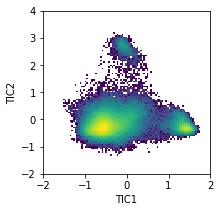

In [8]:
fig, ax = plt.subplots(figsize=(3,3))
plot_tics(ax, tics)

In [9]:
from bgmol.zmatrix import ZMatrixFactory
c_alpha = system.mdtraj_topology.select("name == CA")
zfactory = ZMatrixFactory(system.mdtraj_topology, cartesian=c_alpha)

In [10]:
z_matrix, fixed_atoms = zfactory.build_naive()

In [11]:
from bgflow import (
    BoltzmannGeneratorBuilder, 
    BONDS, ANGLES, TORSIONS, FIXED, 
    ShapeDictionary
)
import bgflow as bg

In [12]:
if False:
    import logging
    logger = logging.getLogger('bgflow')
    logger.setLevel(logging.DEBUG)
    if not logger.handlers:
        handler = logging.StreamHandler()
        handler.setLevel(logging.DEBUG)
        logger.addHandler(handler)

In [13]:
coordinate_transform = bg.RelativeInternalCoordinateTransformation(
    z_matrix=z_matrix,
    fixed_atoms=fixed_atoms,
)
shape_info = ShapeDictionary.from_coordinate_transform(
    coordinate_transform,
    n_constraints=system.system.getNumConstraints()
)

In [14]:
from bgmol.zmatrix import build_fake_topology
top, _ = build_fake_topology(10)
cg_zfactory = ZMatrixFactory(top)
cg_z_matrix, _ = cg_zfactory.build_naive()

In [15]:
from bgflow import (
    BoltzmannGeneratorBuilder, 
    BONDS, ANGLES, TORSIONS, FIXED, AUGMENTED, ORIGIN, ROTATION,
    ShapeDictionary
)

In [16]:
cg_crd_transform = bg.GlobalInternalCoordinateTransformation(cg_z_matrix)
cg_shape_info = ShapeDictionary.from_coordinate_transform(
    cg_crd_transform, dim_augmented=0
)
CG_BONDS = cg_shape_info.replace(BONDS, "CG_BONDS")
CG_ANGLES = cg_shape_info.replace(ANGLES, "CG_ANGLES")
CG_TORSIONS = cg_shape_info.replace(TORSIONS, "CG_TORSIONS")

In [17]:

shape_info.update(cg_shape_info)
del shape_info[FIXED]
#del shape_info[ORIGIN]
#del shape_info[ROTATION]
print(shape_info)

ShapeDictionary([(TensorInfo(name='BONDS', is_circular=False, is_cartesian=False), (87,)), (TensorInfo(name='ANGLES', is_circular=False, is_cartesian=False), (165,)), (TensorInfo(name='TORSIONS', is_circular=True, is_cartesian=False), (165,)), (TensorInfo(name='CG_BONDS', is_circular=False, is_cartesian=False), (9,)), (TensorInfo(name='CG_ANGLES', is_circular=False, is_cartesian=False), (8,)), (TensorInfo(name='CG_TORSIONS', is_circular=True, is_cartesian=False), (7,))])


## CG Torsions

In [18]:
cg_torsion_shapes = ShapeDictionary()
cg_torsion_shapes[CG_TORSIONS] = cg_shape_info[CG_TORSIONS]
cg_torsion_builder = BoltzmannGeneratorBuilder(cg_torsion_shapes, **ctx)
cgt1, cgt2 = cg_torsion_builder.add_split(
    CG_TORSIONS,
    into=["CGT1", "CGT2"],
    sizes_or_indices=[4,3],
    #sizes_or_indices=[np.arange(0,7,2), np.arange(1,7,2)]
)
for i in range(6):
    cg_torsion_builder.add_condition(cgt1, on=cgt2)
    cg_torsion_builder.add_condition(cgt2, on=cgt1)
cg_torsion_builder.add_merge(
    (cgt1, cgt2),
    to=CG_TORSIONS,
    sizes_or_indices=[4,3],
    #sizes_or_indices=[np.arange(0,7,2), np.arange(1,7,2)]
)
cg_torsion_generator = cg_torsion_builder.build_generator()

/srv/public/mameyer/bgflow/bgflow/factory/generator_builder.py:219: UserWarning: No target energy for TensorInfo(name='CG_TORSIONS', is_circular=True, is_cartesian=False).
  warnings.warn(f"No target energy for {field}.", UserWarning)


## CG Model

In [19]:
cg_full_builder = BoltzmannGeneratorBuilder(cg_shape_info, **ctx)
cg_full_builder.add_layer(cg_torsion_generator._flow, what=(CG_TORSIONS, ))

cga1, cga2 = cg_full_builder.add_split(
    CG_ANGLES,
    into=["CGA1", "CGA2"],
    #sizes_or_indices=[4,4],
    sizes_or_indices=[np.arange(0,8,2), np.arange(1,8,2)]
)
for i in range(6):
    cg_full_builder.add_condition(
        cga1, on=(CG_TORSIONS, CG_BONDS, cga2), param_groups=("cg_ba", )
    )
    cg_full_builder.add_condition(
        cga2, on=(CG_TORSIONS, CG_BONDS, cga1), param_groups=("cg_ba", )
    )
cg_full_builder.add_merge(
    (cga1, cga2),
    to=CG_ANGLES,
    #sizes_or_indices=[4,4],
    sizes_or_indices=[np.arange(0,8,2), np.arange(1,8,2)]
)

cg_full_builder.add_condition(
    CG_BONDS, on=(CG_TORSIONS, CG_ANGLES), param_groups=("cg_ba", )
)
cg_ic_generator = cg_full_builder.build_generator()

/srv/public/mameyer/bgflow/bgflow/factory/generator_builder.py:219: UserWarning: No target energy for TensorInfo(name='CG_BONDS', is_circular=False, is_cartesian=False).
  warnings.warn(f"No target energy for {field}.", UserWarning)
/srv/public/mameyer/bgflow/bgflow/factory/generator_builder.py:219: UserWarning: No target energy for TensorInfo(name='CG_ANGLES', is_circular=False, is_cartesian=False).
  warnings.warn(f"No target energy for {field}.", UserWarning)


# Side-Chain Model

In [20]:
builder = BoltzmannGeneratorBuilder(shape_info, target_energy, **ctx)

builder.add_layer(cg_ic_generator._flow, [CG_BONDS, CG_ANGLES, CG_TORSIONS])

#allegro_buffer = torch.Tensor()

### build the GNN using the Nequip library

### choose the conditioner type

In [21]:
conditioner = "allegro"  # "allegro", "nequip", "schnet", ("wrapdistances"), ("ICs")

In [22]:
if conditioner == "allegro":
    from bgflow.factory.GNN_factory import allegro_hparams as hparams, make_allegro_config_dict as make_config_dict
if conditioner in ["nequip", "schnet"]:
    from bgflow.factory.GNN_factory import nequip_hparams as hparams, make_nequip_config_dict as make_config_dict

from bgflow.nn.periodic import WrapDistances

In [23]:
#hparams

In [24]:
if conditioner in ["schnet", "allegro", "nequip"]:
    ### gather some data to initialize the RBF to be normalized
    distances_net = WrapDistances(torch.nn.Identity())
    fixed = coordinate_transform.forward(training_data[:1000])[3]
    RBF_distances = distances_net(fixed.detach()).flatten().cpu()
    RBF_distances = RBF_distances[RBF_distances<=hparams["r_max"]]

    avg_num_neighbors = ((len(RBF_distances)/(1000*fixed.shape[1]/3)))*2


    layers = make_config_dict(**hparams)
    layers["radial_basis"][1]["basis_kwargs"]["data"] = RBF_distances

    if conditioner == "allegro":
        layers["allegro"][1]["avg_num_neighbors"]= avg_num_neighbors

    if conditioner in ["nequip", "schnet"]:
        for i in range(hparams["num_interaction_blocks"]):
            layers[f"convnet_{i}"][1]["convolution_kwargs"]["avg_num_neighbors"]= avg_num_neighbors

        if conditioner == "schnet":
            hparams["irreps_edge_sh"] = "1x0e" ## this reduces nequip GNN to schnet basically.
    from nequip.nn import SequentialGraphNetwork
    # the layers object is a config dict, that contains all we need to construct a nequip GNN
    GNN = SequentialGraphNetwork.from_parameters(shared_params=None, layers=layers)

    from bgflow.factory.GNN_factory import NequipWrapper
    # the GNN has to be wrapped to return a Tensor, not a nequip "AtomicDataDict"
    GNN_feature_extractor = NequipWrapper(GNN, cutoff = hparams["r_max"])

In [25]:
use_checkpointing = False ### when the networks becomes to large to fit on the GPU you can use gradient checkpointing to trade memory cost for computation time

**GNN_output_dim**  
the GNN must return a single invariant feature vector for the whole graph. It may be the concatenation of edgewise/atomwise feature vectors.

THis feature vector is then, along with noncartesian conditioning input, fed into a dense NN.
You must give the dimension of the returned feature vector for the GNNConditioner to know the input dimension of this dense NN.


**r_max**  
the cutoff radius for the graph convolutions in the GNN. edges longer than this parameter will not be fed into the GNN (nequip GNN) or embedded into the zero vector (WrapDistancesGNN)

**GNN**  
either:
 1. an instance of a GNN, that outputs tensors of the shape (batch_size, GNN_output_dim)
 2. a constructor that builds such a GNN on the fly, using the **GNN_kwargs**


you can use GNNs as subnetworks in two diffenent ways:  
1. you have one GNN that generates atomwise/bondwise feature vectors for the fully connected graph of the cartesian input  
 All conditioners will refer to this GNN and apply dense NNs on its (recycled) output.  
2. you have an individual GNN for each conditioner.  
This will mean very much memory consumtion, and you will have to adjust your training procedure accordingly (gradient accumulation, gradient checkpointing etc.)  
If you choose this option, you have to either pass **GNN** a constructor, or pass each conditioner its own instance of a GNN

I would recommend option 1, as the GNNs are pretty large. This way, one GNN generates summary vectors for each atom/bond, thas is useful for each conditioner.  
  

**attention_level**  
You can optionally set an attention_level ("MHA", "Transformer").  
this will apply a Multiheaded Attention / a full torch.nn.TransformerEncoder to the GNN output in each conditioner individually.


**attention_units**  
you can have attention over atomwise or edgewise features.
the GNN output, one continuous feature vector for the whole graph, will be reshaped to (batchsize, attention_units, -1). the remaining dimension is the feature dimension of the  feature vectors. You will have to do do the maths of how many atoms/edges are there in your cartesian graph. 
if you set an attention level that is not none, attention will be performed over these feature vectors.
When deciding for bondwise vectors, you have to keep in mind that bonds larger than the cutoff will be embedded into the null vector


**use_checkpointing**  
you can use gradient checkpointing to run the networks at less memory requirements, at the cost of more cimpute time.

In [26]:
if conditioner in ["allegro", "nequip", "schnet"]:
    builder.default_conditioner_type = "GNN"
    builder.default_conditioner_kwargs = {
                                          "r_max": hparams["r_max"],
                                          "GNN": GNN_feature_extractor,  #1
                                          #"GNN": nequip_wrapper,  #2
                                          #"GNN_kwargs": {"shared_params": None,
                                          #               "layers": layers
                                          #              },
                                          "use_checkpointing": False,
                                          "GNN_output_dim": hparams["GNN_feature_dim"]*len(c_alpha),
                                          "attention_units": len(c_alpha),  #"atomwise",
                                          "attention_level": "Transformer"
                                         }

In [27]:
#if conditioner == "wrapdistances":
#    builder.default_conditioner_type = "wrapdistances"
#    builder.default_conditioner_kwargs = {"num_basis": 32,
#                                          "r_max": 15,
#                                          "env_p": 48,
#                                          "attention_level": None
#                                          }


In [28]:
if conditioner == "wrapdistances":
    from bgflow.factory.GNN_factory import WrapDistancesGNN
    builder.default_conditioner_type = "GNN"
    num_basis = 32
    builder.default_conditioner_kwargs = {
                                          "r_max": 1.2,
                                          "GNN": WrapDistancesGNN,
                                          "GNN_kwargs": {"num_basis": num_basis,
                                                         "r_max": 15,
                                                         "env_p": 48
                                                          },
                                          "use_checkpointing": True,  # False,
                                          "GNN_output_dim": (len(c_alpha)**2-len(c_alpha))//2*num_basis,  
                                          "attention_units": (len(c_alpha)**2-len(c_alpha))//2,
                                          "attention_level": "Transformer"
                                         }

In [29]:
if conditioner == "ICs":
    builder.default_conditioner_type = "dense"
    builder.default_conditioner_kwargs = {
                                          }
    CG_REP = [CG_BONDS, CG_ANGLES, CG_TORSIONS]    ##the CG structure is represented using CG ICs
else:
    CG_REP =[FIXED]    ##the CG structure is represented using Cartesian Coordinates

In [30]:
from bgflow import InternalCoordinateMarginals

In [31]:
from bgmol import bond_constraints

In [32]:
if conditioner != "ICs":
    cg_cdfs = InternalCoordinateMarginals(
        builder.current_dims,
        builder.ctx,
        bonds=CG_BONDS,
        angles=CG_ANGLES,
        torsions=CG_TORSIONS,
        #bond_sigma=5.0,
        bond_upper=3.0,
        bond_lower=0.03,
        angle_lower=0.1,
        angle_upper=1.0
    )
    cg_cdfs.inform_with_data(
        torch.tensor(dataset.xyz[:, c_alpha, :], **ctx).reshape(-1, len(c_alpha)*3),
        cg_crd_transform,
        bonds=CG_BONDS,
        angles=None,
        torsions=None,
    )

    cg_icdf_maps = builder.add_map_to_ic_domains(cg_cdfs, return_layers=True)

    builder.add_map_to_cartesian(
        cg_crd_transform,
        bonds=CG_BONDS, angles=CG_ANGLES, torsions=CG_TORSIONS, 
        out=FIXED
    )


In [33]:


n_torsions = builder.current_dims[TORSIONS][-1]
t1, t2 = builder.add_split(
    TORSIONS,
    into=["T1", "T2"],
    sizes_or_indices=[np.arange(0,n_torsions,2), np.arange(1,n_torsions,2)]
)
for i in range(4):
    builder.add_condition(
        t1,
        on=(*CG_REP, t2),
        hidden=(512, 512),
        param_groups=("aa", "torsions")
    )
    builder.add_condition(
        t2, on=(t1, *CG_REP),
        hidden=(512, 512),
        param_groups=("aa", "torsions")
    )
builder.add_merge(
    (t1, t2),
    to=TORSIONS,
    sizes_or_indices=[np.arange(0,n_torsions,2), np.arange(1,n_torsions,2)]
)


for i in range(2):
    builder.add_condition(
        BONDS,
        on=(ANGLES,*CG_REP, TORSIONS ),
        hidden=(512, 512),
        param_groups=("aa",)
    )
    builder.add_condition(
        ANGLES,
        on=(BONDS, TORSIONS, *CG_REP),
        hidden=(512, 512),
        param_groups=("aa",)
    )
if conditioner == "ICs":
    cg_cdfs = InternalCoordinateMarginals(
        builder.current_dims,
        builder.ctx,
        bonds=CG_BONDS,
        angles=CG_ANGLES,
        torsions=CG_TORSIONS,
        #bond_sigma=5.0,
        bond_upper=3.0,
        bond_lower=0.03,
        angle_lower=0.1,
        angle_upper=1.0
    )
    cg_cdfs.inform_with_data(
        torch.tensor(dataset.xyz[:, c_alpha, :], **ctx).reshape(-1, len(c_alpha)*3),
        cg_crd_transform,
        bonds=CG_BONDS,
        angles=None,
        torsions=None,
    )

    cg_icdf_maps = builder.add_map_to_ic_domains(cg_cdfs, return_layers=True)

    builder.add_map_to_cartesian(
        cg_crd_transform,
        bonds=CG_BONDS, angles=CG_ANGLES, torsions=CG_TORSIONS, 
        out=FIXED
    )


cdfs = InternalCoordinateMarginals(
    builder.current_dims,
    builder.ctx,
    bonds=BONDS,
    angles=ANGLES,
    torsions=None,#TORSIONS,
    fixed=None,
    bond_mu=0.2,
    bond_sigma=2.0,
    bond_upper=1.0,
    bond_lower=0.03,
    #angle_mu=0.7,
    angle_lower=0.1,
    angle_upper=0.9
)
cdfs.inform_with_data(torch.tensor(dataset.xyz[:1000], **ctx).reshape(1000,-1),
                      coordinate_transform,
                      constrained_bond_indices = bond_constraints(system.system, coordinate_transform)[0],
                      torsions = None)

aa_icdf_maps = builder.add_map_to_ic_domains(cdfs, return_layers=True)
builder.add_merge_constraints(*bond_constraints(system.system, coordinate_transform))
builder.add_map_to_cartesian(coordinate_transform)
generator = builder.build_generator(zero_parameters=False)


In [34]:
sum([np.prod(p.shape) for p in generator.parameters()])

22484281


the first couple of calls to the GNN may be painfully slow, wihich has to do with them being torchscript compiled.  
They will be faster after the first couple of runs though...


In [35]:
generator.sample(500).shape

torch.Size([500, 525])

In [36]:
d = training_data[:10,...]

In [37]:
generator.energy(d)

tensor([[-981.0965],
        [-981.7209],
        [-984.6757],
        [-980.6040],
        [-991.8463],
        [-983.9974],
        [-983.5727],
        [-964.4722],
        [-980.1158],
        [-978.4524]], device='cuda:0', grad_fn=<SubBackward0>)

### check invertibility of the whole flow

In [38]:
d = training_data[:10,...]

*d_ics, CG_FIXED ,j_crd = coordinate_transform(d)

*z,j_inv=generator.flow[:-1](*d_ics, CG_FIXED, inverse = True)

*d_ics_restored, CG_FIXED_restored, j = generator.flow[:-1](*z)

(d_ics[0]-d_ics_restored[0]).max(),(d_ics[1]-d_ics_restored[1]).max(),(d_ics[2]-d_ics_restored[2]).max(),(j+j_inv).max()

(tensor(5.4389e-07, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(1.6689e-06, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(6.5565e-07, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.0001, device='cuda:0', grad_fn=<MaxBackward1>))

### check equivariance of GNN

In [39]:
d = training_data[:10,...]

*d_ics, CG_FIXED ,j_crd = coordinate_transform(d)

CG_FIXED_CPU = CG_FIXED.to("cpu")

shape_info_test = ShapeDictionary()
shape_info_test[FIXED] = (30,)

cond = generator.flow[8].transformer._params_net.net

t2_pseudo = torch.randn(10,82*2)

In [40]:
inputt = torch.hstack((t2_pseudo, CG_FIXED_CPU))

inputt = inputt.to(**ctx)

In [41]:
output = cond(inputt)

In [42]:
R = torch.Tensor(np.linalg.qr(np.random.normal(size=(3, 3)))[0])

In [43]:
CG_FIXED_CPU_ = (CG_FIXED_CPU.view(-1,3)@R).view(10,-1)

In [44]:
torch.norm(CG_FIXED_CPU.view(-1,3)[0]-CG_FIXED_CPU.view(-1,3)[1])

tensor(0.3901)

In [45]:
torch.norm(CG_FIXED_CPU_.view(-1,3)[0]-CG_FIXED_CPU_.view(-1,3)[1])

tensor(0.3901)

In [46]:
inputt_ = torch.hstack((t2_pseudo, CG_FIXED_CPU_))

inputt_ = inputt.to(**ctx)

In [47]:
if conditioner in ["allegro", "nequip", "schnet"]:
    cond.GNN.num_evaluations = 0

In [48]:
output_ = cond(inputt_)

In [49]:
torch.all(torch.isclose(output[0], output_[0], atol=1e-06))

tensor(True, device='cuda:0')

In [50]:
if conditioner in ["allegro", "nequip", "schnet", "wrapdistances"]:
    cond.GNN.num_evaluations = 0

# TRAINING

## CG Torsions

In [51]:
if True:  #the CG_Torsions and CG_Bonds_and_Angles subflows are already trained and can be loaded from state_dict
    with torch.no_grad():
        _, _, _, ca, dlogp = coordinate_transform.forward(training_data)
        cg_bonds, cg_angles, cg_torsions, *_ = cg_crd_transform.forward(ca)
        cg_bonds = cg_icdf_maps[0].forward(cg_bonds, inverse=True)[0]
        cg_angles = cg_icdf_maps[1].forward(cg_angles, inverse=True)[0]
        cg_torsions = cg_icdf_maps[2].forward(cg_torsions, inverse=True)[0]

        _, _, _, tca, tdlogp = coordinate_transform.forward(test_data[:10000])
        tcg_bonds, tcg_angles, tcg_torsions, *_ = cg_crd_transform.forward(tca)
        tcg_bonds = cg_icdf_maps[0].forward(tcg_bonds, inverse=True)[0]
        tcg_angles = cg_icdf_maps[1].forward(tcg_angles, inverse=True)[0]
        tcg_torsions = cg_icdf_maps[2].forward(tcg_torsions, inverse=True)[0]

In [42]:
cg_torsion_optimizer = torch.optim.Adam(cg_torsion_generator.parameters(), lr=1e-4)
cg_torsion_trainer = bg.KLTrainer(
    cg_torsion_generator, 
    optim=cg_torsion_optimizer,
    train_energy=False,
    test_likelihood = True
)

In [43]:
cg_torsion_generator.train(True)
if False:
    cg_torsion_trainer.train(
        n_iter=3000, 
        data=cg_torsions,
        testdata=tcg_torsions,
        batchsize=1024,
        n_print=100, 
        w_energy=0.0
    )
_ = cg_torsion_generator.train(False)

In [44]:
%pdb off


Automatic pdb calling has been turned OFF


In [45]:
#import ipynbname
#nb_fname = ipynbname.name()
#nb_path = ipynbname.path()

In [46]:
#torch.save(cg_torsion_generator.state_dict(), f"models/{nb_fname}_CG_TORSIONS.pic")

cg_torsion_generator.load_state_dict(torch.load("models/CG_TORSIONS.pic"))

<All keys matched successfully>

## CG Bonds + Angles

In [47]:
cg_optimizer = torch.optim.Adam(cg_full_builder.param_groups["cg_ba"], lr=1e-4)
cg_trainer = bg.KLTrainer(
    cg_ic_generator, 
    optim=cg_optimizer,
    train_energy=False,
    test_likelihood=True
)

In [48]:
#cg_ic_sampler = bg.DataSetSampler(cg_bonds, cg_angles, cg_torsions)

In [49]:
#tcg_ic_sampler = bg.DataSetSampler(tcg_bonds, tcg_angles, tcg_torsions)

In [50]:
cg_ic_generator.train(True)
if False:
    cg_trainer.train(
        n_iter=3000, 
        data=cg_ic_sampler,
        testdata=tcg_ic_sampler,
        batchsize=1024,
        n_print=100, 
        w_energy=0.0
    )
_ = cg_ic_generator.train(False)

In [52]:
#import ipynbname
#nb_fname = ipynbname.name()
#nb_path = ipynbname.path()

#torch.save(cg_ic_generator.state_dict(), f"models/{nb_fname}_CG_IC.pic")

cg_ic_generator.load_state_dict(torch.load(f"models/CG_BONDS_ANGLES.pic"))

<All keys matched successfully>

## Side Chain

In [48]:
list(generator.flow[8].transformer._params_net.net.GNN.GNN.allegro.parameters())[0].shape

torch.Size([52, 128])

In [49]:
nll_optimizer = torch.optim.Adam(builder.param_groups["aa"], lr=1e-4)
nll_trainer = bg.KLTrainer(
    generator, 
    optim=nll_optimizer,
    train_energy=False,
    test_likelihood = True
)

In [51]:
if True:
    generator.train(True)
    nll_trainer.train(
        n_iter=3000, 
        data=training_data,
        testdata = test_data,
        batchsize=512,
        n_print=100, 
        w_energy=0.0
    )
    generator.train(False)


  0%|                                                  | 0/3000 [00:00<?, ?it/s]

> /srv/public/mameyer/bgflow/bgflow/nn/training/trainers.py(170)train()
    169                     bp()
--> 170                     l = w_likelihood / (w_likelihood + w_energy)
    171                     (l * nll).backward(retain_graph=True) # was True



ipdb>  !list(bg.flow[8].transformer._params_net.net.GNN.GNN.allegro.parameters())[0]


*** NameError: name 'bg' is not defined


ipdb>  !list(self.bg.flow[8].transformer._params_net.net.GNN.GNN.allegro.parameters())[0]


Parameter containing:
tensor([[-0.3490, -0.7998, -1.6026,  ...,  0.8122, -0.2952,  1.2171],
        [-0.5246,  0.0568,  1.0088,  ..., -0.0973,  0.3321, -1.3325],
        [ 0.2994, -0.9306, -0.8450,  ..., -0.3039, -0.4743, -1.6174],
        ...,
        [-1.0244, -1.6126, -0.2658,  ..., -1.1884, -0.7140, -1.6294],
        [-0.9050, -0.0572,  0.9719,  ..., -0.2495, -0.6861, -1.5834],
        [ 0.8792,  0.1544, -1.1645,  ..., -0.6149,  0.3712, -0.4325]],
       device='cuda:0', requires_grad=True)


ipdb>  c


  0%|                                       | 1/3000 [00:40<33:30:02, 40.21s/it]

1	NLL: -1005.6908	NLL(Test): -1002.8676	
> /srv/public/mameyer/bgflow/bgflow/nn/training/trainers.py(170)train()
    169                     bp()
--> 170                     l = w_likelihood / (w_likelihood + w_energy)
    171                     (l * nll).backward(retain_graph=True) # was True



ipdb>  c


  0%|                                       | 2/3000 [00:41<14:36:38, 17.54s/it]

> /srv/public/mameyer/bgflow/bgflow/nn/training/trainers.py(170)train()
    169                     bp()
--> 170                     l = w_likelihood / (w_likelihood + w_energy)
    171                     (l * nll).backward(retain_graph=True) # was True



ipdb>  c


  0%|                                        | 3/3000 [00:43<8:33:11, 10.27s/it]

> /srv/public/mameyer/bgflow/bgflow/nn/training/trainers.py(170)train()
    169                     bp()
--> 170                     l = w_likelihood / (w_likelihood + w_energy)
    171                     (l * nll).backward(retain_graph=True) # was True



ipdb>  c


  0%|                                        | 4/3000 [00:45<5:42:15,  6.85s/it]

> /srv/public/mameyer/bgflow/bgflow/nn/training/trainers.py(170)train()
    169                     bp()
--> 170                     l = w_likelihood / (w_likelihood + w_energy)
    171                     (l * nll).backward(retain_graph=True) # was True



ipdb>  !list(self.bg.flow[8].transformer._params_net.net.GNN.GNN.allegro.parameters())[0]


Parameter containing:
tensor([[-0.3494, -0.8002, -1.6022,  ...,  0.8119, -0.2948,  1.2167],
        [-0.5250,  0.0571,  1.0090,  ..., -0.0969,  0.3324, -1.3323],
        [ 0.2990, -0.9310, -0.8454,  ..., -0.3035, -0.4747, -1.6170],
        ...,
        [-1.0240, -1.6127, -0.2654,  ..., -1.1888, -0.7141, -1.6298],
        [-0.9050, -0.0575,  0.9715,  ..., -0.2499, -0.6862, -1.5830],
        [ 0.8790,  0.1543, -1.1649,  ..., -0.6145,  0.3714, -0.4321]],
       device='cuda:0', requires_grad=True)


ipdb>  optim


*** NameError: name 'optim' is not defined


ipdb>  self.optim


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    maximize: False
    weight_decay: 0
)


ipdb>  self.optim.parameters


*** AttributeError: 'Adam' object has no attribute 'parameters'


ipdb>  self.optim.__dict__


{'defaults': {'lr': 0.0001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False}, '_zero_grad_profile_name': 'Optimizer.zero_grad#Adam.zero_grad', 'state': defaultdict(<class 'dict'>, {Parameter containing:
tensor([[ 0.6732, -0.8934,  0.4583,  ..., -1.0973, -1.0451,  0.7569],
        [-0.5958, -1.5764, -0.6943,  ...,  0.9375,  0.2743,  1.2904],
        [-0.5870,  0.9666, -1.0621,  ..., -1.1538, -0.1623, -0.3801],
        ...,
        [ 0.2098, -0.8941,  1.0847,  ..., -1.3999,  0.6069,  1.0106],
        [-0.3259, -0.5464, -1.2933,  ...,  0.8379,  0.9420,  1.2089],
        [ 1.6204, -0.6454,  0.9917,  ...,  0.3986,  1.1360, -0.4343]],
       device='cuda:0', requires_grad=True): {'step': 4, 'exp_avg': tensor([[-0.0007, -0.0037, -0.0059,  ..., -0.0104, -0.0078, -0.0002],
        [ 0.0016, -0.0017,  0.0004,  ..., -0.0037, -0.0026,  0.0015],
        [-0.0019,  0.0039,  0.0026,  ...,  0.0067,  0.0036,  0.0009],
        ...,
        [-0.0011, -0.0014, -

ipdb>  q


  0%|                                       | 4/3000 [04:37<57:38:07, 69.25s/it]


BdbQuit: 

In [54]:
from matplotlib import pyplot as plt

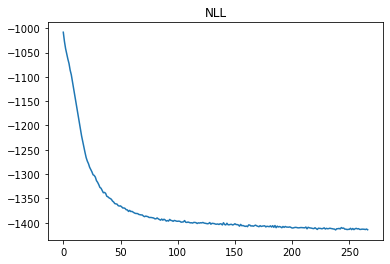

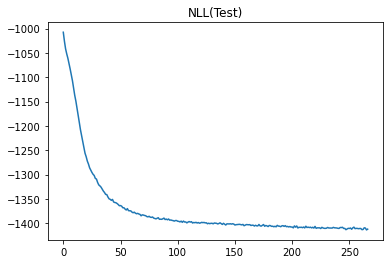

In [55]:
for i,label in enumerate(nll_trainer.reporter._labels):
    
    plt.plot(nll_trainer.reporter._raw[i]) #TODO: better reporter
    plt.title(label)
    plt.show()

In [53]:
import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

#torch.save(generator.state_dict(), f"models/{nb_fname}_{conditioner}_NLL.pic")

generator.load_state_dict(torch.load(f"models/{nb_fname}_{conditioner}_NLL.pic"))

RuntimeError: Error(s) in loading state_dict for BoltzmannGenerator:
	Missing key(s) in state_dict: "_flow._blocks.8.transformer._params_net.net.encoder_layer.self_attn.in_proj_weight", "_flow._blocks.8.transformer._params_net.net.encoder_layer.self_attn.in_proj_bias", "_flow._blocks.8.transformer._params_net.net.encoder_layer.self_attn.out_proj.weight", "_flow._blocks.8.transformer._params_net.net.encoder_layer.self_attn.out_proj.bias", "_flow._blocks.8.transformer._params_net.net.encoder_layer.linear1.weight", "_flow._blocks.8.transformer._params_net.net.encoder_layer.linear1.bias", "_flow._blocks.8.transformer._params_net.net.encoder_layer.linear2.weight", "_flow._blocks.8.transformer._params_net.net.encoder_layer.linear2.bias", "_flow._blocks.8.transformer._params_net.net.encoder_layer.norm1.weight", "_flow._blocks.8.transformer._params_net.net.encoder_layer.norm1.bias", "_flow._blocks.8.transformer._params_net.net.encoder_layer.norm2.weight", "_flow._blocks.8.transformer._params_net.net.encoder_layer.norm2.bias", "_flow._blocks.8.transformer._params_net.net.encoder_layer.qkv_proj.weight", "_flow._blocks.8.transformer._params_net.net.encoder_layer.qkv_proj.bias", "_flow._blocks.8.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_weight", "_flow._blocks.8.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_bias", "_flow._blocks.8.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.weight", "_flow._blocks.8.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.bias", "_flow._blocks.8.transformer._params_net.net.transformer_encoder.layers.0.linear1.weight", "_flow._blocks.8.transformer._params_net.net.transformer_encoder.layers.0.linear1.bias", "_flow._blocks.8.transformer._params_net.net.transformer_encoder.layers.0.linear2.weight", "_flow._blocks.8.transformer._params_net.net.transformer_encoder.layers.0.linear2.bias", "_flow._blocks.8.transformer._params_net.net.transformer_encoder.layers.0.norm1.weight", "_flow._blocks.8.transformer._params_net.net.transformer_encoder.layers.0.norm1.bias", "_flow._blocks.8.transformer._params_net.net.transformer_encoder.layers.0.norm2.weight", "_flow._blocks.8.transformer._params_net.net.transformer_encoder.layers.0.norm2.bias", "_flow._blocks.8.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.weight", "_flow._blocks.8.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.bias", "_flow._blocks.9.transformer._params_net.net.encoder_layer.self_attn.in_proj_weight", "_flow._blocks.9.transformer._params_net.net.encoder_layer.self_attn.in_proj_bias", "_flow._blocks.9.transformer._params_net.net.encoder_layer.self_attn.out_proj.weight", "_flow._blocks.9.transformer._params_net.net.encoder_layer.self_attn.out_proj.bias", "_flow._blocks.9.transformer._params_net.net.encoder_layer.linear1.weight", "_flow._blocks.9.transformer._params_net.net.encoder_layer.linear1.bias", "_flow._blocks.9.transformer._params_net.net.encoder_layer.linear2.weight", "_flow._blocks.9.transformer._params_net.net.encoder_layer.linear2.bias", "_flow._blocks.9.transformer._params_net.net.encoder_layer.norm1.weight", "_flow._blocks.9.transformer._params_net.net.encoder_layer.norm1.bias", "_flow._blocks.9.transformer._params_net.net.encoder_layer.norm2.weight", "_flow._blocks.9.transformer._params_net.net.encoder_layer.norm2.bias", "_flow._blocks.9.transformer._params_net.net.encoder_layer.qkv_proj.weight", "_flow._blocks.9.transformer._params_net.net.encoder_layer.qkv_proj.bias", "_flow._blocks.9.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_weight", "_flow._blocks.9.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_bias", "_flow._blocks.9.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.weight", "_flow._blocks.9.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.bias", "_flow._blocks.9.transformer._params_net.net.transformer_encoder.layers.0.linear1.weight", "_flow._blocks.9.transformer._params_net.net.transformer_encoder.layers.0.linear1.bias", "_flow._blocks.9.transformer._params_net.net.transformer_encoder.layers.0.linear2.weight", "_flow._blocks.9.transformer._params_net.net.transformer_encoder.layers.0.linear2.bias", "_flow._blocks.9.transformer._params_net.net.transformer_encoder.layers.0.norm1.weight", "_flow._blocks.9.transformer._params_net.net.transformer_encoder.layers.0.norm1.bias", "_flow._blocks.9.transformer._params_net.net.transformer_encoder.layers.0.norm2.weight", "_flow._blocks.9.transformer._params_net.net.transformer_encoder.layers.0.norm2.bias", "_flow._blocks.9.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.weight", "_flow._blocks.9.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.bias", "_flow._blocks.10.transformer._params_net.net.encoder_layer.self_attn.in_proj_weight", "_flow._blocks.10.transformer._params_net.net.encoder_layer.self_attn.in_proj_bias", "_flow._blocks.10.transformer._params_net.net.encoder_layer.self_attn.out_proj.weight", "_flow._blocks.10.transformer._params_net.net.encoder_layer.self_attn.out_proj.bias", "_flow._blocks.10.transformer._params_net.net.encoder_layer.linear1.weight", "_flow._blocks.10.transformer._params_net.net.encoder_layer.linear1.bias", "_flow._blocks.10.transformer._params_net.net.encoder_layer.linear2.weight", "_flow._blocks.10.transformer._params_net.net.encoder_layer.linear2.bias", "_flow._blocks.10.transformer._params_net.net.encoder_layer.norm1.weight", "_flow._blocks.10.transformer._params_net.net.encoder_layer.norm1.bias", "_flow._blocks.10.transformer._params_net.net.encoder_layer.norm2.weight", "_flow._blocks.10.transformer._params_net.net.encoder_layer.norm2.bias", "_flow._blocks.10.transformer._params_net.net.encoder_layer.qkv_proj.weight", "_flow._blocks.10.transformer._params_net.net.encoder_layer.qkv_proj.bias", "_flow._blocks.10.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_weight", "_flow._blocks.10.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_bias", "_flow._blocks.10.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.weight", "_flow._blocks.10.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.bias", "_flow._blocks.10.transformer._params_net.net.transformer_encoder.layers.0.linear1.weight", "_flow._blocks.10.transformer._params_net.net.transformer_encoder.layers.0.linear1.bias", "_flow._blocks.10.transformer._params_net.net.transformer_encoder.layers.0.linear2.weight", "_flow._blocks.10.transformer._params_net.net.transformer_encoder.layers.0.linear2.bias", "_flow._blocks.10.transformer._params_net.net.transformer_encoder.layers.0.norm1.weight", "_flow._blocks.10.transformer._params_net.net.transformer_encoder.layers.0.norm1.bias", "_flow._blocks.10.transformer._params_net.net.transformer_encoder.layers.0.norm2.weight", "_flow._blocks.10.transformer._params_net.net.transformer_encoder.layers.0.norm2.bias", "_flow._blocks.10.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.weight", "_flow._blocks.10.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.bias", "_flow._blocks.11.transformer._params_net.net.encoder_layer.self_attn.in_proj_weight", "_flow._blocks.11.transformer._params_net.net.encoder_layer.self_attn.in_proj_bias", "_flow._blocks.11.transformer._params_net.net.encoder_layer.self_attn.out_proj.weight", "_flow._blocks.11.transformer._params_net.net.encoder_layer.self_attn.out_proj.bias", "_flow._blocks.11.transformer._params_net.net.encoder_layer.linear1.weight", "_flow._blocks.11.transformer._params_net.net.encoder_layer.linear1.bias", "_flow._blocks.11.transformer._params_net.net.encoder_layer.linear2.weight", "_flow._blocks.11.transformer._params_net.net.encoder_layer.linear2.bias", "_flow._blocks.11.transformer._params_net.net.encoder_layer.norm1.weight", "_flow._blocks.11.transformer._params_net.net.encoder_layer.norm1.bias", "_flow._blocks.11.transformer._params_net.net.encoder_layer.norm2.weight", "_flow._blocks.11.transformer._params_net.net.encoder_layer.norm2.bias", "_flow._blocks.11.transformer._params_net.net.encoder_layer.qkv_proj.weight", "_flow._blocks.11.transformer._params_net.net.encoder_layer.qkv_proj.bias", "_flow._blocks.11.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_weight", "_flow._blocks.11.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_bias", "_flow._blocks.11.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.weight", "_flow._blocks.11.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.bias", "_flow._blocks.11.transformer._params_net.net.transformer_encoder.layers.0.linear1.weight", "_flow._blocks.11.transformer._params_net.net.transformer_encoder.layers.0.linear1.bias", "_flow._blocks.11.transformer._params_net.net.transformer_encoder.layers.0.linear2.weight", "_flow._blocks.11.transformer._params_net.net.transformer_encoder.layers.0.linear2.bias", "_flow._blocks.11.transformer._params_net.net.transformer_encoder.layers.0.norm1.weight", "_flow._blocks.11.transformer._params_net.net.transformer_encoder.layers.0.norm1.bias", "_flow._blocks.11.transformer._params_net.net.transformer_encoder.layers.0.norm2.weight", "_flow._blocks.11.transformer._params_net.net.transformer_encoder.layers.0.norm2.bias", "_flow._blocks.11.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.weight", "_flow._blocks.11.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.bias", "_flow._blocks.12.transformer._params_net.net.encoder_layer.self_attn.in_proj_weight", "_flow._blocks.12.transformer._params_net.net.encoder_layer.self_attn.in_proj_bias", "_flow._blocks.12.transformer._params_net.net.encoder_layer.self_attn.out_proj.weight", "_flow._blocks.12.transformer._params_net.net.encoder_layer.self_attn.out_proj.bias", "_flow._blocks.12.transformer._params_net.net.encoder_layer.linear1.weight", "_flow._blocks.12.transformer._params_net.net.encoder_layer.linear1.bias", "_flow._blocks.12.transformer._params_net.net.encoder_layer.linear2.weight", "_flow._blocks.12.transformer._params_net.net.encoder_layer.linear2.bias", "_flow._blocks.12.transformer._params_net.net.encoder_layer.norm1.weight", "_flow._blocks.12.transformer._params_net.net.encoder_layer.norm1.bias", "_flow._blocks.12.transformer._params_net.net.encoder_layer.norm2.weight", "_flow._blocks.12.transformer._params_net.net.encoder_layer.norm2.bias", "_flow._blocks.12.transformer._params_net.net.encoder_layer.qkv_proj.weight", "_flow._blocks.12.transformer._params_net.net.encoder_layer.qkv_proj.bias", "_flow._blocks.12.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_weight", "_flow._blocks.12.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_bias", "_flow._blocks.12.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.weight", "_flow._blocks.12.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.bias", "_flow._blocks.12.transformer._params_net.net.transformer_encoder.layers.0.linear1.weight", "_flow._blocks.12.transformer._params_net.net.transformer_encoder.layers.0.linear1.bias", "_flow._blocks.12.transformer._params_net.net.transformer_encoder.layers.0.linear2.weight", "_flow._blocks.12.transformer._params_net.net.transformer_encoder.layers.0.linear2.bias", "_flow._blocks.12.transformer._params_net.net.transformer_encoder.layers.0.norm1.weight", "_flow._blocks.12.transformer._params_net.net.transformer_encoder.layers.0.norm1.bias", "_flow._blocks.12.transformer._params_net.net.transformer_encoder.layers.0.norm2.weight", "_flow._blocks.12.transformer._params_net.net.transformer_encoder.layers.0.norm2.bias", "_flow._blocks.12.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.weight", "_flow._blocks.12.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.bias", "_flow._blocks.13.transformer._params_net.net.encoder_layer.self_attn.in_proj_weight", "_flow._blocks.13.transformer._params_net.net.encoder_layer.self_attn.in_proj_bias", "_flow._blocks.13.transformer._params_net.net.encoder_layer.self_attn.out_proj.weight", "_flow._blocks.13.transformer._params_net.net.encoder_layer.self_attn.out_proj.bias", "_flow._blocks.13.transformer._params_net.net.encoder_layer.linear1.weight", "_flow._blocks.13.transformer._params_net.net.encoder_layer.linear1.bias", "_flow._blocks.13.transformer._params_net.net.encoder_layer.linear2.weight", "_flow._blocks.13.transformer._params_net.net.encoder_layer.linear2.bias", "_flow._blocks.13.transformer._params_net.net.encoder_layer.norm1.weight", "_flow._blocks.13.transformer._params_net.net.encoder_layer.norm1.bias", "_flow._blocks.13.transformer._params_net.net.encoder_layer.norm2.weight", "_flow._blocks.13.transformer._params_net.net.encoder_layer.norm2.bias", "_flow._blocks.13.transformer._params_net.net.encoder_layer.qkv_proj.weight", "_flow._blocks.13.transformer._params_net.net.encoder_layer.qkv_proj.bias", "_flow._blocks.13.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_weight", "_flow._blocks.13.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_bias", "_flow._blocks.13.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.weight", "_flow._blocks.13.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.bias", "_flow._blocks.13.transformer._params_net.net.transformer_encoder.layers.0.linear1.weight", "_flow._blocks.13.transformer._params_net.net.transformer_encoder.layers.0.linear1.bias", "_flow._blocks.13.transformer._params_net.net.transformer_encoder.layers.0.linear2.weight", "_flow._blocks.13.transformer._params_net.net.transformer_encoder.layers.0.linear2.bias", "_flow._blocks.13.transformer._params_net.net.transformer_encoder.layers.0.norm1.weight", "_flow._blocks.13.transformer._params_net.net.transformer_encoder.layers.0.norm1.bias", "_flow._blocks.13.transformer._params_net.net.transformer_encoder.layers.0.norm2.weight", "_flow._blocks.13.transformer._params_net.net.transformer_encoder.layers.0.norm2.bias", "_flow._blocks.13.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.weight", "_flow._blocks.13.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.bias", "_flow._blocks.14.transformer._params_net.net.encoder_layer.self_attn.in_proj_weight", "_flow._blocks.14.transformer._params_net.net.encoder_layer.self_attn.in_proj_bias", "_flow._blocks.14.transformer._params_net.net.encoder_layer.self_attn.out_proj.weight", "_flow._blocks.14.transformer._params_net.net.encoder_layer.self_attn.out_proj.bias", "_flow._blocks.14.transformer._params_net.net.encoder_layer.linear1.weight", "_flow._blocks.14.transformer._params_net.net.encoder_layer.linear1.bias", "_flow._blocks.14.transformer._params_net.net.encoder_layer.linear2.weight", "_flow._blocks.14.transformer._params_net.net.encoder_layer.linear2.bias", "_flow._blocks.14.transformer._params_net.net.encoder_layer.norm1.weight", "_flow._blocks.14.transformer._params_net.net.encoder_layer.norm1.bias", "_flow._blocks.14.transformer._params_net.net.encoder_layer.norm2.weight", "_flow._blocks.14.transformer._params_net.net.encoder_layer.norm2.bias", "_flow._blocks.14.transformer._params_net.net.encoder_layer.qkv_proj.weight", "_flow._blocks.14.transformer._params_net.net.encoder_layer.qkv_proj.bias", "_flow._blocks.14.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_weight", "_flow._blocks.14.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_bias", "_flow._blocks.14.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.weight", "_flow._blocks.14.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.bias", "_flow._blocks.14.transformer._params_net.net.transformer_encoder.layers.0.linear1.weight", "_flow._blocks.14.transformer._params_net.net.transformer_encoder.layers.0.linear1.bias", "_flow._blocks.14.transformer._params_net.net.transformer_encoder.layers.0.linear2.weight", "_flow._blocks.14.transformer._params_net.net.transformer_encoder.layers.0.linear2.bias", "_flow._blocks.14.transformer._params_net.net.transformer_encoder.layers.0.norm1.weight", "_flow._blocks.14.transformer._params_net.net.transformer_encoder.layers.0.norm1.bias", "_flow._blocks.14.transformer._params_net.net.transformer_encoder.layers.0.norm2.weight", "_flow._blocks.14.transformer._params_net.net.transformer_encoder.layers.0.norm2.bias", "_flow._blocks.14.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.weight", "_flow._blocks.14.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.bias", "_flow._blocks.15.transformer._params_net.net.encoder_layer.self_attn.in_proj_weight", "_flow._blocks.15.transformer._params_net.net.encoder_layer.self_attn.in_proj_bias", "_flow._blocks.15.transformer._params_net.net.encoder_layer.self_attn.out_proj.weight", "_flow._blocks.15.transformer._params_net.net.encoder_layer.self_attn.out_proj.bias", "_flow._blocks.15.transformer._params_net.net.encoder_layer.linear1.weight", "_flow._blocks.15.transformer._params_net.net.encoder_layer.linear1.bias", "_flow._blocks.15.transformer._params_net.net.encoder_layer.linear2.weight", "_flow._blocks.15.transformer._params_net.net.encoder_layer.linear2.bias", "_flow._blocks.15.transformer._params_net.net.encoder_layer.norm1.weight", "_flow._blocks.15.transformer._params_net.net.encoder_layer.norm1.bias", "_flow._blocks.15.transformer._params_net.net.encoder_layer.norm2.weight", "_flow._blocks.15.transformer._params_net.net.encoder_layer.norm2.bias", "_flow._blocks.15.transformer._params_net.net.encoder_layer.qkv_proj.weight", "_flow._blocks.15.transformer._params_net.net.encoder_layer.qkv_proj.bias", "_flow._blocks.15.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_weight", "_flow._blocks.15.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_bias", "_flow._blocks.15.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.weight", "_flow._blocks.15.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.bias", "_flow._blocks.15.transformer._params_net.net.transformer_encoder.layers.0.linear1.weight", "_flow._blocks.15.transformer._params_net.net.transformer_encoder.layers.0.linear1.bias", "_flow._blocks.15.transformer._params_net.net.transformer_encoder.layers.0.linear2.weight", "_flow._blocks.15.transformer._params_net.net.transformer_encoder.layers.0.linear2.bias", "_flow._blocks.15.transformer._params_net.net.transformer_encoder.layers.0.norm1.weight", "_flow._blocks.15.transformer._params_net.net.transformer_encoder.layers.0.norm1.bias", "_flow._blocks.15.transformer._params_net.net.transformer_encoder.layers.0.norm2.weight", "_flow._blocks.15.transformer._params_net.net.transformer_encoder.layers.0.norm2.bias", "_flow._blocks.15.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.weight", "_flow._blocks.15.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.bias", "_flow._blocks.17.transformer._params_net.net.encoder_layer.self_attn.in_proj_weight", "_flow._blocks.17.transformer._params_net.net.encoder_layer.self_attn.in_proj_bias", "_flow._blocks.17.transformer._params_net.net.encoder_layer.self_attn.out_proj.weight", "_flow._blocks.17.transformer._params_net.net.encoder_layer.self_attn.out_proj.bias", "_flow._blocks.17.transformer._params_net.net.encoder_layer.linear1.weight", "_flow._blocks.17.transformer._params_net.net.encoder_layer.linear1.bias", "_flow._blocks.17.transformer._params_net.net.encoder_layer.linear2.weight", "_flow._blocks.17.transformer._params_net.net.encoder_layer.linear2.bias", "_flow._blocks.17.transformer._params_net.net.encoder_layer.norm1.weight", "_flow._blocks.17.transformer._params_net.net.encoder_layer.norm1.bias", "_flow._blocks.17.transformer._params_net.net.encoder_layer.norm2.weight", "_flow._blocks.17.transformer._params_net.net.encoder_layer.norm2.bias", "_flow._blocks.17.transformer._params_net.net.encoder_layer.qkv_proj.weight", "_flow._blocks.17.transformer._params_net.net.encoder_layer.qkv_proj.bias", "_flow._blocks.17.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_weight", "_flow._blocks.17.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_bias", "_flow._blocks.17.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.weight", "_flow._blocks.17.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.bias", "_flow._blocks.17.transformer._params_net.net.transformer_encoder.layers.0.linear1.weight", "_flow._blocks.17.transformer._params_net.net.transformer_encoder.layers.0.linear1.bias", "_flow._blocks.17.transformer._params_net.net.transformer_encoder.layers.0.linear2.weight", "_flow._blocks.17.transformer._params_net.net.transformer_encoder.layers.0.linear2.bias", "_flow._blocks.17.transformer._params_net.net.transformer_encoder.layers.0.norm1.weight", "_flow._blocks.17.transformer._params_net.net.transformer_encoder.layers.0.norm1.bias", "_flow._blocks.17.transformer._params_net.net.transformer_encoder.layers.0.norm2.weight", "_flow._blocks.17.transformer._params_net.net.transformer_encoder.layers.0.norm2.bias", "_flow._blocks.17.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.weight", "_flow._blocks.17.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.bias", "_flow._blocks.18.transformer._params_net.net.encoder_layer.self_attn.in_proj_weight", "_flow._blocks.18.transformer._params_net.net.encoder_layer.self_attn.in_proj_bias", "_flow._blocks.18.transformer._params_net.net.encoder_layer.self_attn.out_proj.weight", "_flow._blocks.18.transformer._params_net.net.encoder_layer.self_attn.out_proj.bias", "_flow._blocks.18.transformer._params_net.net.encoder_layer.linear1.weight", "_flow._blocks.18.transformer._params_net.net.encoder_layer.linear1.bias", "_flow._blocks.18.transformer._params_net.net.encoder_layer.linear2.weight", "_flow._blocks.18.transformer._params_net.net.encoder_layer.linear2.bias", "_flow._blocks.18.transformer._params_net.net.encoder_layer.norm1.weight", "_flow._blocks.18.transformer._params_net.net.encoder_layer.norm1.bias", "_flow._blocks.18.transformer._params_net.net.encoder_layer.norm2.weight", "_flow._blocks.18.transformer._params_net.net.encoder_layer.norm2.bias", "_flow._blocks.18.transformer._params_net.net.encoder_layer.qkv_proj.weight", "_flow._blocks.18.transformer._params_net.net.encoder_layer.qkv_proj.bias", "_flow._blocks.18.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_weight", "_flow._blocks.18.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_bias", "_flow._blocks.18.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.weight", "_flow._blocks.18.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.bias", "_flow._blocks.18.transformer._params_net.net.transformer_encoder.layers.0.linear1.weight", "_flow._blocks.18.transformer._params_net.net.transformer_encoder.layers.0.linear1.bias", "_flow._blocks.18.transformer._params_net.net.transformer_encoder.layers.0.linear2.weight", "_flow._blocks.18.transformer._params_net.net.transformer_encoder.layers.0.linear2.bias", "_flow._blocks.18.transformer._params_net.net.transformer_encoder.layers.0.norm1.weight", "_flow._blocks.18.transformer._params_net.net.transformer_encoder.layers.0.norm1.bias", "_flow._blocks.18.transformer._params_net.net.transformer_encoder.layers.0.norm2.weight", "_flow._blocks.18.transformer._params_net.net.transformer_encoder.layers.0.norm2.bias", "_flow._blocks.18.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.weight", "_flow._blocks.18.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.bias", "_flow._blocks.19.transformer._params_net.net.encoder_layer.self_attn.in_proj_weight", "_flow._blocks.19.transformer._params_net.net.encoder_layer.self_attn.in_proj_bias", "_flow._blocks.19.transformer._params_net.net.encoder_layer.self_attn.out_proj.weight", "_flow._blocks.19.transformer._params_net.net.encoder_layer.self_attn.out_proj.bias", "_flow._blocks.19.transformer._params_net.net.encoder_layer.linear1.weight", "_flow._blocks.19.transformer._params_net.net.encoder_layer.linear1.bias", "_flow._blocks.19.transformer._params_net.net.encoder_layer.linear2.weight", "_flow._blocks.19.transformer._params_net.net.encoder_layer.linear2.bias", "_flow._blocks.19.transformer._params_net.net.encoder_layer.norm1.weight", "_flow._blocks.19.transformer._params_net.net.encoder_layer.norm1.bias", "_flow._blocks.19.transformer._params_net.net.encoder_layer.norm2.weight", "_flow._blocks.19.transformer._params_net.net.encoder_layer.norm2.bias", "_flow._blocks.19.transformer._params_net.net.encoder_layer.qkv_proj.weight", "_flow._blocks.19.transformer._params_net.net.encoder_layer.qkv_proj.bias", "_flow._blocks.19.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_weight", "_flow._blocks.19.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_bias", "_flow._blocks.19.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.weight", "_flow._blocks.19.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.bias", "_flow._blocks.19.transformer._params_net.net.transformer_encoder.layers.0.linear1.weight", "_flow._blocks.19.transformer._params_net.net.transformer_encoder.layers.0.linear1.bias", "_flow._blocks.19.transformer._params_net.net.transformer_encoder.layers.0.linear2.weight", "_flow._blocks.19.transformer._params_net.net.transformer_encoder.layers.0.linear2.bias", "_flow._blocks.19.transformer._params_net.net.transformer_encoder.layers.0.norm1.weight", "_flow._blocks.19.transformer._params_net.net.transformer_encoder.layers.0.norm1.bias", "_flow._blocks.19.transformer._params_net.net.transformer_encoder.layers.0.norm2.weight", "_flow._blocks.19.transformer._params_net.net.transformer_encoder.layers.0.norm2.bias", "_flow._blocks.19.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.weight", "_flow._blocks.19.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.bias", "_flow._blocks.20.transformer._params_net.net.encoder_layer.self_attn.in_proj_weight", "_flow._blocks.20.transformer._params_net.net.encoder_layer.self_attn.in_proj_bias", "_flow._blocks.20.transformer._params_net.net.encoder_layer.self_attn.out_proj.weight", "_flow._blocks.20.transformer._params_net.net.encoder_layer.self_attn.out_proj.bias", "_flow._blocks.20.transformer._params_net.net.encoder_layer.linear1.weight", "_flow._blocks.20.transformer._params_net.net.encoder_layer.linear1.bias", "_flow._blocks.20.transformer._params_net.net.encoder_layer.linear2.weight", "_flow._blocks.20.transformer._params_net.net.encoder_layer.linear2.bias", "_flow._blocks.20.transformer._params_net.net.encoder_layer.norm1.weight", "_flow._blocks.20.transformer._params_net.net.encoder_layer.norm1.bias", "_flow._blocks.20.transformer._params_net.net.encoder_layer.norm2.weight", "_flow._blocks.20.transformer._params_net.net.encoder_layer.norm2.bias", "_flow._blocks.20.transformer._params_net.net.encoder_layer.qkv_proj.weight", "_flow._blocks.20.transformer._params_net.net.encoder_layer.qkv_proj.bias", "_flow._blocks.20.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_weight", "_flow._blocks.20.transformer._params_net.net.transformer_encoder.layers.0.self_attn.in_proj_bias", "_flow._blocks.20.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.weight", "_flow._blocks.20.transformer._params_net.net.transformer_encoder.layers.0.self_attn.out_proj.bias", "_flow._blocks.20.transformer._params_net.net.transformer_encoder.layers.0.linear1.weight", "_flow._blocks.20.transformer._params_net.net.transformer_encoder.layers.0.linear1.bias", "_flow._blocks.20.transformer._params_net.net.transformer_encoder.layers.0.linear2.weight", "_flow._blocks.20.transformer._params_net.net.transformer_encoder.layers.0.linear2.bias", "_flow._blocks.20.transformer._params_net.net.transformer_encoder.layers.0.norm1.weight", "_flow._blocks.20.transformer._params_net.net.transformer_encoder.layers.0.norm1.bias", "_flow._blocks.20.transformer._params_net.net.transformer_encoder.layers.0.norm2.weight", "_flow._blocks.20.transformer._params_net.net.transformer_encoder.layers.0.norm2.bias", "_flow._blocks.20.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.weight", "_flow._blocks.20.transformer._params_net.net.transformer_encoder.layers.0.qkv_proj.bias", "_flow._blocks.21._flow._delegate.distribution._mu", "_flow._blocks.21._flow._delegate.distribution._logsigma", "_flow._blocks.21._flow._delegate.distribution._upper_bound", "_flow._blocks.21._flow._delegate.distribution._lower_bound", "_flow._blocks.21._flow._delegate.distribution._cdf_lower_bound", "_flow._blocks.21._flow._delegate.distribution._cdf_upper_bound", "_flow._blocks.22._flow._delegate.distribution._mu", "_flow._blocks.22._flow._delegate.distribution._logsigma", "_flow._blocks.22._flow._delegate.distribution._upper_bound", "_flow._blocks.22._flow._delegate.distribution._lower_bound", "_flow._blocks.22._flow._delegate.distribution._cdf_lower_bound", "_flow._blocks.22._flow._delegate.distribution._cdf_upper_bound", "_flow._blocks.23._values_0". 
	Unexpected key(s) in state_dict: "_flow._blocks.26.transformer._params_net.net.GNN.GNN.radial_basis.basis._mean", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.radial_basis.basis._inv_std", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.radial_basis.basis.basis.bessel_weights", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.env_sum_normalizations", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro._zero", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro._latent_resnet_update_params", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.per_layer_cutoffs", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_0", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_1", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_2", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_3", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.latents.1._forward._weight_0", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.latents.2._forward._weight_0", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.0._forward._weight_0", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.1._forward._weight_0", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.2._forward._weight_0", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.tps.0._big_w3j", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.tps.1._big_w3j", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.tps.2._big_w3j", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.linears.0.w", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.linears.1.w", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.linears.2.w", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro._env_weighter._w_index", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.allegro.final_latent._forward._weight_0", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.weight", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.bias", "_flow._blocks.26.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.output_mask", "_flow._blocks.26.transformer._params_net.net.densenet._layers.0.weight", "_flow._blocks.26.transformer._params_net.net.densenet._layers.0.bias", "_flow._blocks.26.transformer._params_net.net.densenet._layers.2.weight", "_flow._blocks.26.transformer._params_net.net.densenet._layers.2.bias", "_flow._blocks.26.transformer._params_net.net.densenet._layers.4.weight", "_flow._blocks.26.transformer._params_net.net.densenet._layers.4.bias", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.radial_basis.basis._mean", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.radial_basis.basis._inv_std", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.radial_basis.basis.basis.bessel_weights", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.env_sum_normalizations", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro._zero", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro._latent_resnet_update_params", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.per_layer_cutoffs", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_0", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_1", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_2", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_3", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.latents.1._forward._weight_0", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.latents.2._forward._weight_0", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.0._forward._weight_0", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.1._forward._weight_0", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.2._forward._weight_0", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.tps.0._big_w3j", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.tps.1._big_w3j", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.tps.2._big_w3j", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.linears.0.w", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.linears.1.w", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.linears.2.w", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro._env_weighter._w_index", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.allegro.final_latent._forward._weight_0", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.weight", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.bias", "_flow._blocks.27.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.output_mask", "_flow._blocks.27.transformer._params_net.net.densenet._layers.0.weight", "_flow._blocks.27.transformer._params_net.net.densenet._layers.0.bias", "_flow._blocks.27.transformer._params_net.net.densenet._layers.2.weight", "_flow._blocks.27.transformer._params_net.net.densenet._layers.2.bias", "_flow._blocks.27.transformer._params_net.net.densenet._layers.4.weight", "_flow._blocks.27.transformer._params_net.net.densenet._layers.4.bias", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.radial_basis.basis._mean", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.radial_basis.basis._inv_std", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.radial_basis.basis.basis.bessel_weights", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.env_sum_normalizations", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro._zero", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro._latent_resnet_update_params", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.per_layer_cutoffs", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_0", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_1", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_2", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_3", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.latents.1._forward._weight_0", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.latents.2._forward._weight_0", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.0._forward._weight_0", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.1._forward._weight_0", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.2._forward._weight_0", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.tps.0._big_w3j", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.tps.1._big_w3j", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.tps.2._big_w3j", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.linears.0.w", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.linears.1.w", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.linears.2.w", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro._env_weighter._w_index", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.allegro.final_latent._forward._weight_0", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.weight", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.bias", "_flow._blocks.28.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.output_mask", "_flow._blocks.28.transformer._params_net.net.densenet._layers.0.weight", "_flow._blocks.28.transformer._params_net.net.densenet._layers.0.bias", "_flow._blocks.28.transformer._params_net.net.densenet._layers.2.weight", "_flow._blocks.28.transformer._params_net.net.densenet._layers.2.bias", "_flow._blocks.28.transformer._params_net.net.densenet._layers.4.weight", "_flow._blocks.28.transformer._params_net.net.densenet._layers.4.bias", "_flow._blocks.29._flow._delegate.distribution._mu", "_flow._blocks.29._flow._delegate.distribution._logsigma", "_flow._blocks.29._flow._delegate.distribution._upper_bound", "_flow._blocks.29._flow._delegate.distribution._lower_bound", "_flow._blocks.29._flow._delegate.distribution._cdf_lower_bound", "_flow._blocks.29._flow._delegate.distribution._cdf_upper_bound", "_flow._blocks.30._flow._delegate.distribution._mu", "_flow._blocks.30._flow._delegate.distribution._logsigma", "_flow._blocks.30._flow._delegate.distribution._upper_bound", "_flow._blocks.30._flow._delegate.distribution._lower_bound", "_flow._blocks.30._flow._delegate.distribution._cdf_lower_bound", "_flow._blocks.30._flow._delegate.distribution._cdf_upper_bound", "_flow._blocks.31._flow._delegate.distribution.low", "_flow._blocks.31._flow._delegate.distribution.high", "_flow._blocks.32._values_0", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.radial_basis.basis._mean", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.radial_basis.basis._inv_std", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.radial_basis.basis.basis.bessel_weights", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.env_sum_normalizations", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro._zero", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro._latent_resnet_update_params", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.per_layer_cutoffs", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_0", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_1", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_2", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_3", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.latents.1._forward._weight_0", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.latents.2._forward._weight_0", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.0._forward._weight_0", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.1._forward._weight_0", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.2._forward._weight_0", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.tps.0._big_w3j", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.tps.1._big_w3j", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.tps.2._big_w3j", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.linears.0.w", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.linears.1.w", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.linears.2.w", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro._env_weighter._w_index", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.allegro.final_latent._forward._weight_0", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.weight", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.bias", "_flow._blocks.16.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.output_mask", "_flow._blocks.16.transformer._params_net.net.densenet._layers.0.weight", "_flow._blocks.16.transformer._params_net.net.densenet._layers.0.bias", "_flow._blocks.16.transformer._params_net.net.densenet._layers.2.weight", "_flow._blocks.16.transformer._params_net.net.densenet._layers.2.bias", "_flow._blocks.16.transformer._params_net.net.densenet._layers.4.weight", "_flow._blocks.16.transformer._params_net.net.densenet._layers.4.bias", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.radial_basis.basis._mean", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.radial_basis.basis._inv_std", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.radial_basis.basis.basis.bessel_weights", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.env_sum_normalizations", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro._zero", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro._latent_resnet_update_params", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.per_layer_cutoffs", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_0", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_1", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_2", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_3", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.latents.1._forward._weight_0", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.latents.2._forward._weight_0", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.0._forward._weight_0", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.1._forward._weight_0", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.2._forward._weight_0", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.tps.0._big_w3j", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.tps.1._big_w3j", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.tps.2._big_w3j", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.linears.0.w", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.linears.1.w", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.linears.2.w", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro._env_weighter._w_index", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.allegro.final_latent._forward._weight_0", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.weight", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.bias", "_flow._blocks.21.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.output_mask", "_flow._blocks.21.transformer._params_net.net.densenet._layers.0.weight", "_flow._blocks.21.transformer._params_net.net.densenet._layers.0.bias", "_flow._blocks.21.transformer._params_net.net.densenet._layers.2.weight", "_flow._blocks.21.transformer._params_net.net.densenet._layers.2.bias", "_flow._blocks.21.transformer._params_net.net.densenet._layers.4.weight", "_flow._blocks.21.transformer._params_net.net.densenet._layers.4.bias", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.radial_basis.basis._mean", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.radial_basis.basis._inv_std", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.radial_basis.basis.basis.bessel_weights", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.env_sum_normalizations", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro._zero", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro._latent_resnet_update_params", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.per_layer_cutoffs", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_0", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_1", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_2", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_3", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.latents.1._forward._weight_0", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.latents.2._forward._weight_0", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.0._forward._weight_0", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.1._forward._weight_0", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.2._forward._weight_0", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.tps.0._big_w3j", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.tps.1._big_w3j", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.tps.2._big_w3j", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.linears.0.w", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.linears.1.w", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.linears.2.w", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro._env_weighter._w_index", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.allegro.final_latent._forward._weight_0", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.weight", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.bias", "_flow._blocks.22.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.output_mask", "_flow._blocks.22.transformer._params_net.net.densenet._layers.0.weight", "_flow._blocks.22.transformer._params_net.net.densenet._layers.0.bias", "_flow._blocks.22.transformer._params_net.net.densenet._layers.2.weight", "_flow._blocks.22.transformer._params_net.net.densenet._layers.2.bias", "_flow._blocks.22.transformer._params_net.net.densenet._layers.4.weight", "_flow._blocks.22.transformer._params_net.net.densenet._layers.4.bias", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.radial_basis.basis._mean", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.radial_basis.basis._inv_std", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.radial_basis.basis.basis.bessel_weights", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.env_sum_normalizations", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro._zero", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro._latent_resnet_update_params", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.per_layer_cutoffs", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_0", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_1", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_2", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_3", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.latents.1._forward._weight_0", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.latents.2._forward._weight_0", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.0._forward._weight_0", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.1._forward._weight_0", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.2._forward._weight_0", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.tps.0._big_w3j", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.tps.1._big_w3j", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.tps.2._big_w3j", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.linears.0.w", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.linears.1.w", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.linears.2.w", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro._env_weighter._w_index", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.allegro.final_latent._forward._weight_0", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.weight", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.bias", "_flow._blocks.23.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.output_mask", "_flow._blocks.23.transformer._params_net.net.densenet._layers.0.weight", "_flow._blocks.23.transformer._params_net.net.densenet._layers.0.bias", "_flow._blocks.23.transformer._params_net.net.densenet._layers.2.weight", "_flow._blocks.23.transformer._params_net.net.densenet._layers.2.bias", "_flow._blocks.23.transformer._params_net.net.densenet._layers.4.weight", "_flow._blocks.23.transformer._params_net.net.densenet._layers.4.bias", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.radial_basis.basis._mean", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.radial_basis.basis._inv_std", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.radial_basis.basis.basis.bessel_weights", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.env_sum_normalizations", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro._zero", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro._latent_resnet_update_params", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.per_layer_cutoffs", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_0", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_1", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_2", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.latents.0._forward._weight_3", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.latents.1._forward._weight_0", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.latents.2._forward._weight_0", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.0._forward._weight_0", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.1._forward._weight_0", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.env_embed_mlps.2._forward._weight_0", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.tps.0._big_w3j", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.tps.1._big_w3j", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.tps.2._big_w3j", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.linears.0.w", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.linears.1.w", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.linears.2.w", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro._env_weighter._w_index", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.allegro.final_latent._forward._weight_0", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.weight", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.bias", "_flow._blocks.25.transformer._params_net.net.GNN.GNN.atomwise_linear.linear.output_mask", "_flow._blocks.25.transformer._params_net.net.densenet._layers.0.weight", "_flow._blocks.25.transformer._params_net.net.densenet._layers.0.bias", "_flow._blocks.25.transformer._params_net.net.densenet._layers.2.weight", "_flow._blocks.25.transformer._params_net.net.densenet._layers.2.bias", "_flow._blocks.25.transformer._params_net.net.densenet._layers.4.weight", "_flow._blocks.25.transformer._params_net.net.densenet._layers.4.bias". 
	size mismatch for _flow._blocks.17.transformer._params_net.net.densenet._layers.0.weight: copying a param with shape torch.Size([512, 486]) from checkpoint, the shape in current model is torch.Size([512, 815]).
	size mismatch for _flow._blocks.17.transformer._params_net.net.densenet._layers.4.weight: copying a param with shape torch.Size([1968, 512]) from checkpoint, the shape in current model is torch.Size([2175, 512]).
	size mismatch for _flow._blocks.17.transformer._params_net.net.densenet._layers.4.bias: copying a param with shape torch.Size([1968]) from checkpoint, the shape in current model is torch.Size([2175]).
	size mismatch for _flow._blocks.18.transformer._params_net.net.densenet._layers.0.weight: copying a param with shape torch.Size([512, 484]) from checkpoint, the shape in current model is torch.Size([512, 737]).
	size mismatch for _flow._blocks.18.transformer._params_net.net.densenet._layers.4.weight: copying a param with shape torch.Size([1992, 512]) from checkpoint, the shape in current model is torch.Size([4125, 512]).
	size mismatch for _flow._blocks.18.transformer._params_net.net.densenet._layers.4.bias: copying a param with shape torch.Size([1992]) from checkpoint, the shape in current model is torch.Size([4125]).
	size mismatch for _flow._blocks.19.transformer._params_net.net.densenet._layers.0.weight: copying a param with shape torch.Size([512, 486]) from checkpoint, the shape in current model is torch.Size([512, 815]).
	size mismatch for _flow._blocks.19.transformer._params_net.net.densenet._layers.4.weight: copying a param with shape torch.Size([1968, 512]) from checkpoint, the shape in current model is torch.Size([2175, 512]).
	size mismatch for _flow._blocks.19.transformer._params_net.net.densenet._layers.4.bias: copying a param with shape torch.Size([1968]) from checkpoint, the shape in current model is torch.Size([2175]).
	size mismatch for _flow._blocks.20.transformer._params_net.net.densenet._layers.0.weight: copying a param with shape torch.Size([512, 484]) from checkpoint, the shape in current model is torch.Size([512, 737]).
	size mismatch for _flow._blocks.20.transformer._params_net.net.densenet._layers.4.weight: copying a param with shape torch.Size([1992, 512]) from checkpoint, the shape in current model is torch.Size([4125, 512]).
	size mismatch for _flow._blocks.20.transformer._params_net.net.densenet._layers.4.bias: copying a param with shape torch.Size([1992]) from checkpoint, the shape in current model is torch.Size([4125]).

## All together

In [86]:
full_nll_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)
full_nll_trainer = bg.KLTrainer(
    generator, 
    optim=full_nll_optimizer,
    train_energy=False,
    test_likelihood=True
)

In [87]:
if True:
    generator.train(True)
    full_nll_trainer.train(
        n_iter=3000, 
        data=training_data,
        testdata=test_data,
        batchsize=1000,
        n_print=100, 
        w_energy=0.0
    )
    generator.train(False)


  0%|                                                                                         | 1/3000 [00:03<3:14:58,  3.90s/it]

1	NLL: -1479.4985	NLL(Test): -1451.6921	


  3%|██▉                                                                                      | 101/3000 [01:55<53:39,  1.11s/it]

101	NLL: -1480.1206	NLL(Test): -1452.1061	


  7%|█████▉                                                                                   | 201/3000 [03:48<51:51,  1.11s/it]

201	NLL: -1480.5131	NLL(Test): -1452.6915	


 10%|████████▉                                                                                | 301/3000 [05:39<49:47,  1.11s/it]

301	NLL: -1479.9561	NLL(Test): -1452.4878	


 13%|███████████▉                                                                             | 401/3000 [07:32<48:27,  1.12s/it]

401	NLL: -1483.0098	NLL(Test): -1452.4661	


 17%|██████████████▊                                                                          | 501/3000 [09:23<46:30,  1.12s/it]

501	NLL: -1482.2811	NLL(Test): -1451.5098	


 20%|█████████████████▊                                                                       | 601/3000 [11:15<44:03,  1.10s/it]

601	NLL: -1483.0209	NLL(Test): -1451.2344	


 23%|████████████████████▊                                                                    | 701/3000 [13:06<42:23,  1.11s/it]

701	NLL: -1482.4031	NLL(Test): -1451.5211	


 27%|███████████████████████▊                                                                 | 801/3000 [14:56<40:17,  1.10s/it]

801	NLL: -1485.5933	NLL(Test): -1451.1017	


 30%|██████████████████████████▋                                                              | 901/3000 [16:50<39:07,  1.12s/it]

901	NLL: -1484.4661	NLL(Test): -1450.6805	


 33%|█████████████████████████████▎                                                          | 1001/3000 [18:42<37:12,  1.12s/it]

1001	NLL: -1484.8268	NLL(Test): -1449.4510	


 37%|████████████████████████████████▎                                                       | 1101/3000 [20:33<34:47,  1.10s/it]

1101	NLL: -1486.0432	NLL(Test): -1448.4365	


 40%|███████████████████████████████████▏                                                    | 1201/3000 [22:24<32:59,  1.10s/it]

1201	NLL: -1487.0638	NLL(Test): -1449.3535	


 43%|██████████████████████████████████████▏                                                 | 1301/3000 [24:15<31:48,  1.12s/it]

1301	NLL: -1487.3801	NLL(Test): -1446.5751	


 47%|█████████████████████████████████████████                                               | 1401/3000 [26:09<29:20,  1.10s/it]

1401	NLL: -1487.8711	NLL(Test): -1449.3118	


 50%|████████████████████████████████████████████                                            | 1501/3000 [28:00<27:25,  1.10s/it]

1501	NLL: -1488.5554	NLL(Test): -1447.8386	


 53%|██████████████████████████████████████████████▉                                         | 1601/3000 [29:51<25:49,  1.11s/it]

1601	NLL: -1491.3678	NLL(Test): -1448.5558	


 57%|█████████████████████████████████████████████████▉                                      | 1701/3000 [31:42<23:55,  1.10s/it]

1701	NLL: -1491.0920	NLL(Test): -1447.4604	


 60%|████████████████████████████████████████████████████▊                                   | 1801/3000 [33:33<22:14,  1.11s/it]

1801	NLL: -1490.8936	NLL(Test): -1447.5360	


 63%|███████████████████████████████████████████████████████▊                                | 1901/3000 [35:24<20:06,  1.10s/it]

1901	NLL: -1490.9711	NLL(Test): -1447.4255	


 67%|██████████████████████████████████████████████████████████▋                             | 2001/3000 [37:15<18:19,  1.10s/it]

2001	NLL: -1493.3263	NLL(Test): -1446.8966	


 70%|█████████████████████████████████████████████████████████████▋                          | 2101/3000 [39:06<16:29,  1.10s/it]

2101	NLL: -1494.4890	NLL(Test): -1446.0243	


 73%|████████████████████████████████████████████████████████████████▌                       | 2201/3000 [40:58<14:56,  1.12s/it]

2201	NLL: -1493.1044	NLL(Test): -1446.1345	


 77%|███████████████████████████████████████████████████████████████████▍                    | 2301/3000 [42:52<13:00,  1.12s/it]

2301	NLL: -1491.9723	NLL(Test): -1446.2330	


 80%|██████████████████████████████████████████████████████████████████████▍                 | 2401/3000 [44:44<11:08,  1.12s/it]

2401	NLL: -1497.5342	NLL(Test): -1446.0530	


 82%|███████████████████████████████████████████████████████████████████████▊                | 2448/3000 [45:37<10:17,  1.12s/it]


KeyboardInterrupt: 

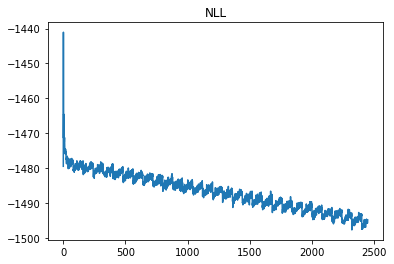

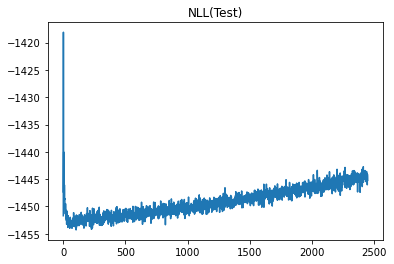

In [88]:
for i,label in enumerate(full_nll_trainer.reporter._labels):
    
    plt.plot(full_nll_trainer.reporter._raw[i]) #TODO: better reporter
    plt.title(label)
    plt.show()

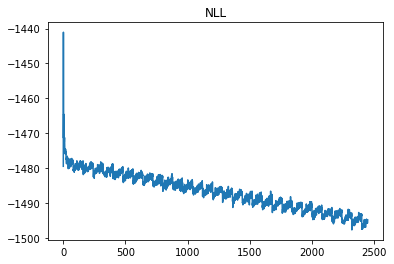

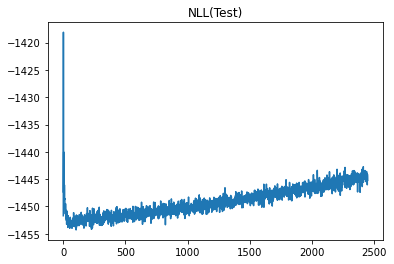

In [89]:
for i,label in enumerate(full_nll_trainer.reporter._labels):
    
    plt.plot(full_nll_trainer.reporter._raw[i]) #TODO: better reporter
    plt.title(label)
    plt.show()

In [90]:
import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

In [91]:
#torch.save(generator.state_dict(), f"models/{nb_fname}_AA_NLL.pic")

#generator.load_state_dict(torch.load(f"models/{nb_fname}_AA_NLL.pic"))

### Mixed Training

In [96]:
########

In [95]:
def andreas_loss(batch_size = 32, quantile = 0.5):
    kld = generator.kldiv(batch_size)
    lower = kld < kld.quantile(quantile)
    loss = kld[lower].mean()
    #kldiv = generator.kldiv(batch_size).flatten()
    #kldiv, _ = kldiv.sort()
    #low_kldivs = kldiv[:batch_size//2]
    ##loss = kldiv.mean()
    #loss = low_kldivs.mean()
    return(loss)

In [96]:
mixed_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-5)
mixed_trainer = bg.KLTrainer(
    generator, 
    optim=mixed_optimizer,
    train_energy=False,
    test_likelihood = True,
    custom_loss = andreas_loss
)

In [97]:
loss_names = ["NLL", "NLL(test)","andreas_loss"]
#loss_names = ["NLL". ]

mixed_trainer.reporter = bg.LossReporter(*loss_names)
#mixed_trainer.reporter._labels
#mixed_trainer.reporter._n_reported = 2

In [98]:
mixed_trainer.w_likelihood = 0.2

In [99]:
if True:
    generator.train(True)
    mixed_trainer.train(
        n_iter=3000, 
        data=training_data,
        testdata = test_data,
        batchsize=32,#128
        n_print=100, 
        w_energy=0.8,
        w_custom = 0.8,
        clip_forces=None,
        custom_loss_kwargs = {"batch_size": 512,
                          "quantile": 0.7}
    )
    generator.train(False)



  0%|                                                                                         | 1/3000 [00:02<2:16:01,  2.72s/it]

1	NLL: -1479.1808	NLL(test): -1451.9014	andreas_loss: 45573.0430	


  0%|                                                                                         | 3/3000 [00:15<4:25:19,  5.31s/it]


RuntimeError: CUDA out of memory. Tried to allocate 402.00 MiB (GPU 0; 7.93 GiB total capacity; 4.34 GiB already allocated; 400.88 MiB free; 6.12 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [99]:
########

In [102]:
torch.save(generator.state_dict(), f"models/{nb_fname}_AA_MIXED_0.7.pic")

In [95]:
generator.load_state_dict(torch.load(f"models/{nb_fname}_AA_MIXED_0.5.pic"))

<All keys matched successfully>

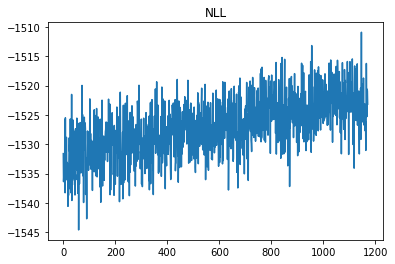

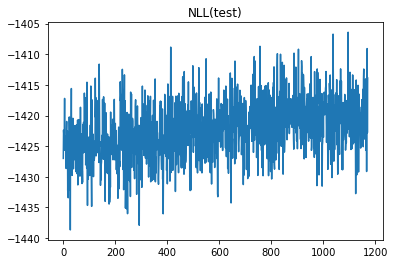

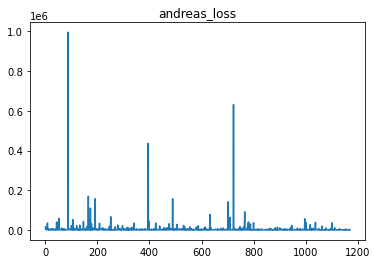

In [103]:
for i,label in enumerate(mixed_trainer.reporter._labels):
    
    plt.plot(mixed_trainer.reporter._raw[i]) #TODO: better reporter
    plt.title(label)
    plt.show()

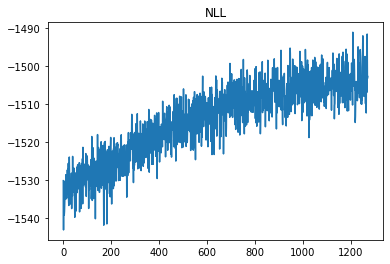

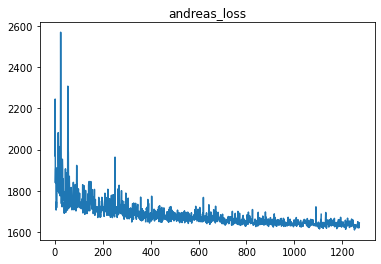

In [102]:
for i,label in enumerate(mixed_trainer.reporter._labels):
    
    plt.plot(mixed_trainer.reporter._raw[i]) #TODO: better reporter
    plt.title(label)
    plt.show()

In [100]:
%pdb off

Automatic pdb calling has been turned OFF


In [246]:
from bgflow.distribution.energy.linlogcut import LinLogCutEnergy

CutTarget = LinLogCutEnergy(generator._target)

In [101]:
1generator._target =  CutTarget

In [66]:
mixed_optimizer = torch.optim.Adam(builder.param_groups["aa"], lr=1e-5)
mixed_trainer = bg.KLTrainer(
    generator, 
    optim=mixed_optimizer,
    train_energy=True
)

In [67]:
#import cProfile
#import pstats
#profile = cProfile.Profile()
#
#*z_gen, jac_z_gen = profile.runcall(generator.flow,training_data[:1000], inverse = True)
#
#ps = pstats.Stats(profile)
#ps.sort_stats('cumtime') 
#ps.print_stats(100)
#

In [68]:
if True:
    generator.train(True)
    mixed_trainer.train(
        n_iter=3000, 
        data=training_data,
        batchsize=32,
        n_print=100, 
        w_energy=0.8,
        clip_forces=1.
    )
    generator.train(False)



1	KLL: 2209.3374	NLL: -1490.5376	
101	KLL: 2028.5878	NLL: -1474.9307	
201	KLL: 2091.5452	NLL: -1465.5579	
301	KLL: 1985.6057	NLL: -1471.1138	
401	KLL: 1900.5042	NLL: -1469.0039	
501	KLL: 1982.4873	NLL: -1461.1871	
601	KLL: 2076.1570	NLL: -1449.2412	
701	KLL: 1934.2351	NLL: -1459.3026	
801	KLL: 2120.2344	NLL: -1460.9480	
901	KLL: 2085.2729	NLL: -1452.1816	
1001	KLL: 1958.4399	NLL: -1459.7339	
1101	KLL: 2030.6901	NLL: -1449.2301	
1201	KLL: 2028.6904	NLL: -1445.2009	
1301	KLL: 2007.0171	NLL: -1445.5469	
1401	KLL: 1946.8594	NLL: -1454.0837	
1501	KLL: 2006.2300	NLL: -1457.6025	
1601	KLL: 1928.5928	NLL: -1449.7905	
1701	KLL: 2024.9414	NLL: -1442.8225	
1801	KLL: 2023.4259	NLL: -1447.3496	
1901	KLL: 1906.0337	NLL: -1445.2439	
2001	KLL: 2023.2753	NLL: -1448.7578	
2101	KLL: 1984.9907	NLL: -1450.9177	
2201	KLL: 1887.6235	NLL: -1445.5593	
2301	KLL: 1937.8279	NLL: -1445.4211	
2401	KLL: 2017.7856	NLL: -1455.8451	
2501	KLL: 2061.4648	NLL: -1454.7549	
2601	KLL: 1919.9603	NLL: -1447.4058	
2701	KLL: 198

Process Worker-5:
Process Worker-2:
Process Worker-4:
Process Worker-1:
Process Worker-7:
Process Worker-6:
Process Worker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Process Worker-8:
  File "/srv/public/mameyer/anaconda3/envs/oct21/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/srv/public/mameyer/bgflow/bgflow/distribution/energy/openmm.py", line 359, in run
    for task in iter(self._task_queue.get, None):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/srv/public/mameyer/anaconda3/envs/oct21/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/srv/public/mameyer/anaconda3/envs/oct21/lib/python3.10/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/srv/public/mameyer/anaconda3/envs/oct21/lib/python3.10/multiproce

In [180]:
#for p in generator.parameters():
#    print(p.grad.max())

In [127]:
torch.save(generator.state_dict(), "cgn_test_multiscale2.pt")

## Evaluate

In [ ]:
### check maximum sample size when torch nograd is active


### show tica of good vs bad samples

In [87]:
from tqdm import trange

In [88]:
batchsize = 512
num_batches = 10
good_samples = []
bad_samples = []
for batch in trange(num_batches):
    samples = generator.sample(batchsize)
    kld = generator._target.energy(samples)
    lower = kld < kld.quantile(0.9)
    good_samples.append(samples[lower[:,0]].detach().cpu())
    bad_samples.append(samples[~lower[:,0]].detach().cpu())
bad_samples = (torch.cat(bad_samples, dim = 0))
good_samples = (torch.cat(good_samples, dim = 0))

100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.63s/it]


Text(0.5, 1.0, 'bad_tics')

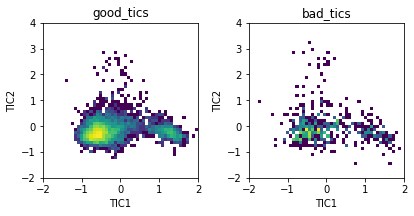

In [91]:
good_tics = system.to_tics(good_samples.view(len(good_samples), -1, 3), eigs_kept=2).cpu().numpy()
bad_tics = system.to_tics(bad_samples.view(len(bad_samples), -1, 3).cpu().numpy(), eigs_kept=2)

fig, axes = plt.subplots(1, 2, figsize=(6,3))
fig.tight_layout(pad=2)
plot_tics(axes[0], good_tics, bins=50)
axes[0].set_title("good_tics")
plot_tics(axes[1], bad_tics, bins=50)
axes[1].set_title("bad_tics")
#plot_scatter(axes[1], generated_tics)

#fig.savefig("test.png")



Text(0.5, 1.0, 'bad_tics')

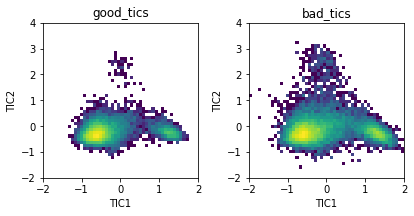

In [102]:
good_tics = system.to_tics(good_samples.view(len(good_samples), -1, 3), eigs_kept=2).cpu().numpy()
bad_tics = system.to_tics(bad_samples.view(len(bad_samples), -1, 3).cpu().numpy()[:good_tics.shape[0]], eigs_kept=2)

fig, axes = plt.subplots(1, 2, figsize=(6,3))
fig.tight_layout(pad=2)
plot_tics(axes[0], good_tics, bins=50)
axes[0].set_title("good_tics")
plot_tics(axes[1], bad_tics, bins=50)
axes[1].set_title("bad_tics")
#plot_scatter(axes[1], generated_tics)

#fig.savefig("test.png")



In [101]:
good_tics.shape, bad_tics.shape

((15500, 2), (16500, 2))

In [148]:
%debug

> /tmp/ipykernel_112178/3213161536.py(9)<cell line: 5>()
      7     kld = generator._target.energy(samples)
      8     lower = kld < kld.median()
----> 9     good_samples.append(samples[lower,:])
     10     bad_samples.append(samples[~lower,:])
     11 bad_samples = torch.stack(bad_samples)



ipdb>  q


In [232]:
generator.train(False)
n_samples = 10000
all_samples = []
for i in tqdm(range(n_samples // 100)):  
    with torch.no_grad():
        samples = generator.sample(100).cpu()
    all_samples.append(samples)
all_samples = torch.cat(all_samples, dim=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.01it/s]


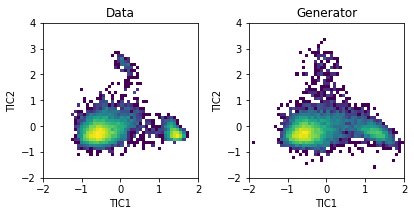

In [233]:
generated_tics = system.to_tics(all_samples.view(n_samples, -1, 3), eigs_kept=2).cpu().numpy()
test_tics = system.to_tics(test_data.view(len(test_data), -1, 3).cpu().numpy(), eigs_kept=2)

fig, axes = plt.subplots(1, 2, figsize=(6,3))
fig.tight_layout(pad=2)
plot_tics(axes[0], test_tics[:n_samples], bins=50)
axes[0].set_title("Data")
plot_tics(axes[1], generated_tics, bins=50)
axes[1].set_title("Generator")
#plot_scatter(axes[1], generated_tics)

fig.savefig("test.png")



In [234]:
target_energy.energy(samples[1:100]).min()

tensor(3388.1482)

In [235]:
#simulation_energy = dataset.get_energy_model(n_simulation_steps=10)

In [236]:
#simulation_energy.energy(samples[2:3]).min()

In [237]:
target_energy.energy(training_data[:1000]).max()

tensor(53.3508, device='cuda:0')

In [238]:
import nglview as nv
import mdtraj as md

In [239]:
traj = md.Trajectory(
    all_samples.cpu().view(-1,175,3).numpy(),
    topology=system.mdtraj_topology
)

In [240]:
w = nv.show_mdtraj(traj)
w.clear()
w.add_representation("licorice")
w

NGLWidget(max_frame=9999)

In [90]:
generator.flow

SequentialFlow(
  (_blocks): ModuleList(
    (0): WrapFlow(
      (_flow): SequentialFlow(
        (_blocks): ModuleList(
          (0): WrapFlow(
            (_flow): SequentialFlow(
              (_blocks): ModuleList(
                (0): WrapFlow(
                  (_flow): SplitFlow()
                )
                (1): CouplingFlow(
                  (transformer): ConditionalSplineTransformer(
                    (_params_net): WrapPeriodic(
                      (net): DenseNet(
                        (_layers): Sequential(
                          (0): Linear(in_features=6, out_features=128, bias=True)
                          (1): SiLU()
                          (2): Linear(in_features=128, out_features=128, bias=True)
                          (3): SiLU()
                          (4): Linear(in_features=128, out_features=96, bias=True)
                        )
                      )
                    )
                  )
                )
                (2): Co

### ENERGIES


In [92]:
system.system.getForces()

for force in range(len(system.system.getForces())):
    system.system.getForces()[force].setForceGroup(force)

system.reinitialize_energy_model(temperature=300, platform_name="CUDA", n_workers = 1)
target_real = system._energy_model

NUM_SAMPLES = 3

positions = test_data[:NUM_SAMPLES].reshape(NUM_SAMPLES, -1, 3)

target_real._bridge.context_wrapper

Context = target_real._bridge.context_wrapper._openmm_context

print(Context.getPlatform().getName())

p = positions[0]

p=p.to('cpu').numpy()


Context.setPositions(p)

state = Context.getState(
                    getEnergy=True,
                    getForces=False,
                    getPositions=False)
UNIT = state.getPotentialEnergy().unit

kbT = target_real._bridge._reduce_units

import openmm

from contextlib import redirect_stdout

#shape_info

CUDA


In [93]:
from tqdm import tqdm

import openmm
with open(f"metrics/{nb_fname}_NLL.pic", 'w+') as f:
    with redirect_stdout(f):
        NUM_SAMPLES = 10000
        BATCHSIZE = 512
        #generator_metrics(generator, valdata = valdata[:10000])
        ## MD samples
        
        energies = {}
        quants = []
        for q in range(9):
            quants.append(openmm.unit.quantity.Quantity(unit = UNIT))
        #quants = [openmm.unit.quantity.Quantity(unit = UNIT)]*7
        names = ["Bonds","Angles","HB","Torsion","cTorsion","CMAP","Nonbonded","GB","CMMremover"]
        for q,n in zip(quants,names):
            energies[n] = q
        
        
        #
        #data_native = data[:NUM_SAMPLES]
        #
        #positions,_ = data_native.reshape(NUM_SAMPLES,-1,3)
        
        n_batches = NUM_SAMPLES//BATCHSIZE
        #for i in range(n_batches):
         #   positions_batch = generator.sample(1000).cpu().detach().reshape(1000,-1,3).numpy()
         #   positions
        
        positions = test_data[:NUM_SAMPLES].reshape(NUM_SAMPLES,-1,3)
        
        for p in tqdm(positions):
            Context.setPositions(p.cpu().numpy())
            for i, (q, n) in enumerate(zip(quants,names)):
                #ipdb.set_trace()
                state = Context.getState(
                                getEnergy=True,
                                getForces=False,
                                getPositions=False,
                                groups = {i})
                #ipdb.set_trace()
                energies[n].append(state.getPotentialEnergy())
        
        #for key in energies:
        #    print(f"{key}: {energies[key].mean()}")
        print("*****MD-Data*****")
        resdict_MD = {}
        for key in energies:
            val = kbT(np.median(np.array(energies[key]._value)))
            print(f"{key}: {val}")
            resdict_MD[key] = val

######### de-novo samples
        
        
        energies = {}
        quants = []
        for q in range(9):
            quants.append(openmm.unit.quantity.Quantity(unit = UNIT))
        #quants = [openmm.unit.quantity.Quantity(unit = UNIT)]*7
        for q,n in zip(quants,names):
            energies[n] = q
        
        
        #
        #data_native = data[:NUM_SAMPLES]
        #
        #positions,_ = data_native.reshape(NUM_SAMPLES,-1,3)
        
        n_batches = NUM_SAMPLES//BATCHSIZE
        #for i in range(n_batches):
         #   positions_batch = generator.sample(1000).cpu().detach().reshape(1000,-1,3).numpy()
         #   positions
        pos = []
        B, A, ntT, tT, cB, cA, cT, j = generator.flow(test_data[:BATCHSIZE], inverse = True)
        for _ in tqdm(range(n_batches)):


            zB, zA, zntT, ztT, zcB, zcA, zcT = generator.prior.sample(BATCHSIZE)
            #bp()
            #samples = generator.flow(zB, zA, zntT, ztT, zcB, zcA, zcT)[0].detach().cpu().reshape(BATCHSIZE,-1,3).numpy()
            samples = generator.flow(zB, zA, zntT, ztT, cB, cA, cT)[0].detach().cpu().reshape(BATCHSIZE,-1,3).numpy()
            
            #j = generator.flow(B, A, ntT, tT, cB, cA, cT)[1]
            pos.append(samples)

        
        positions = np.concatenate(pos)
        for p in tqdm(positions):
            Context.setPositions(p)
            for i, (q, n) in enumerate(zip(quants,names)):
                #ipdb.set_trace()
                state = Context.getState(
                                getEnergy=True,
                                getForces=False,
                                getPositions=False,
                                groups = {i})
                #ipdb.set_trace()
                energies[n].append(state.getPotentialEnergy())
        
        #for key in energies:
        #    print(f"{key}: {energies[key].mean()}")
        print("*****de-novo-samples*****")
        resdict = {}
        for key in energies:
            val = kbT(np.median(np.array(energies[key]._value)))
            print(f"{key}: {val}")
            resdict[key] = val
resdict.pop("CMMremover")
resdict_MD.pop("CMMremover")

100%|██████████████████████████████████████████████████████████████████████████████████████| 9728/9728 [00:06<00:00, 1583.81it/s]


0.0

In [94]:
resdict

{'Bonds': 203.65878986396842,
 'Angles': 210.79184931423953,
 'HB': 30.265276011070466,
 'Torsion': 191.2135851693122,
 'cTorsion': 9.514283301925158,
 'CMAP': -11.68728149439446,
 'Nonbonded': 1372.7094576665775,
 'GB': -427.88006114431136}

In [90]:
resdict

{'Bonds': 884.0931785772462,
 'Angles': 1104.240674068825,
 'HB': 32.835661125879184,
 'Torsion': 346.7703028208123,
 'cTorsion': 10.521076721152976,
 'CMAP': -7.264364173208406,
 'Nonbonded': 140602558.9011138,
 'GB': -448.22368759171167}

In [89]:
resdict

{'Bonds': 217.43933653683567,
 'Angles': 227.63740550536022,
 'HB': 30.851391775091507,
 'Torsion': 192.32264569340995,
 'cTorsion': 9.841792672965212,
 'CMAP': -10.764295638799002,
 'Nonbonded': 4369.403044994294,
 'GB': -436.53569686492773}

In [99]:
resdict

{'Bonds': 216.14157355220718,
 'Angles': 226.17378843087178,
 'HB': 30.42062199150075,
 'Torsion': 192.57717715441956,
 'cTorsion': 9.86504708395818,
 'CMAP': -10.863441738819775,
 'Nonbonded': 4852.0352165162585,
 'GB': -436.6708172963539}

In [97]:
resdict

{'Bonds': 202.58426800139875,
 'Angles': 209.72074706056006,
 'HB': 30.219719969200185,
 'Torsion': 190.8999782824477,
 'cTorsion': 9.513553423417617,
 'CMAP': -11.664344421883031,
 'Nonbonded': 1563.7075463021224,
 'GB': -428.26538193997743}

In [95]:
resdict_MD

{'Bonds': 84.92628042235171,
 'Angles': 143.60351453862185,
 'HB': 14.5295205456141,
 'Torsion': 177.04939997706657,
 'cTorsion': 9.362265552195831,
 'CMAP': -12.250856285502717,
 'Nonbonded': 11.389640556506581,
 'GB': -435.01252109248725}

In [94]:
resdict

{'Bonds': 83.84181171889563,
 'Angles': 141.9365867280573,
 'HB': 14.310336003421693,
 'Torsion': 178.7598406284829,
 'cTorsion': 9.268086755249943,
 'CMAP': -12.295893498072456,
 'Nonbonded': 4.642195535580844,
 'GB': -429.6181767700021}

In [231]:
resdict

{'Bonds': 661.1231782823087,
 'Angles': 934.3446676743214,
 'HB': 15.611062088329625,
 'Torsion': 338.3599613350441,
 'cTorsion': 9.481589026945205,
 'CMAP': -8.195755675209448,
 'Nonbonded': 588173459.2591403,
 'GB': -437.80441458477844}

In [230]:
j

tensor([[1494.0597],
        [1487.1296],
        [1470.0258],
        [1484.0411],
        [1497.6653],
        [1480.6693],
        [1490.9792],
        [1487.7356],
        [1448.8882],
        [1481.2913],
        [1482.0249],
        [1449.8303],
        [1466.5944],
        [1486.7393],
        [1441.9818],
        [1495.0272],
        [1466.1141],
        [1478.6538],
        [1473.7650],
        [1466.5815],
        [1485.1687],
        [1509.1770],
        [1484.9348],
        [1485.1544],
        [1475.9675],
        [1482.4626],
        [1479.7231],
        [1491.6929],
        [1495.4263],
        [1491.0281],
        [1483.5002],
        [1443.4248],
        [1442.1497],
        [1457.8694],
        [1483.0515],
        [1479.5979],
        [1490.7800],
        [1456.4412],
        [1470.8527],
        [1499.0712],
        [1462.7097],
        [1471.3232],
        [1481.4041],
        [1486.7614],
        [1438.2493],
        [1464.7943],
        [1489.8440],
        [1487

In [228]:
j

tensor([[-1435.8477],
        [-1415.3020],
        [-1412.2244],
        [-1430.3257],
        [-1414.9314],
        [-1414.1580],
        [-1424.7808],
        [-1432.7122],
        [-1398.8237],
        [-1412.5376],
        [-1430.3566],
        [-1388.6852],
        [-1408.5247],
        [-1417.7394],
        [-1380.9788],
        [-1441.0664],
        [-1401.4534],
        [-1427.2543],
        [-1406.1744],
        [-1421.6772],
        [-1420.8451],
        [-1421.3883],
        [-1422.1744],
        [-1415.2346],
        [-1411.8757],
        [-1423.0065],
        [-1428.5114],
        [-1434.5840],
        [-1433.1042],
        [-1429.7468],
        [-1412.1421],
        [-1378.6909],
        [-1394.6187],
        [-1406.7152],
        [-1433.3450],
        [-1427.3990],
        [-1422.0070],
        [-1409.1178],
        [-1419.4999],
        [-1434.5844],
        [-1397.7216],
        [-1423.1292],
        [-1425.4056],
        [-1425.8334],
        [-1385.8032],
        [-

In [212]:
resdict

{'Bonds': 661.1240102444001,
 'Angles': 934.344276162749,
 'HB': 15.611063617671705,
 'Torsion': 338.3599735697807,
 'cTorsion': 9.481580997899286,
 'CMAP': -8.195746116821448,
 'Nonbonded': 588046887.839956,
 'GB': -437.8045858710914}

In [209]:
resdict

{'Bonds': 661.1246709201786,
 'Angles': 934.3452060027334,
 'HB': 15.611055970961306,
 'Torsion': 338.36026720346,
 'cTorsion': 9.481589791616244,
 'CMAP': -8.195748793170088,
 'Nonbonded': 588451413.4825382,
 'GB': -437.8046592795112}

In [205]:
resdict

{'Bonds': 84.97216068474289,
 'Angles': 140.6233468015822,
 'HB': 14.101092184747372,
 'Torsion': 184.62999997617447,
 'cTorsion': 8.414330009912053,
 'CMAP': -12.227258154877335,
 'Nonbonded': -36.16304915935321,
 'GB': -400.6399094100556}

In [202]:
resdict

{'Bonds': 84.97220350632111,
 'Angles': 140.62340797526537,
 'HB': 14.10110136079985,
 'Torsion': 184.62998162406953,
 'cTorsion': 8.414326951227894,
 'CMAP': -12.227266183923254,
 'Nonbonded': -36.16303692461657,
 'GB': -400.64005622689524}

In [116]:
resdict

{'Bonds': 661.124181530713,
 'Angles': 934.3439335901231,
 'HB': 15.611062088329625,
 'Torsion': 338.35992463083414,
 'cTorsion': 9.481593614971443,
 'CMAP': -8.195746116821448,
 'Nonbonded': 588278580.5047104,
 'GB': -437.8047082184578}

In [115]:
resdict

{'Bonds': 661.124181530713,
 'Angles': 934.3439335901231,
 'HB': 15.611062088329625,
 'Torsion': 338.35992463083414,
 'cTorsion': 9.481593614971443,
 'CMAP': -8.195746116821448,
 'Nonbonded': 588278580.5047104,
 'GB': -437.8047082184578}

In [101]:
resdict

{'Bonds': 661.1231293433622,
 'Angles': 934.344276162749,
 'HB': 15.611055206290267,
 'Torsion': 338.36040178556306,
 'cTorsion': 9.481583674247926,
 'CMAP': -8.195769821623685,
 'Nonbonded': 588347010.6638355,
 'GB': -437.80453693214486}

In [97]:
resdict

{'Bonds': 85.81322236147713,
 'Angles': 143.71975065404783,
 'HB': 14.265863500414884,
 'Torsion': 186.6038300379261,
 'cTorsion': 8.359477862210282,
 'CMAP': -12.264556131852723,
 'Nonbonded': -32.27722951218498,
 'GB': -400.8381121435855}

In [112]:
B, A, ntT, tT, cB, cA, cT, j = generator.flow(test_data[:BATCHSIZE], inverse = True)
zB, zA, zntT, ztT, zcB, zcA, zcT = generator.prior.sample(BATCHSIZE)
#bp()
samples = generator.flow(B, A, ntT, tT, cB, cA, cT)[0]

In [113]:
test_data[:BATCHSIZE]-samples

tensor([[-0.8991, -0.1072, -0.4647,  ..., -0.2780,  0.2150, -0.7336],
        [-0.8236,  0.2989, -0.4247,  ...,  0.2452,  0.6476, -0.3882],
        [-0.4377, -0.4035,  0.2624,  ..., -0.6733, -0.2751,  0.0112],
        ...,
        [-0.5772, -0.3142,  0.8040,  ...,  0.3968,  0.6441, -0.5733],
        [-0.6739, -0.4093,  0.7231,  ...,  0.2842, -0.0368,  0.6017],
        [ 0.3848,  0.3620,  0.0457,  ...,  0.2694,  0.1504, -0.6693]],
       device='cuda:0', grad_fn=<SubBackward0>)

In [107]:
test_data[:BATCHSIZE]-samples

tensor([[-0.8991, -0.1072, -0.4647,  ..., -0.2780,  0.2150, -0.7336],
        [-0.8236,  0.2989, -0.4247,  ...,  0.2452,  0.6476, -0.3882],
        [-0.4377, -0.4035,  0.2624,  ..., -0.6733, -0.2751,  0.0112],
        ...,
        [-0.5772, -0.3142,  0.8040,  ...,  0.3968,  0.6441, -0.5733],
        [-0.6739, -0.4093,  0.7231,  ...,  0.2842, -0.0368,  0.6017],
        [ 0.3848,  0.3620,  0.0457,  ...,  0.2694,  0.1504, -0.6693]],
       device='cuda:0', grad_fn=<SubBackward0>)

In [98]:
resdict_MD

{'Bonds': 84.92628042235171,
 'Angles': 143.60351453862185,
 'HB': 14.5295205456141,
 'Torsion': 177.04939997706657,
 'cTorsion': 9.362265552195831,
 'CMAP': -12.250856285502717,
 'Nonbonded': 11.389640556506581,
 'GB': -435.01252109248725}

In [207]:
from tqdm import tqdm

import openmm
with open(f"metrics/{nb_fname}_NLL.pic", 'w+') as f:
    with redirect_stdout(f):
        NUM_SAMPLES = 10000
        BATCHSIZE = 64
        #generator_metrics(generator, valdata = valdata[:10000])
        ## MD samples
        
        energies = {}
        quants = []
        for q in range(9):
            quants.append(openmm.unit.quantity.Quantity(unit = UNIT))
        #quants = [openmm.unit.quantity.Quantity(unit = UNIT)]*7
        names = ["Bonds","Angles","HB","Torsion","cTorsion","CMAP","Nonbonded","GB","CMMremover"]
        for q,n in zip(quants,names):
            energies[n] = q
        
        
        #
        #data_native = data[:NUM_SAMPLES]
        #
        #positions,_ = data_native.reshape(NUM_SAMPLES,-1,3)
        
        n_batches = NUM_SAMPLES//BATCHSIZE
        #for i in range(n_batches):
         #   positions_batch = generator.sample(1000).cpu().detach().reshape(1000,-1,3).numpy()
         #   positions
        
        positions = test_data[:NUM_SAMPLES].reshape(NUM_SAMPLES,-1,3)
        
        for p in tqdm(positions):
            Context.setPositions(p.cpu().numpy())
            for i, (q, n) in enumerate(zip(quants,names)):
                #ipdb.set_trace()
                state = Context.getState(
                                getEnergy=True,
                                getForces=False,
                                getPositions=False,
                                groups = {i})
                #ipdb.set_trace()
                energies[n].append(state.getPotentialEnergy())
        
        #for key in energies:
        #    print(f"{key}: {energies[key].mean()}")
        print("*****MD-Data*****")
        resdict_MD = {}
        for key in energies:
            val = kbT(np.median(np.array(energies[key]._value)))
            print(f"{key}: {val}")
            resdict_MD[key] = val

######### de-novo samples
        
        
        energies = {}
        quants = []
        for q in range(9):
            quants.append(openmm.unit.quantity.Quantity(unit = UNIT))
        #quants = [openmm.unit.quantity.Quantity(unit = UNIT)]*7
        for q,n in zip(quants,names):
            energies[n] = q
        
        
        #
        #data_native = data[:NUM_SAMPLES]
        #
        #positions,_ = data_native.reshape(NUM_SAMPLES,-1,3)
        
        n_batches = NUM_SAMPLES//BATCHSIZE
        #for i in range(n_batches):
         #   positions_batch = generator.sample(1000).cpu().detach().reshape(1000,-1,3).numpy()
         #   positions
        pos = []
        #B, A, T, BB, c1, C2, C3, C4, j = generator.flow(torch.Tensor(valdata[:BATCHSIZE]).to(ctx["device"]), inverse = True)
        for _ in tqdm(range(n_batches)):


            zB, zA, zntT, ztT, zcB, zcA, zcT = generator.prior.sample(BATCHSIZE)
            #bp()
            samples = generator.flow(zB, zA, zntT, ztT, zcB, zcA, zcT)[0].detach().cpu().reshape(BATCHSIZE,-1,3).numpy()
            #p = generator.sample(BATCHSIZE).cpu().detach().reshape(BATCHSIZE,-1,3).numpy()
            pos.append(samples)

        
        positions = np.concatenate(pos)
        for p in tqdm(positions):
            Context.setPositions(p)
            for i, (q, n) in enumerate(zip(quants,names)):
                #ipdb.set_trace()
                state = Context.getState(
                                getEnergy=True,
                                getForces=False,
                                getPositions=False,
                                groups = {i})
                #ipdb.set_trace()
                energies[n].append(state.getPotentialEnergy())
        
        #for key in energies:
        #    print(f"{key}: {energies[key].mean()}")
        print("*****de-novo-samples*****")
        resdict = {}
        for key in energies:
            val = kbT(np.median(np.array(energies[key]._value)))
            print(f"{key}: {val}")
            resdict[key] = val
resdict.pop("CMMremover")
resdict_MD.pop("CMMremover")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9984/9984 [00:06<00:00, 1476.01it/s]


0.0

In [104]:
resdict

{'Bonds': 489.7527393061289,
 'Angles': 736.648892691756,
 'HB': 32.19371061187016,
 'Torsion': 298.9218750509473,
 'cTorsion': 10.437794486524993,
 'CMAP': -7.55907450933605,
 'Nonbonded': 6163284.069389694,
 'GB': -453.4758153355208}

In [139]:
resdict

{'Bonds': 97.59492811222128,
 'Angles': 147.72273013925815,
 'HB': 14.524604475498885,
 'Torsion': 182.61587480930677,
 'cTorsion': 7.887792442954592,
 'CMAP': -10.200222282172762,
 'Nonbonded': 78.74901695031856,
 'GB': -457.0047538323372}

In [118]:
resdict

{'Bonds': 216.32546164387102,
 'Angles': 229.32167605510864,
 'HB': 30.044420662655977,
 'Torsion': 194.2388012066517,
 'cTorsion': 9.597916138224914,
 'CMAP': -10.83487439344191,
 'Nonbonded': 2695.9487854567064,
 'GB': -437.29929124795655}

In [128]:
resdict

{'Bonds': 232.72677454767876,
 'Angles': 245.3131619857651,
 'HB': 31.962744782966737,
 'Torsion': 200.8738518194557,
 'cTorsion': 9.758459587713078,
 'CMAP': -10.381837006835115,
 'Nonbonded': 15704.195521849035,
 'GB': -436.9041581935071}

In [100]:
resdict

{'Bonds': 224.7447711915946,
 'Angles': 233.8830550378295,
 'HB': 30.892197680462218,
 'Torsion': 196.4545854201494,
 'cTorsion': 9.738068105093319,
 'CMAP': -10.63571314476357,
 'Nonbonded': 5494.27236593523,
 'GB': -437.6772956711133}

In [119]:
resdict

{'Bonds': 207.48828690102525,
 'Angles': 214.29040895998463,
 'HB': 28.764979196142352,
 'Torsion': 189.16105516413893,
 'cTorsion': 9.630091201568804,
 'CMAP': -10.952614234467747,
 'Nonbonded': 2249.815769661636,
 'GB': -434.8635998781338}

In [91]:
resdict

{'Bonds': 218.67141122045666,
 'Angles': 226.3336964387258,
 'HB': 29.996486493851755,
 'Torsion': 194.95392156312218,
 'cTorsion': 9.827264687879046,
 'CMAP': -11.015163560856678,
 'Nonbonded': 11092.442898420504,
 'GB': -435.20641719872066}

In [90]:
resdict_MD

{'Bonds': 84.92628042235171,
 'Angles': 143.60351453862185,
 'HB': 14.5295205456141,
 'Torsion': 177.04939997706657,
 'cTorsion': 9.362265552195831,
 'CMAP': -12.250856285502717,
 'Nonbonded': 11.389640556506581,
 'GB': -435.01252109248725}

In [87]:
resdict

100%|█████████████████████████████████████| 9728/9728 [00:06<00:00, 1614.37it/s]


{'Bonds': 196.40601963306628,
 'Angles': 206.5190388298542,
 'HB': 28.50800843451561,
 'Torsion': 189.56372481635717,
 'cTorsion': 9.784658364545,
 'CMAP': -11.506625284880563,
 'Nonbonded': 2627.7030329803383,
 'GB': -434.4905872275252}

In [74]:
import openmm
with open(f"metrics/{nb_fname}_NLL.pic", 'w+') as f:
    with redirect_stdout(f):
        NUM_SAMPLES = 10000
        BATCHSIZE = 512
        #generator_metrics(generator, valdata = valdata[:10000])
        ## MD samples
        
        energies = {}
        quants = []
        for q in range(9):
            quants.append(openmm.unit.quantity.Quantity(unit = UNIT))
        #quants = [openmm.unit.quantity.Quantity(unit = UNIT)]*7
        names = ["Bonds","Angles","HB","Torsion","cTorsion","CMAP","Nonbonded","GB","CMMremover"]
        for q,n in zip(quants,names):
            energies[n] = q
        
        
        #
        #data_native = data[:NUM_SAMPLES]
        #
        #positions,_ = data_native.reshape(NUM_SAMPLES,-1,3)
        
        n_batches = NUM_SAMPLES//BATCHSIZE
        #for i in range(n_batches):
         #   positions_batch = generator.sample(1000).cpu().detach().reshape(1000,-1,3).numpy()
         #   positions
        
        positions = test_data[:NUM_SAMPLES].reshape(NUM_SAMPLES,-1,3)
        
        for p in tqdm(positions):
            Context.setPositions(p.cpu().numpy())
            for i, (q, n) in enumerate(zip(quants,names)):
                #ipdb.set_trace()
                state = Context.getState(
                                getEnergy=True,
                                getForces=False,
                                getPositions=False,
                                groups = {i})
                #ipdb.set_trace()
                energies[n].append(state.getPotentialEnergy())
        
        #for key in energies:
        #    print(f"{key}: {energies[key].mean()}")
        print("*****MD-Data*****")
        resdict_MD = {}
        for key in energies:
            val = kbT(np.median(np.array(energies[key]._value)))
            print(f"{key}: {val}")
            resdict_MD[key] = val

######### de-novo samples
        
        
        energies = {}
        quants = []
        for q in range(9):
            quants.append(openmm.unit.quantity.Quantity(unit = UNIT))
        #quants = [openmm.unit.quantity.Quantity(unit = UNIT)]*7
        for q,n in zip(quants,names):
            energies[n] = q
        
        
        #
        #data_native = data[:NUM_SAMPLES]
        #
        #positions,_ = data_native.reshape(NUM_SAMPLES,-1,3)
        
        n_batches = NUM_SAMPLES//BATCHSIZE
        #for i in range(n_batches):
         #   positions_batch = generator.sample(1000).cpu().detach().reshape(1000,-1,3).numpy()
         #   positions
        pos = []
        #B, A, T, BB, c1, C2, C3, C4, j = generator.flow(torch.Tensor(valdata[:BATCHSIZE]).to(ctx["device"]), inverse = True)
        for _ in tqdm(range(n_batches)):


            zB, zA, zntT, ztT, zcB, zcA, zcT = generator.prior.sample(BATCHSIZE)
            #bp()
            samples = generator.flow(zB, zA, zntT, ztT, zcB, zcA, zcT)[0].detach().cpu().reshape(BATCHSIZE,-1,3).numpy()
            #p = generator.sample(BATCHSIZE).cpu().detach().reshape(BATCHSIZE,-1,3).numpy()
            pos.append(samples)

        
        positions = np.concatenate(pos)
        for p in tqdm(positions):
            Context.setPositions(p)
            for i, (q, n) in enumerate(zip(quants,names)):
                #ipdb.set_trace()
                state = Context.getState(
                                getEnergy=True,
                                getForces=False,
                                getPositions=False,
                                groups = {i})
                #ipdb.set_trace()
                energies[n].append(state.getPotentialEnergy())
        
        #for key in energies:
        #    print(f"{key}: {energies[key].mean()}")
        print("*****de-novo-samples*****")
        resdict = {}
        for key in energies:
            val = kbT(np.median(np.array(energies[key]._value)))
            print(f"{key}: {val}")
            resdict[key] = val
resdict.pop("CMMremover")
resdict_MD.pop("CMMremover")

resdict_MD

resdict

100%|█████████████████████████████████████| 9728/9728 [00:06<00:00, 1591.65it/s]


{'Bonds': 193.12264453530412,
 'Angles': 206.5168977509426,
 'HB': 29.788800310085616,
 'Torsion': 188.54837625753547,
 'cTorsion': 9.799780499029131,
 'CMAP': -11.616282935350673,
 'Nonbonded': 2364.715509274145,
 'GB': -435.81262392964277}

In [110]:
resdict_MD

{'Bonds': 84.92628042235171,
 'Angles': 143.60351453862185,
 'HB': 14.5295205456141,
 'Torsion': 177.04939997706657,
 'cTorsion': 9.362265552195831,
 'CMAP': -12.250856285502717,
 'Nonbonded': 11.389640556506581,
 'GB': -435.01252109248725}

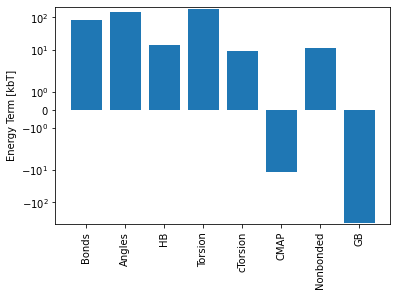

In [83]:
import matplotlib.pyplot as plt

D = resdict_MD

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
ax = plt.gca()
#ax.set_ylim([-1000, D.values().max()])
plt.ylabel('Energy Term [kbT]')
ax.set_yscale('symlog')
plt.xticks(rotation=90)
plt.savefig(f"figures/{nb_fname}_MD.png", bbox_inches="tight")
plt.show()

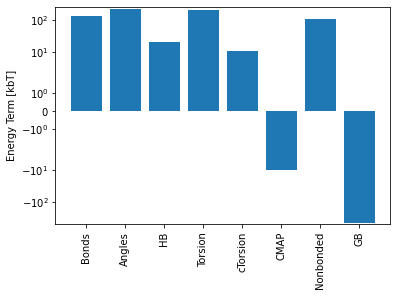

In [84]:
import matplotlib.pyplot as plt

D = resdict

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
ax = plt.gca()
#ax.set_ylim([-1000, 4000])
plt.ylabel('Energy Term [kbT]')
ax.set_yscale('symlog')
plt.xticks(rotation=90)
plt.savefig(f"figures/{nb_fname}_NLL.png", bbox_inches="tight")
plt.show()

### visualize energies

In [242]:
import ipywidgets as widgets
def plot_tics2(xyz, ax, system=system, lims=((-1.5, 2), (-1.5, 3.5))):
    n_samples = xyz.shape[0]
    xyz = as_numpy(xyz.reshape(n_samples, -1))
    tics = system.to_tics(xyz)
    
    ax.hist2d(
        tics[:,0], tics[:,1], 
        bins=100,
        range=lims, 
        norm=LogNorm(vmax=10, vmin=1e-4),
        density=True
    )
    ax.set_xlabel("TIC1")
    ax.set_ylabel("TIC2")
    ax.set_xlim(*lims[0])
    ax.set_ylim(*lims[1])
    
    

def show_structures(traj, top=system.mdtraj_topology):
    if not isinstance(traj, md.Trajectory):
        n_samples = traj.shape[0]
        traj = md.Trajectory(traj.reshape(n_samples, -1, 3), topology=top)
    traj.superpose(traj)
    widget = nv.show_mdtraj(traj)
    widget.add_representation("licorice")
    return widget
    
def evaluate_generator_unsorted(generator, samples, energies, true_target = False, num_energy = 1000, num_widget = 100):
    fig, axes = plt.subplots(1, 2, figsize=(9,3))
    
    if true_target:
        plot_energies(axes[1], samples[:num_energy], target_energy, test_data)
    else:
        plot_energies(axes[1], samples[:num_energy], CutTarget, test_data)
    tics = system.to_tics(samples.reshape(samples.shape[0],-1,3), eigs_kept=2)
    plot_tics(axes[0], tics)
    fig.tight_layout()
    global widget
    widget = show_structures(samples[:100])
    
    init_value = np.around(energies[0].item(), decimals = 2)
    output2 = widgets.BoundedFloatText(
        value = init_value,
        description='Energy:',
        disabled=True,
        min = -1e20,
        max = 1e50
    )
    display(output2)
    
    def on_value_change(change):
        value = np.around(energies[change['new']].item(), decimals = 2)
        output2.value = value
    widget._iplayer._trait_values["children"][1].observe(on_value_change, names='value')

    display(widget)    
    
def plot_energies(ax, samples, target_energy, test_data):
    sample_energies = target_energy.energy(torch.Tensor(samples)).numpy()
    md_energies = target_energy.energy(test_data[:len(samples)]).cpu().detach().numpy()
    cut = max(np.percentile(sample_energies, 80), 20)
   # import ipdb
   # ipdb.set_trace()
    ax.set_xlabel("Energy   [$k_B T$]")
    # y-axis on the right
    ax2 = plt.twinx(ax)
    ax.get_yaxis().set_visible(False)
    
    ax2.hist(sample_energies, range=(min(md_energies).item(), cut), bins=40, density=False, label="BG")
    ax2.hist(md_energies, range=(min(md_energies).item(), cut), bins=40, density=False, label="MD", alpha = 0.5)
    ax2.set_ylabel(f"Count   [#Samples / {len(samples)}]")
    ax2.legend()
    plt.savefig("figures/energies_NLL.png")

In [243]:
from tqdm import tqdm

In [244]:
from bgflow.utils import as_numpy
samples = np.concatenate([
    as_numpy(generator.sample(64))
    for _ in tqdm(range(13))
])
samples_energies = target_real.energy(torch.Tensor(samples))
sort = torch.argsort(samples_energies,0)
energies_sorted = samples_energies[sort].squeeze()
samples_sorted = samples[sort]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


In [112]:
import numpy

In [113]:
choice = numpy.random.choice(len(test_data), 16*13)
data_energies = target_real.energy(test_data[choice])

In [114]:
def plot_energies_michele(bg_energies, md_energies):  
    max_bg_ene = np.percentile(bg_energies, 50)
    rangex = np.linspace(min(np.amin(md_energies), np.amin(bg_energies)), max(np.amax(md_energies), max_bg_ene), 75)
    plt.hist(bg_energies, bins=rangex, density=True, label="BG", histtype='step')
    plt.hist(md_energies, bins=rangex, density=True, label="MD", histtype='step')
    plt.xlabel("Energy   [$k_B T$]")
    plt.ylabel(f"Count   [#Samples / {len(samples)}]")
    plt.legend()
    plt.show()
    print('---')
    print(f'BG energy: min={np.amin(bg_energies):g} max={np.amax(bg_energies):g}')
    print(f'MD energy: min={np.amin(md_energies):g} max={np.amax(md_energies):g}')
    if np.amin(bg_energies) > np.amax(md_energies):
        print(' +++ NO OVERLAP! +++')
    print('---')

  0%|                                                    | 0/13 [01:07<?, ?it/s]


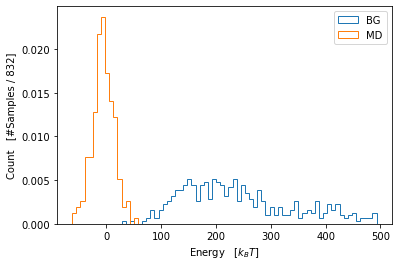

---
BG energy: min=30.0082 max=2.4546e+15
MD energy: min=-62.3476 max=50.5415
---


In [115]:
plot_energies_michele(samples_energies.numpy(), data_energies.cpu().numpy())

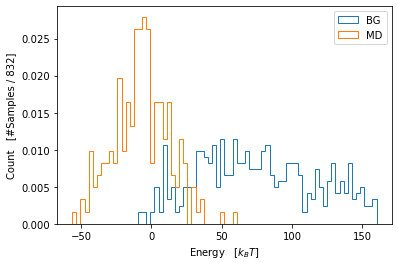

---
BG energy: min=-8.2975 max=6.10764e+17
MD energy: min=-56.3746 max=60.1727
---


In [144]:
plot_energies_michele(samples_energies.numpy(), data_energies.cpu().numpy())

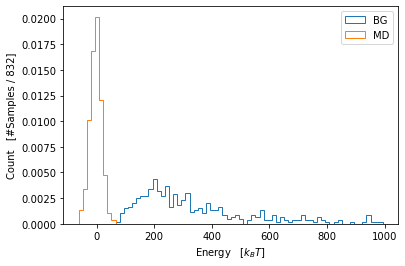

---
BG energy: min=74.7735 max=6.23209e+18
MD energy: min=-63.174 max=51.1805
 +++ NO OVERLAP! +++
---


In [123]:
plot_energies_michele(samples_energies.numpy(), data_energies.cpu().numpy())

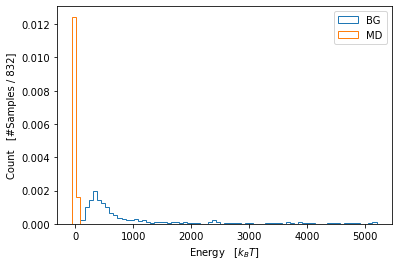

---
BG energy: min=97.8487 max=1.52688e+20
MD energy: min=-53.4494 max=57.0471
 +++ NO OVERLAP! +++
---


In [107]:
plot_energies_michele(samples_energies.numpy(), data_energies.cpu().numpy())

BoundedFloatText(value=74764148736.0, description='Energy:', disabled=True, max=1e+50, min=-1e+20)

NGLWidget(max_frame=99)

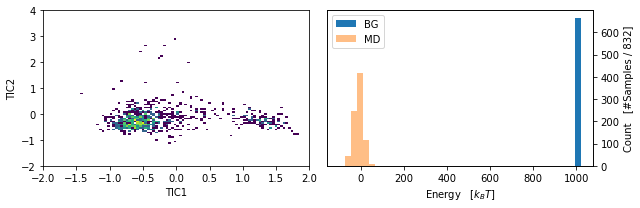

In [247]:
evaluate_generator_unsorted(generator, samples, samples_energies)

### highlight clashes

In [129]:
samples_xyz = samples.reshape(len(samples),samples.shape[-1]//3,3)

context = target_real._bridge.context_wrapper._openmm_context

forcelist = []
for id,sample_xyz in tqdm(enumerate(samples_xyz)):
    vec = []
    for i in range(len(sample_xyz)):
        vec.append(openmm.vec3.Vec3(sample_xyz[i,0],sample_xyz[i,1],sample_xyz[i,2]))
    context.setPositions(vec)

    state = context.getState(getPositions = True, getEnergy = True, getForces = True)
    forces = state.getForces(asNumpy = True)._value
    force_magn = np.linalg.norm(forces, axis=1)
    forcelist.append(force_magn)
forces = np.stack(forcelist,axis = 0)        
        #force_magn.argmax()

max_indices = forces.argsort(axis = -1)[:,-2:]

top = system._mdtraj_topology
traj = md.Trajectory(np.array(samples.reshape(samples.shape[0],-1,3)), topology=top)#[5:]
traj.superpose(traj)
#widget = nv.show_mdtraj(traj)
#widget.add_representation("licorice")
#widget

view = nv.show_mdtraj(traj, default_representation=False)
view.add_licorice()
view.add_cartoon(colorScheme = "residueindex")
view.add_ball_and_stick(selection = max_indices[0], color = "pink", aspectRatio = 3.)
view.center()

import time

def on_frame_change(change):
    frame = change['new']
    clashes = max_indices[frame]    
    view._remove_representation(repr_index = 2)
    view.add_ball_and_stick(selection = clashes, color = "pink", aspectRatio = 3.)


view.observe(on_frame_change, names=['frame'])

view

ValueError: cannot reshape array of size 33600 into shape (64,1,3)

### minimize samples energy

In [166]:
import openmm
from openmm import LocalEnergyMinimizer

In [167]:
target_real._bridge._n_simulation_steps = 0
samples_xyz = samples.reshape(len(samples),samples.shape[-1]//3,3)
#prmtop = openmm.app.amberprmtopfile.AmberPrmtopFile(os.path.join(filepath,'stripped_combined.prmtop'))
simulation = openmm.app.simulation.Simulation(system._topology, system.system, openmm.LangevinIntegrator(300, 1, 0.002))
from mdtraj.reporters import NetCDFReporter
from openmm.unit import *
threshold = Quantity(value=-1655.9926, unit=kilojoule/mole)

In [168]:
context = target_real._bridge.context_wrapper._openmm_context

In [169]:
samples_xyz_subset = samples_xyz[:10]

In [170]:
reporter = NetCDFReporter('relaxation.nc', 1)
reporter_bad = NetCDFReporter('relaxation_bad.nc', 1)



import copy

samples_minimized =  []
samples_energies = []
for id,sample_xyz in tqdm(enumerate(samples_xyz_subset)):
    vec = []
    for i in range(len(sample_xyz)):
        vec.append(openmm.vec3.Vec3(sample_xyz[i,0],sample_xyz[i,1],sample_xyz[i,2]))
    #context = target_real._openmm_energy_bridge.context_wrapper._openmm_context
    context.setPositions(positions = vec)
    state = context.getState(getPositions = True, getEnergy = True)
    #simulation.reporters.append(NetCDFReporter('relaxation.nc', 1))
    #state = simulation.context.getState(getPositions = True, getEnergy = True)
    #e0 = state.getPotentialEnergy()
    energies = []
    #positions = []
    e = state.getPotentialEnergy()
    energies.append(e)
    reporter.report(simulation,state)
    while e > threshold:
        e2 = copy.copy(e)
        LocalEnergyMinimizer.minimize(context,maxIterations = 2)
        state = context.getState(getPositions = True, getEnergy = True)
        #pos = state.getPositions()
        
        e = state.getPotentialEnergy()
        #ipdb.set_trace()
        if e2 == e or len(energies) > 20:
            if e2 == e:
                reporter_bad.report(simulation,state)
            break
        energies.append(e)
        reporter.report(simulation,state)

        #simulation.minimizeEnergy(maxIterations = 2)
        
        #ipdb.set_trace()
        #positions.append(pos)
        
    #state = context.getState(getPositions = True, getEnergy = True)
    #pos = state.getPositions()
    #e = state.getPotentialEnergy()
    reporter.report(simulation,state)
    energies.append(e)
    #positions.append(pos)


    #simulation.step(100)
    #state = simulation.context.getState(getPositions = True, getEnergy = True)
    minimized = torch.Tensor(np.array(state.getPositions(asNumpy = True).reshape((1,system.topology._numAtoms*3))))

    samples_minimized.append(minimized)
    #ipdb.set_trace()
    samples_energies.append(e)
samples_minimized = torch.cat(samples_minimized)
#samples_energies = torch.cat(samples_energies)


4it [00:03,  1.11it/s]


KeyboardInterrupt: 

In [171]:
np.median([energy._value for energy in samples_energies])

-300.9224853515625

#### visualize the relaxation

In [172]:
#traj = pt.load('relaxation.nc', top=os.path.join(filepath,'stripped_combined.prmtop'))
##traj = traj.superpose(traj)
##data_relax = traj.xyz.reshape(len(traj.xyz), -1)
#wid = nglview.show_pytraj(traj)
#wid.add_representation("licorice")
#wid

In [173]:
traj = md.load_netcdf('relaxation.nc', top=system._mdtraj_topology)
traj = traj.superpose(traj)
data_relax = traj.xyz.reshape(len(traj.xyz), -1)[31:]
wid = show_structures(data_relax)
wid

NGLWidget(max_frame=54)

### sampling efficiency

In [41]:
from bgflow.bg import log_weights_from_samples

In [43]:
log_weights_from_samples(generator.prior, generator.flow, generator._target, 10000, 1000)

tensor([-8.0813e+13, -1.2172e+12, -2.4027e+16,  ..., -8.2734e+12,
        -6.1201e+09, -1.0255e+09], device='cuda:0')

In [42]:
from torch.utils.data import DataLoader 
with torch.no_grad():
    weightdata = test_data[list(np.random.choice(len(test_data),1000))]
    weightloader = DataLoader(weightdata, batch_size=64, shuffle=True, drop_last = True)
    log_w = []
    for batch in weightloader:
        log_w.append(generator.log_weights(batch.to(**ctx)))
    log_w = torch.cat(log_w)
    print(bg.sampling_efficiency(log_w))


tensor(0.0167, device='cuda:0')


In [174]:
from torch.utils.data import DataLoader 

weightdata = test_data[list(np.random.choice(len(test_data),1000))]
weightloader = DataLoader(weightdata, batch_size=100, shuffle=True, drop_last = True)
log_w = []
for batch in weightloader:
    log_w.append(generator.log_weights(batch.to(**ctx)))
log_w = torch.cat(log_w)
bg.sampling_efficiency(log_w)


tensor(0.0120, device='cuda:0', grad_fn=<DivBackward0>)

In [100]:
from bgflow.bg import log_weights_from_true_samples

In [128]:
log_w = log_weights_from_true_samples(generator._prior, generator._flow, generator._target, num_samples = 10000, batch_size = 50,
                              temperature=1.0, normalize=True)

In [133]:
torch.exp(log_w.max())

tensor(0.9957, device='cuda:0')

In [130]:
bg.effective_sample_size(log_w)

tensor(1.0087, device='cuda:0')

In [177]:
1-7*8/2+6*8-6*7/2


0.0

### marginals

In [97]:
n_samples = 10000

In [98]:
from tqdm import tqdm

In [99]:
%pdb off

Automatic pdb calling has been turned OFF


In [100]:
from bgflow.utils import as_numpy


In [101]:
samples = np.concatenate([
    as_numpy(generator.sample(50))
    for _ in tqdm(range(200))
])

100%|█████████████████████████████████████████| 200/200 [01:00<00:00,  3.30it/s]


/srv/public/mameyer/bgflow/bgflow/nn/flow/crd_transform/ic_helper.py:283: UserWarning: singular division in torsion computation
  warnings.warn("singular division in torsion computation")


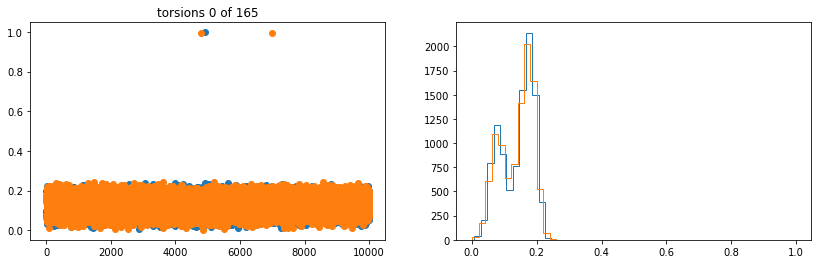

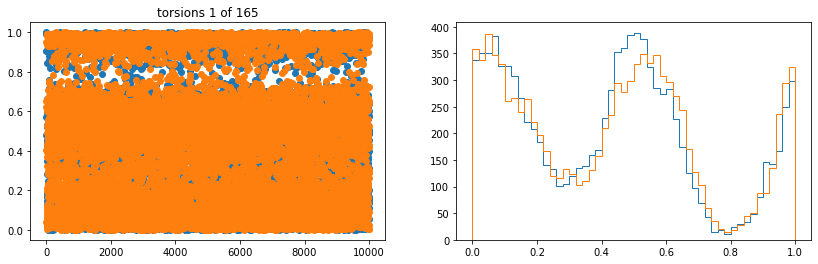

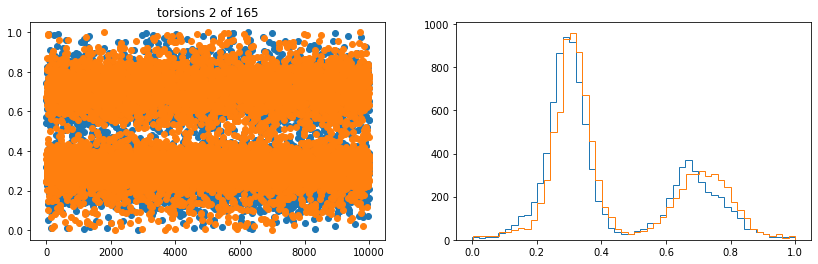

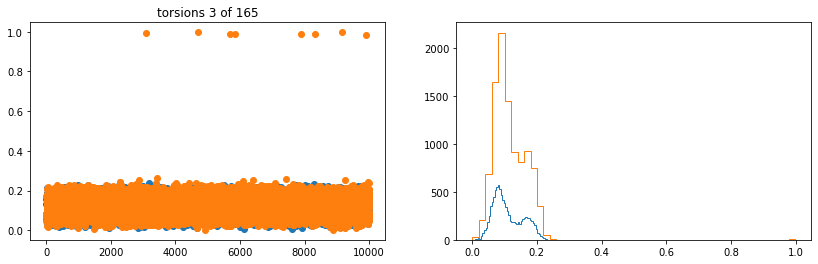

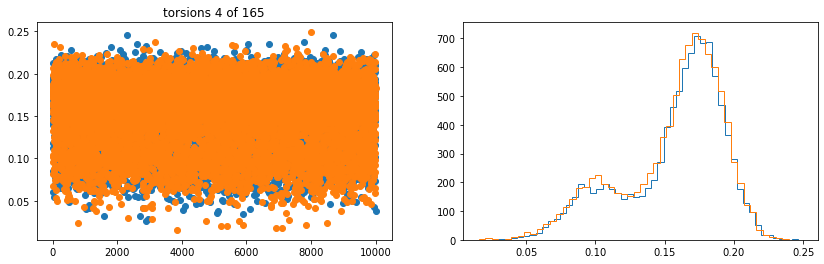

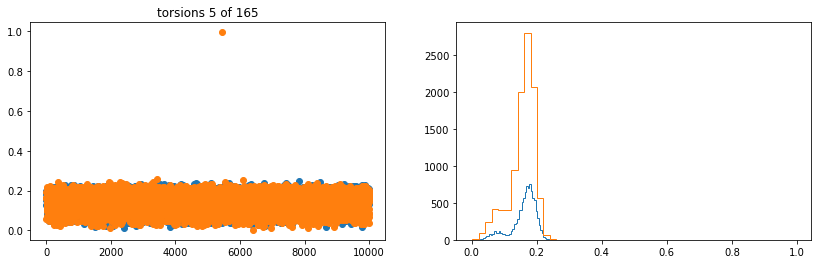

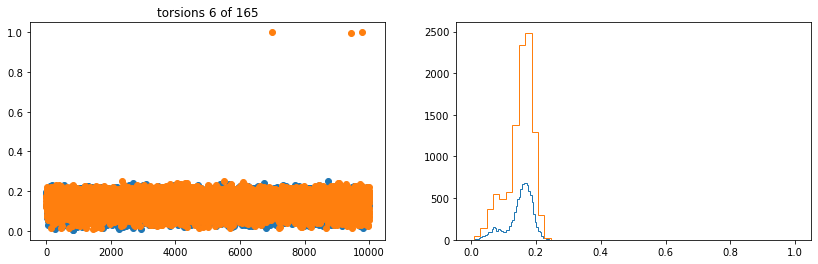

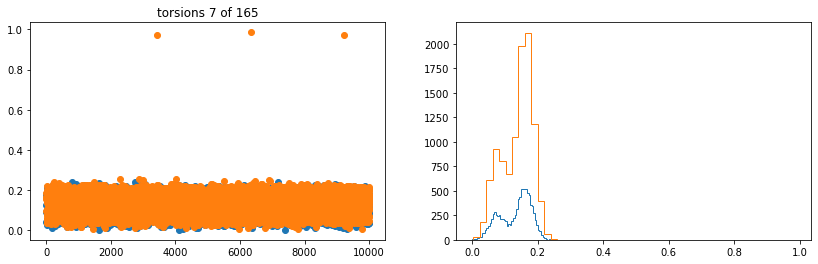

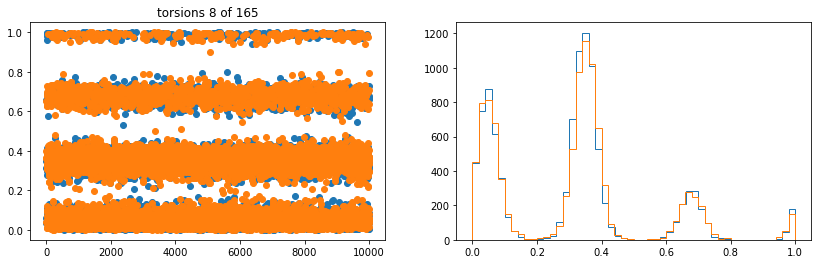

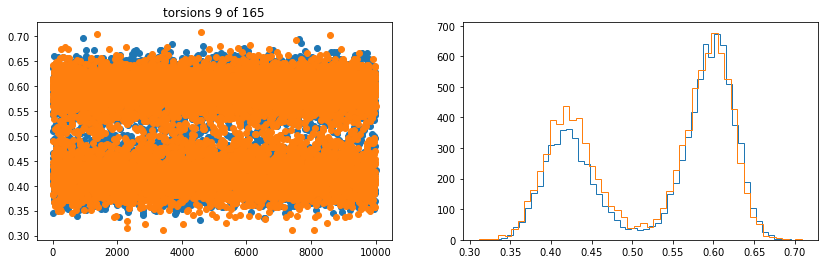

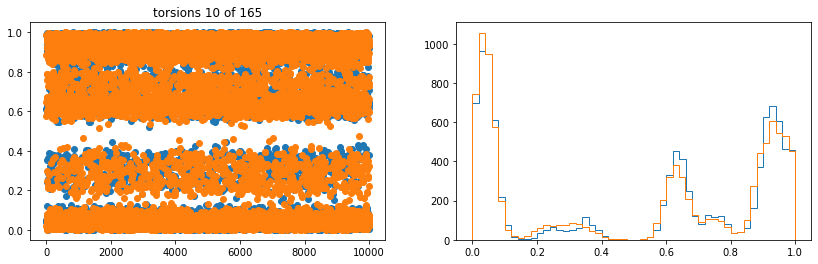

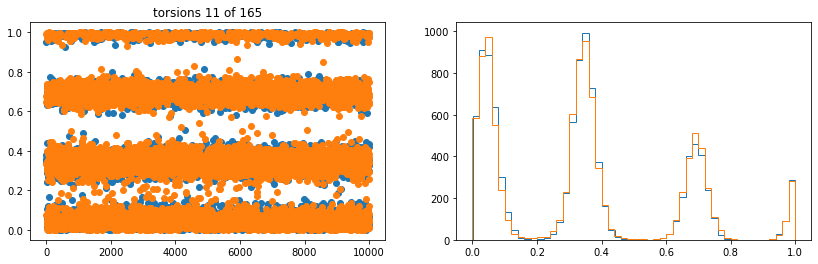

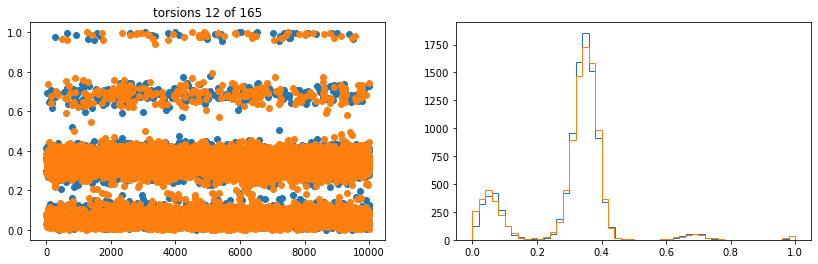

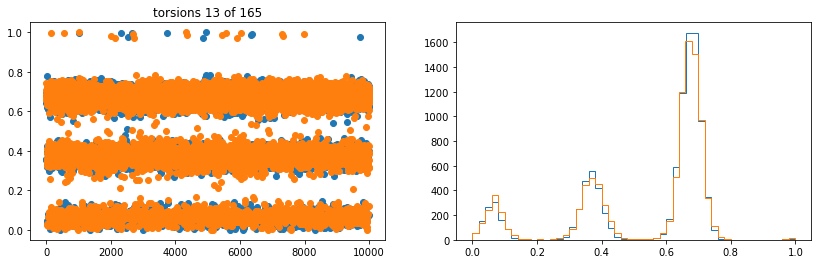

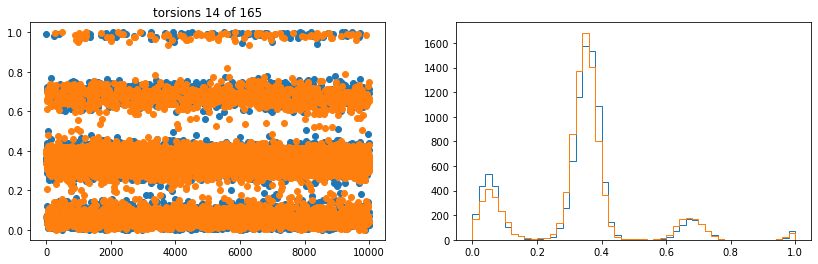

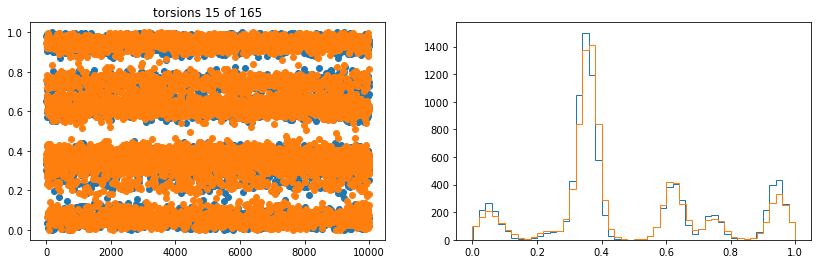

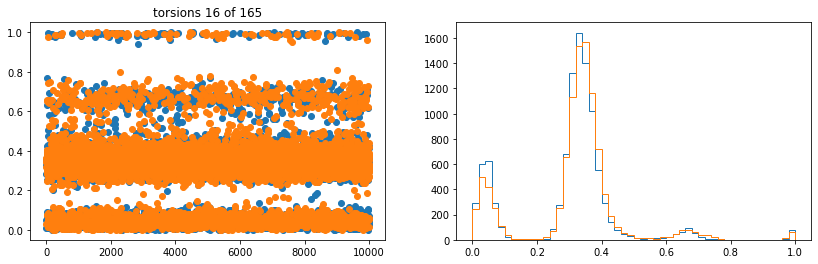

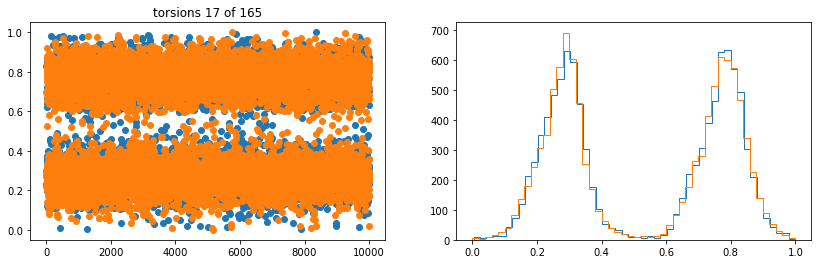

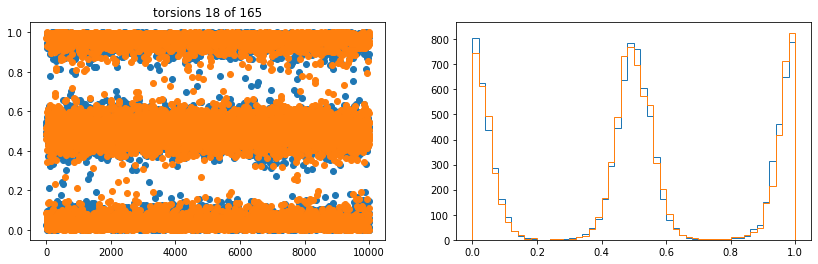

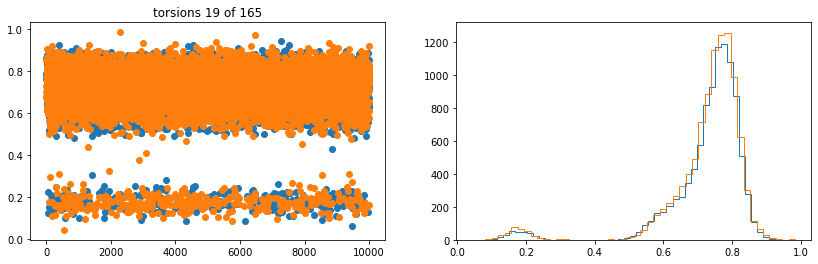

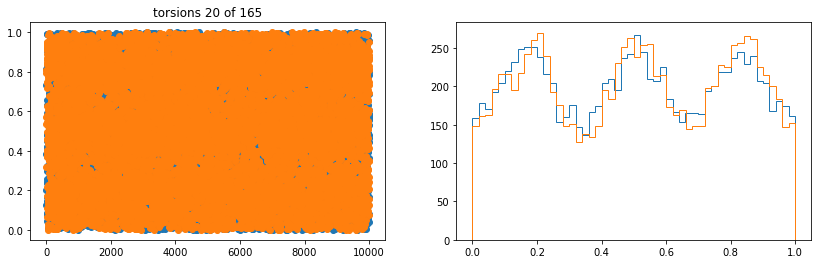

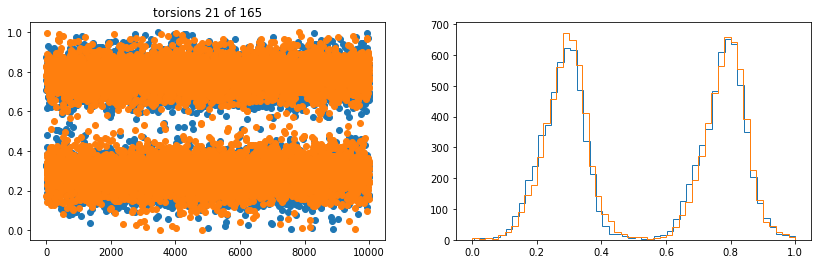

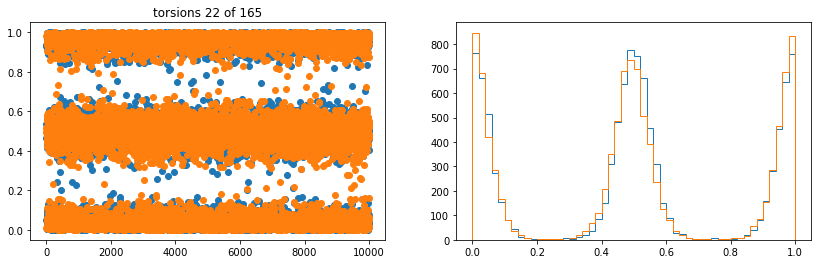

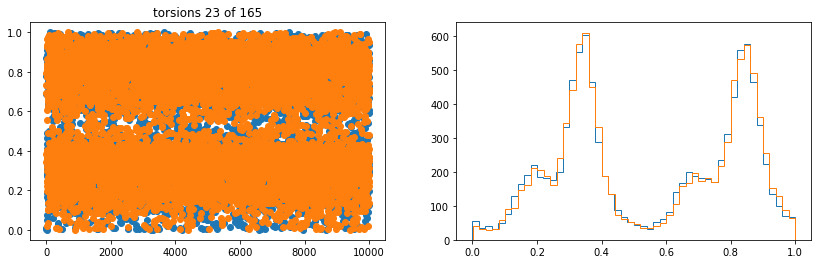

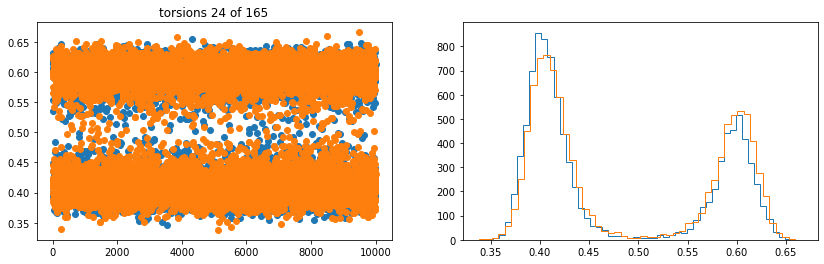

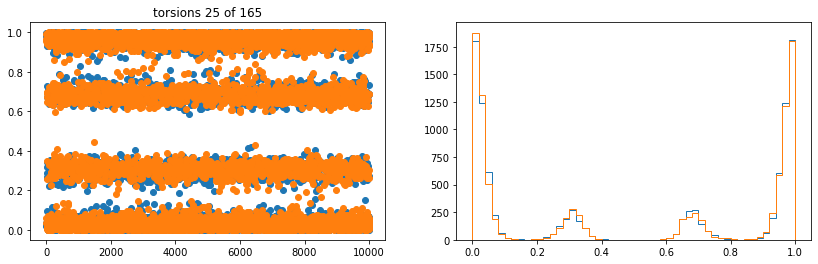

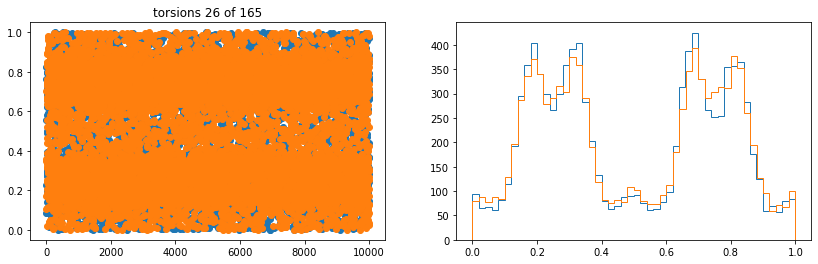

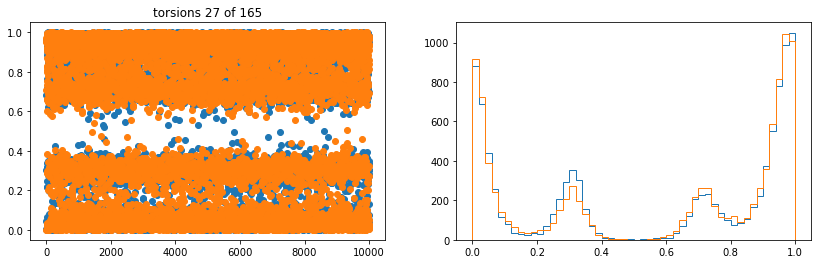

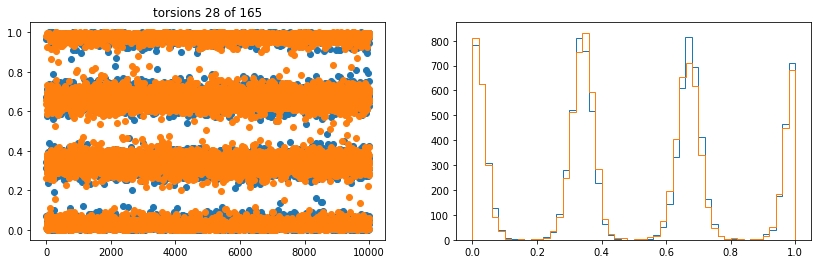

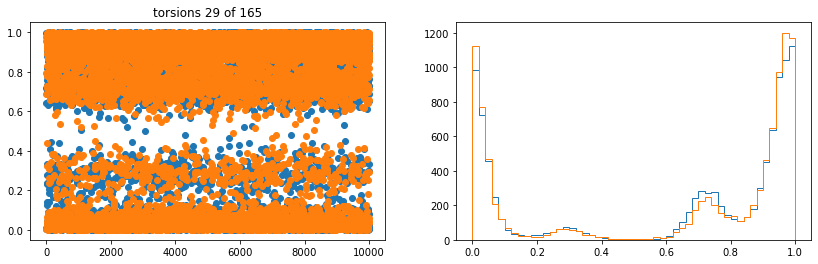

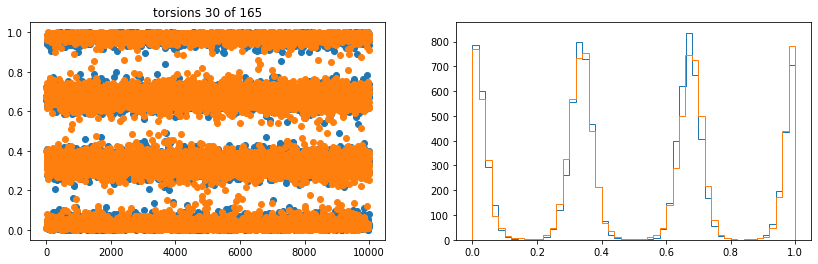

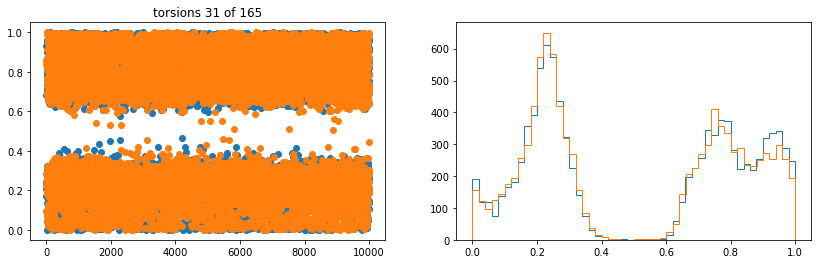

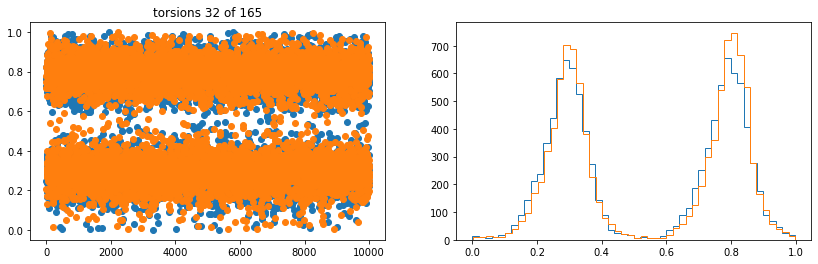

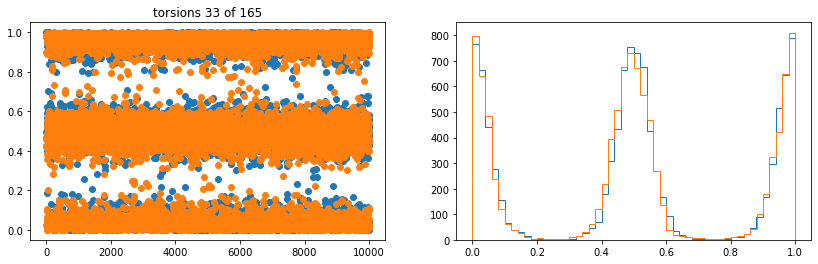

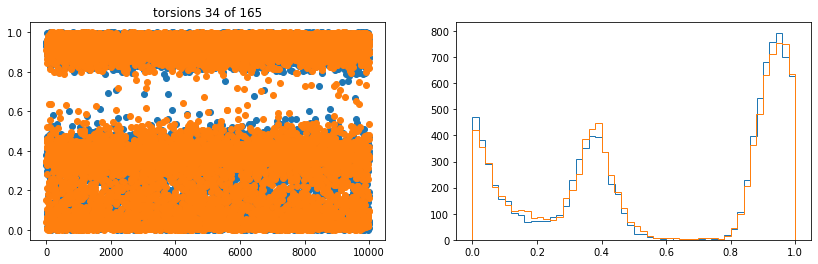

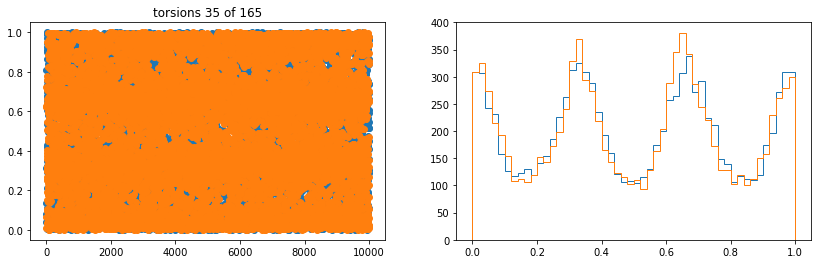

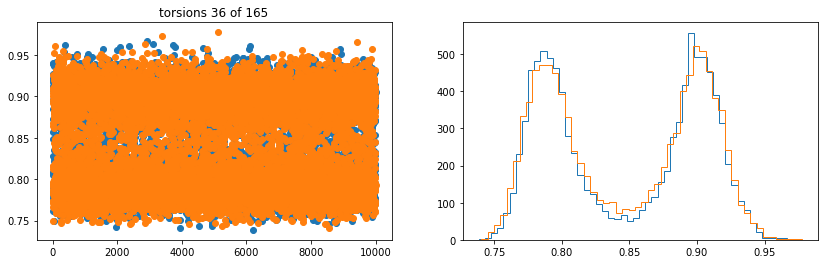

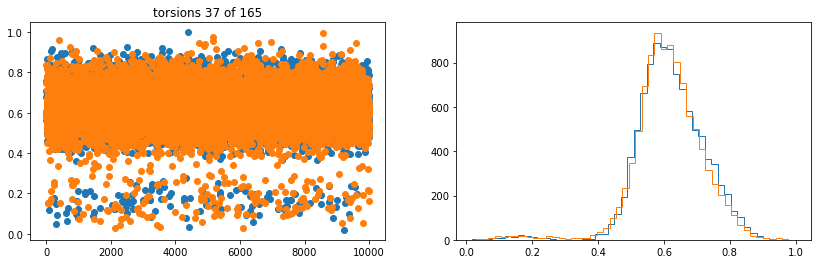

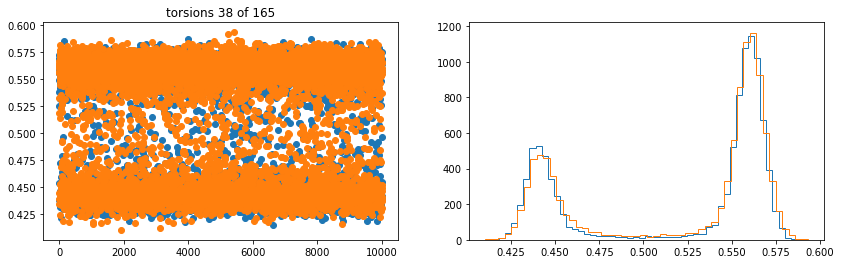

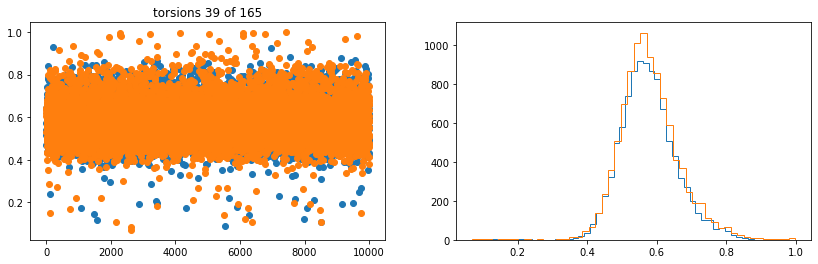

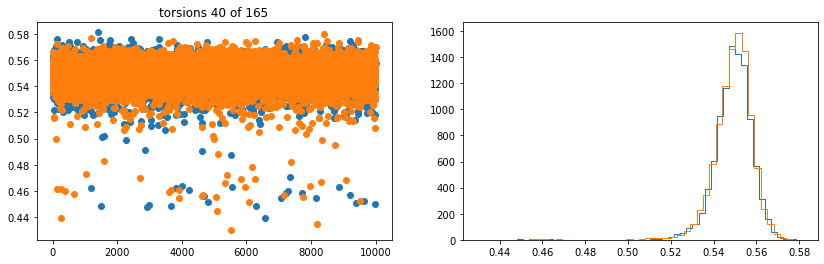

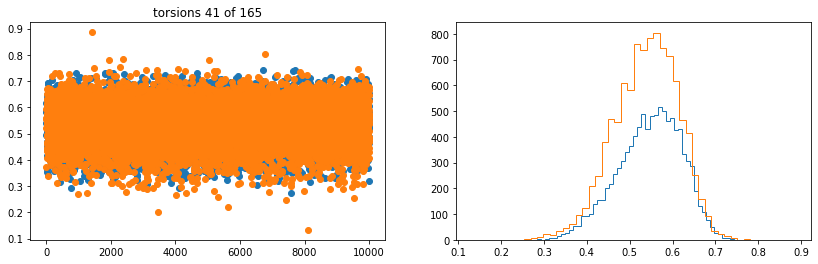

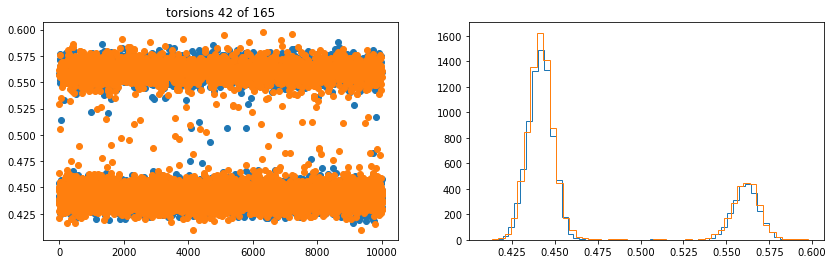

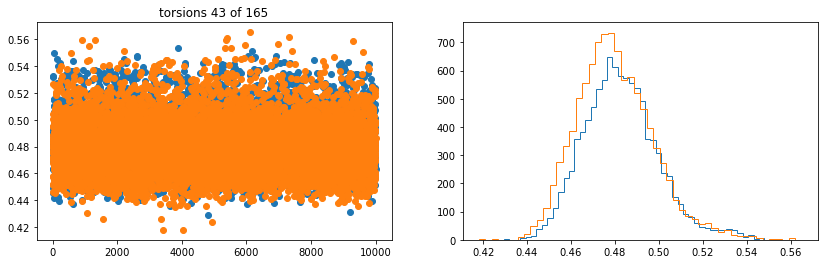

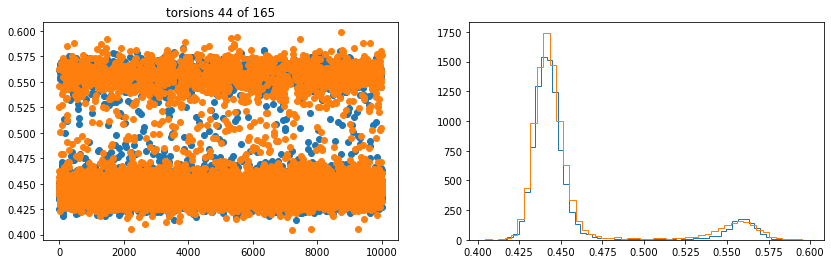

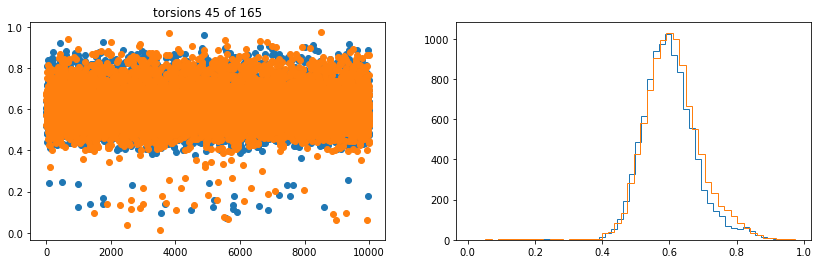

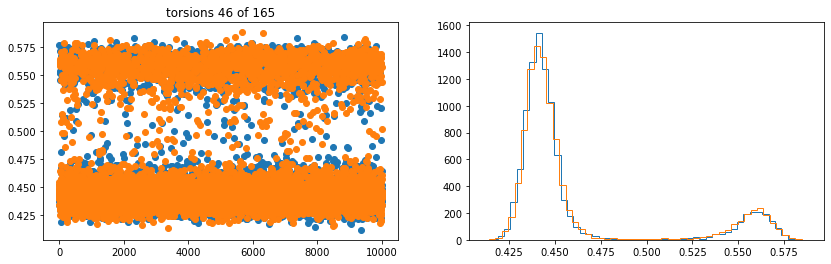

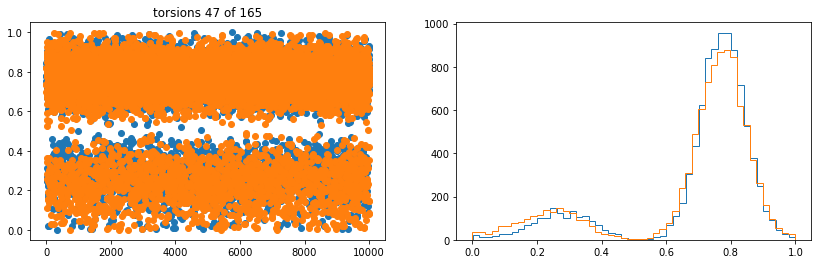

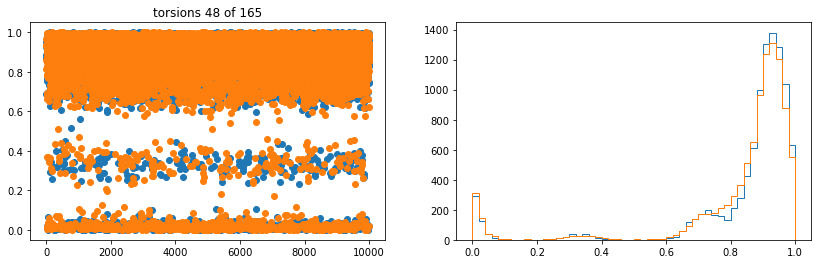

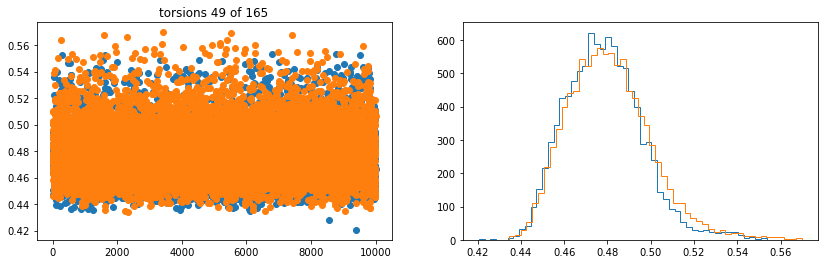

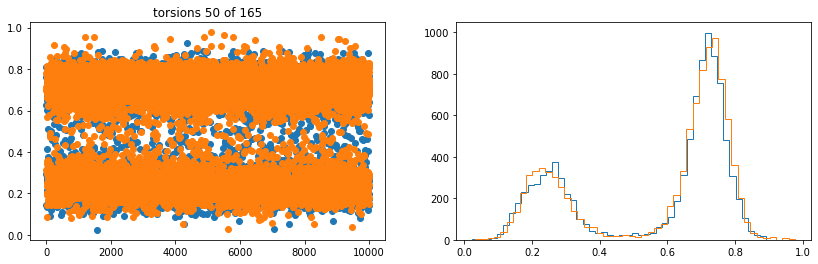

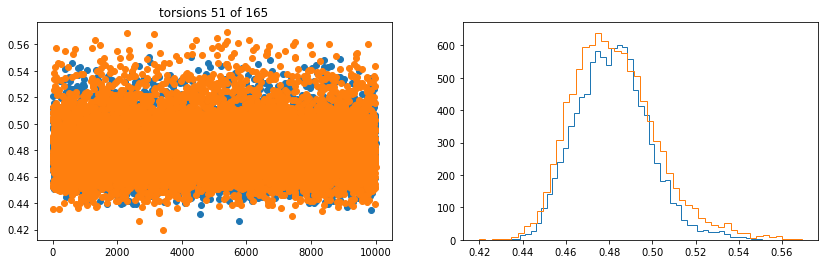

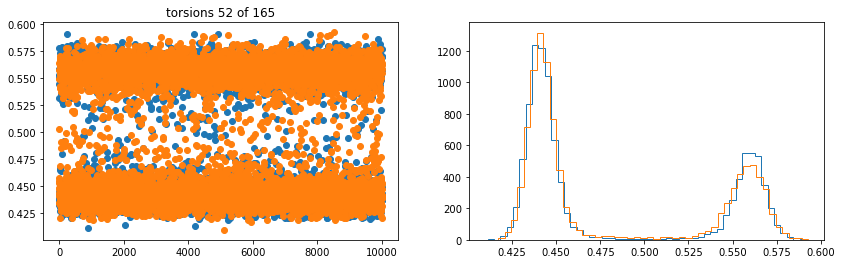

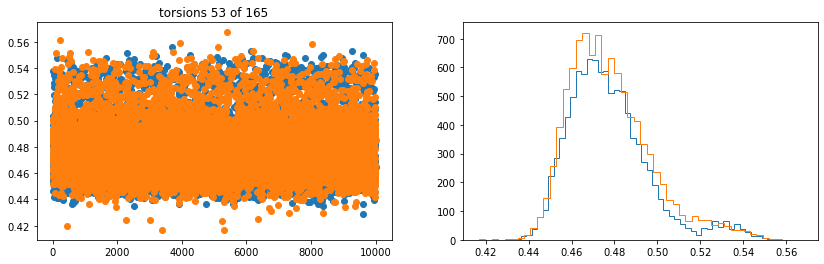

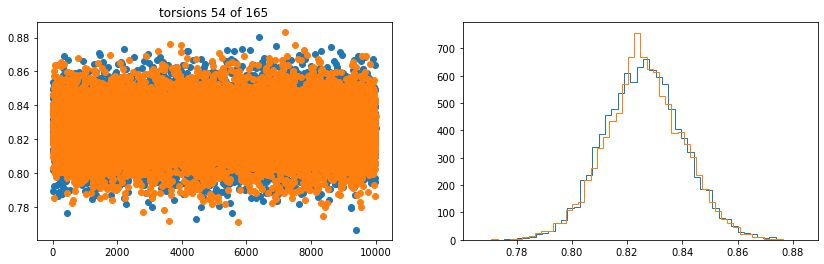

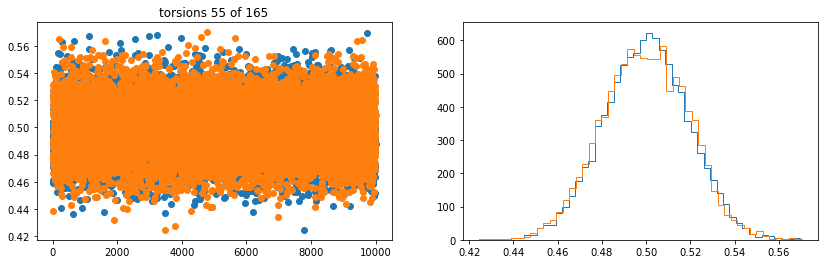

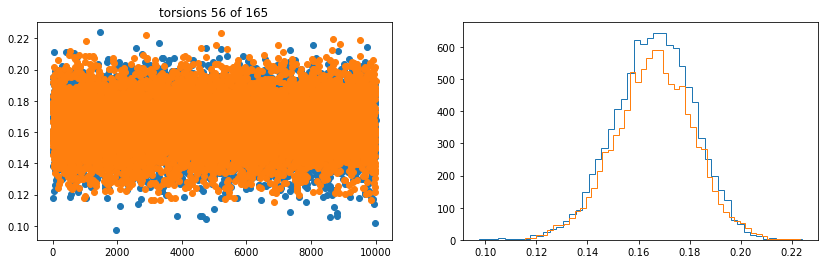

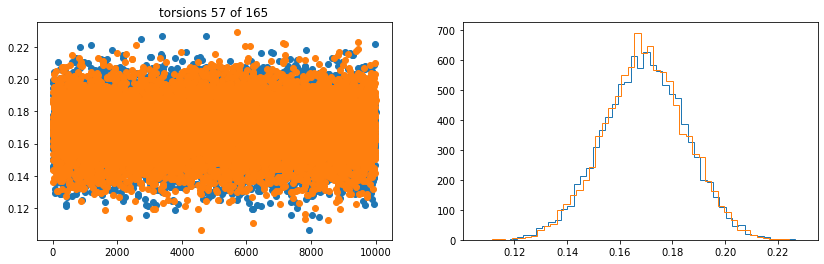

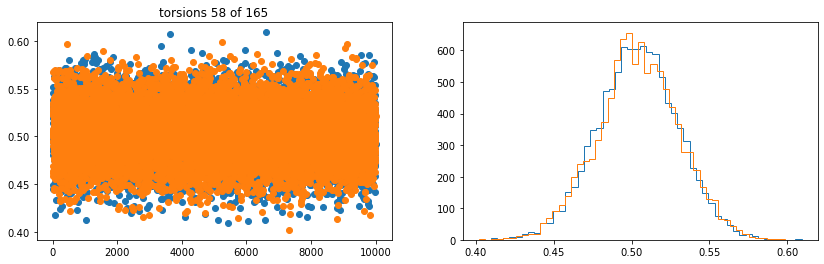

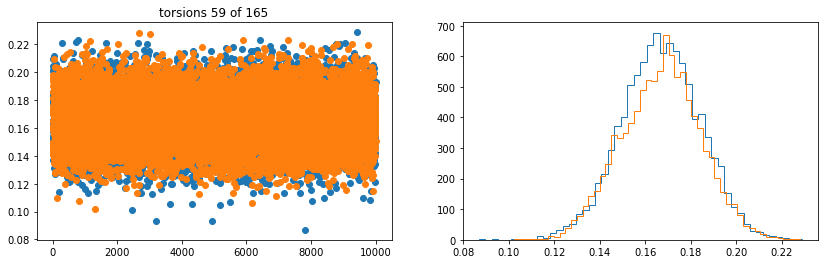

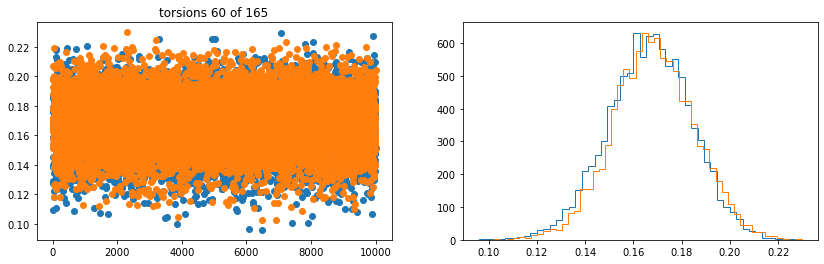

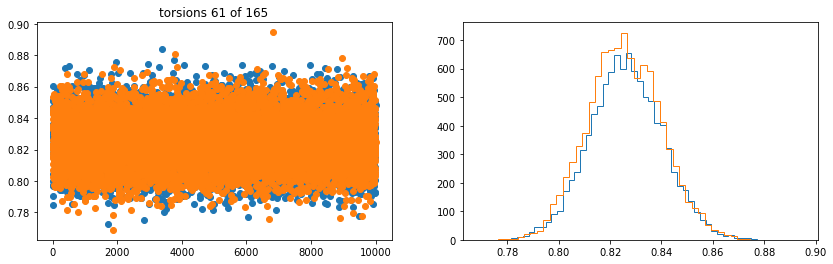

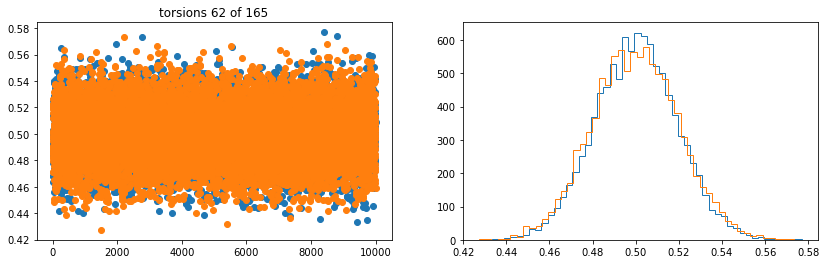

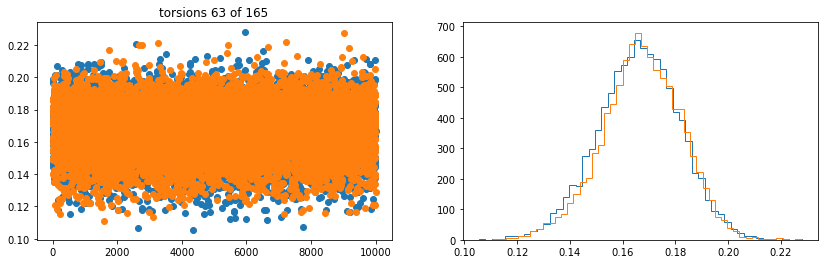

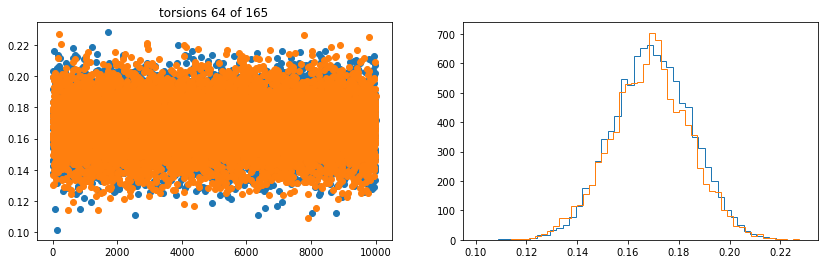

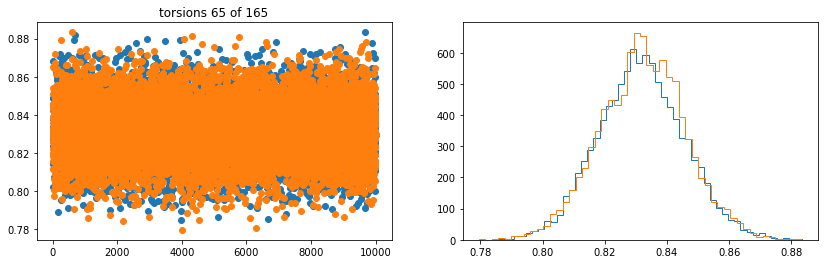

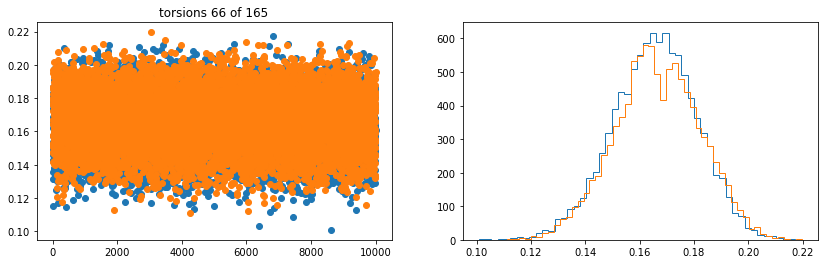

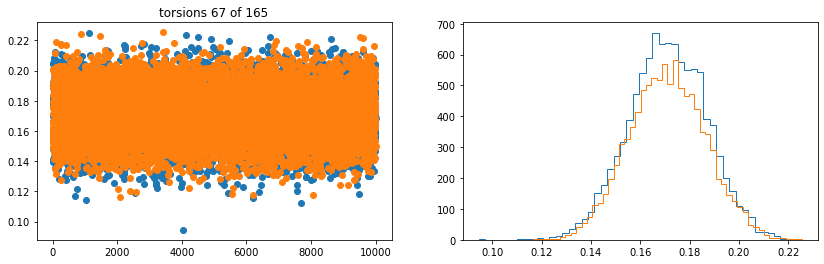

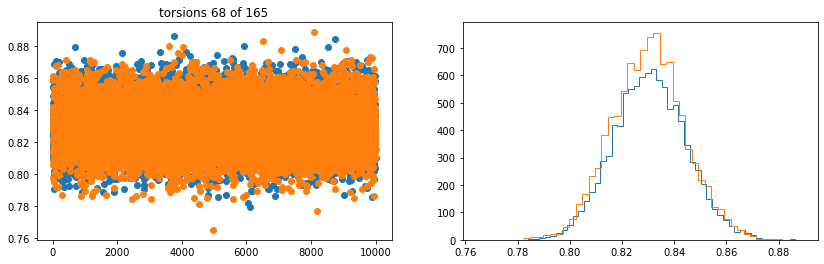

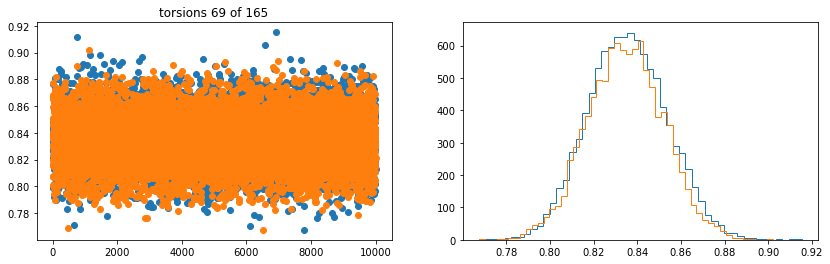

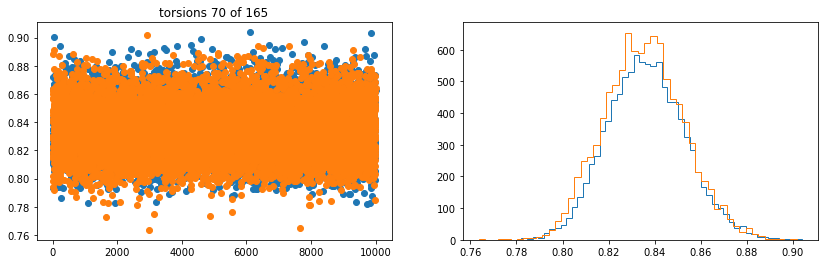

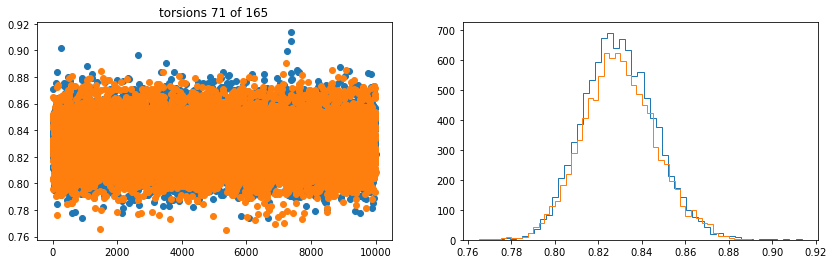

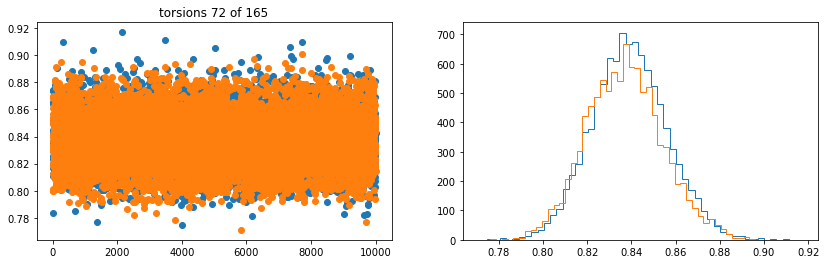

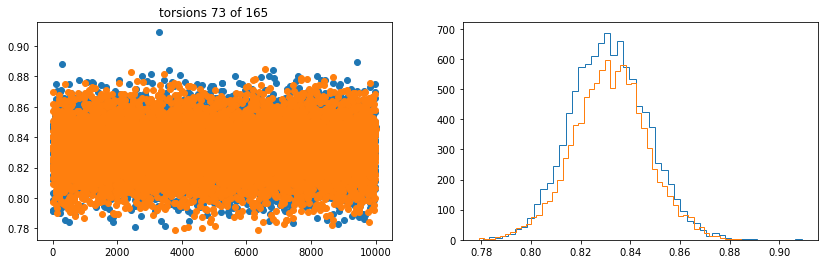

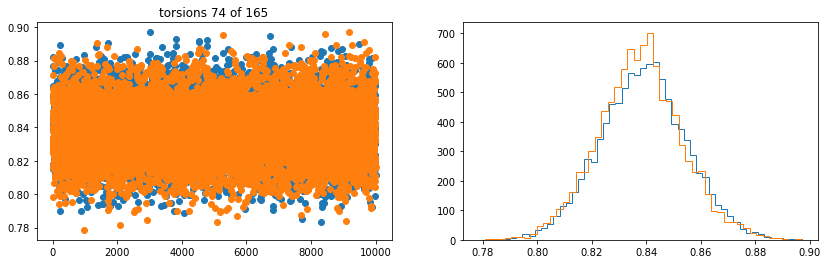

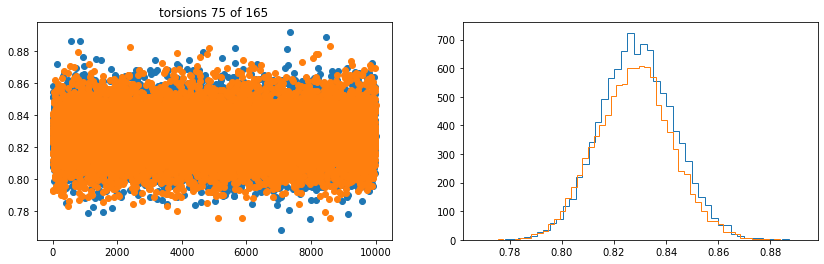

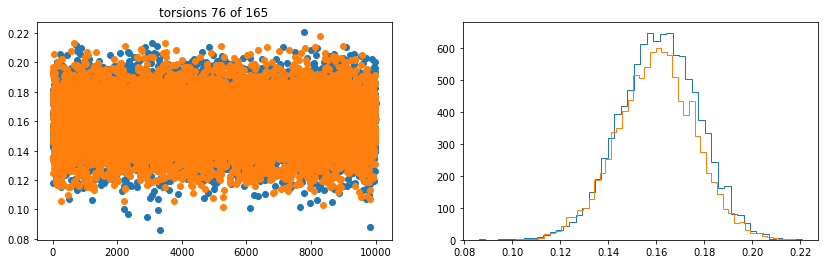

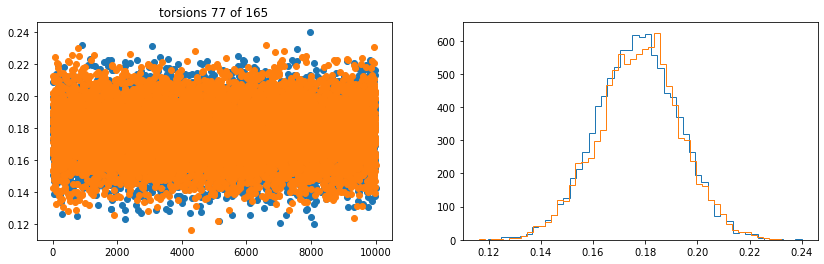

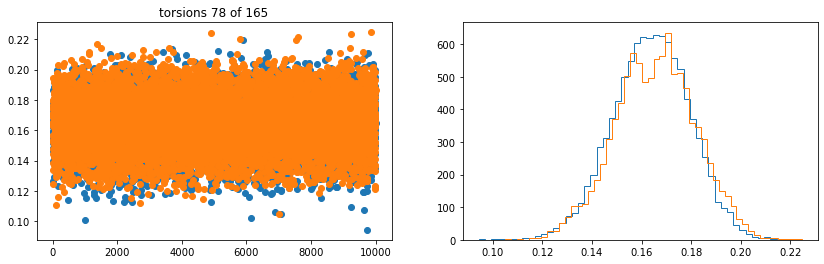

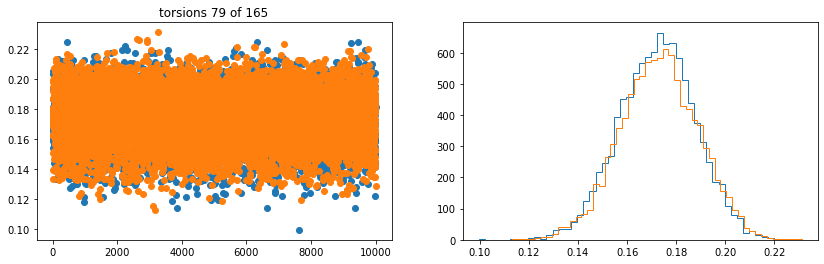

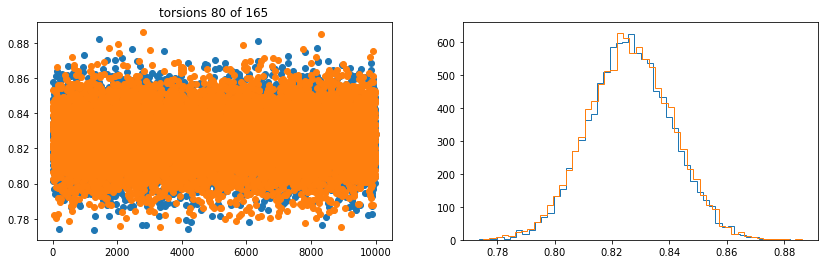

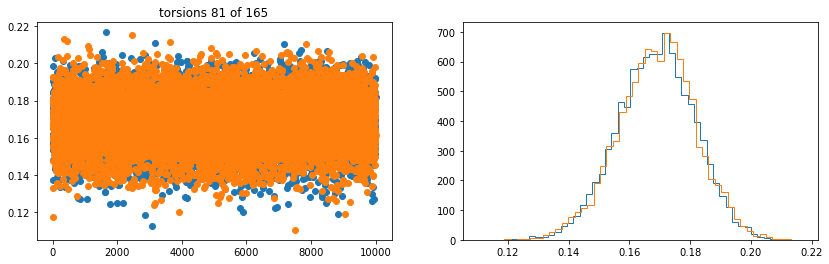

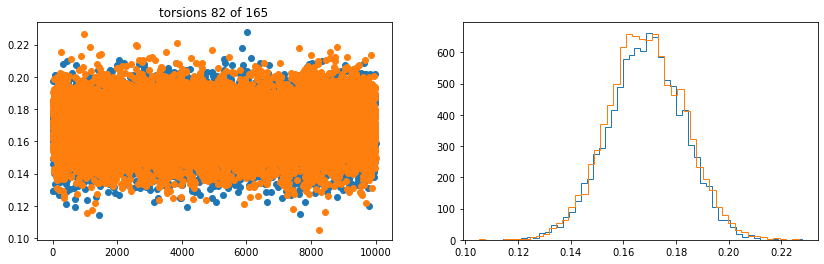

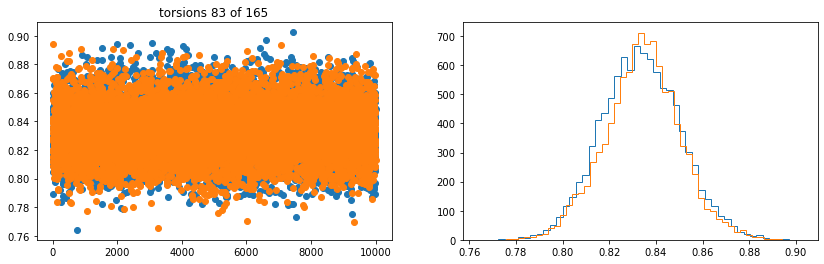

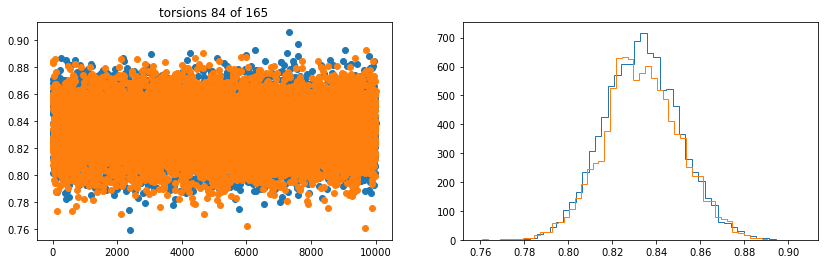

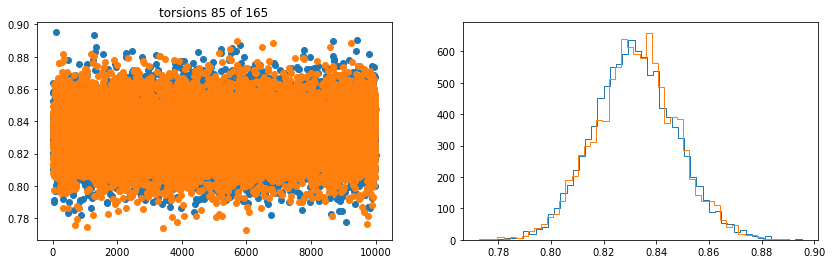

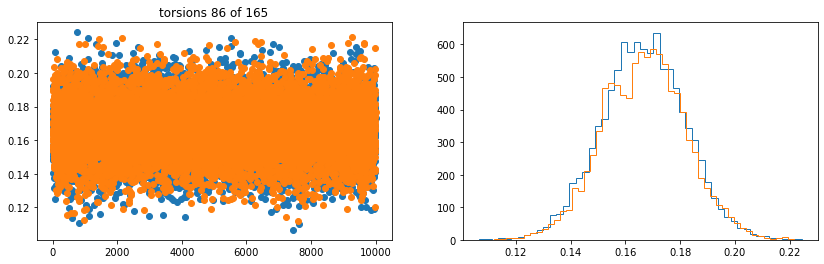

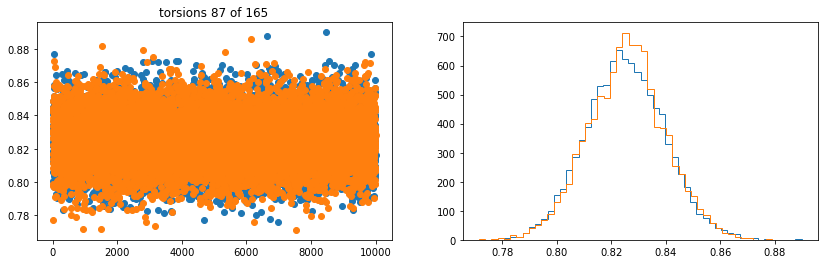

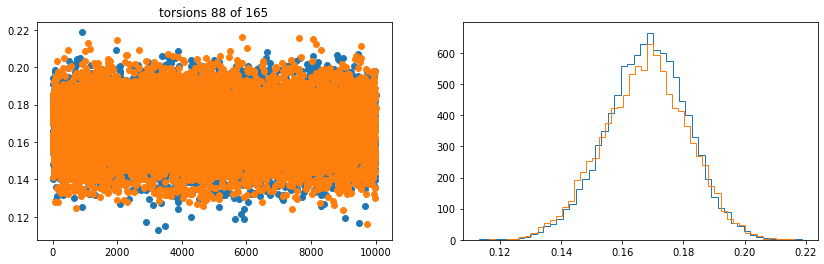

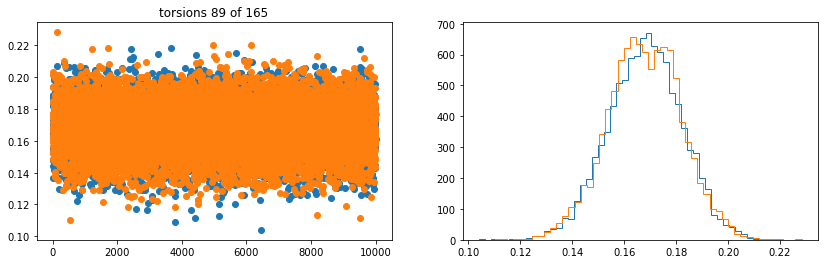

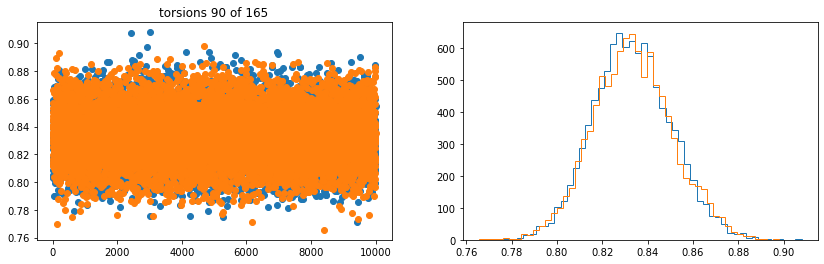

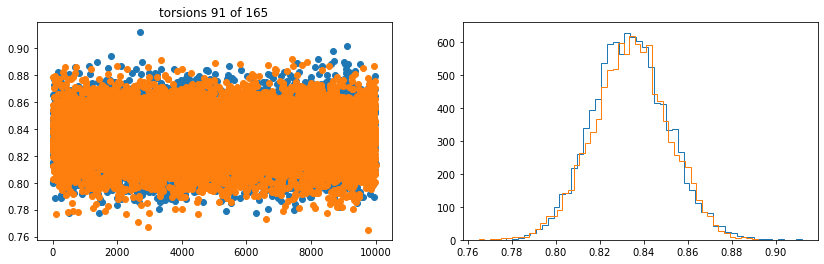

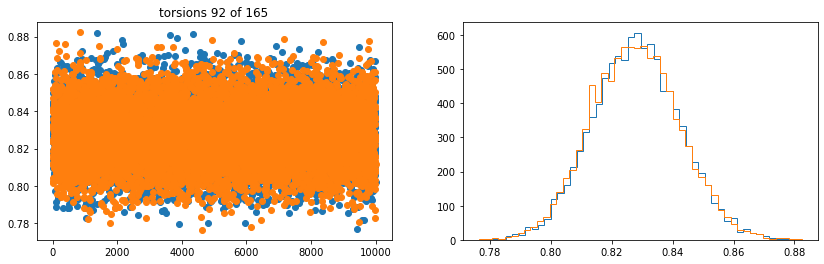

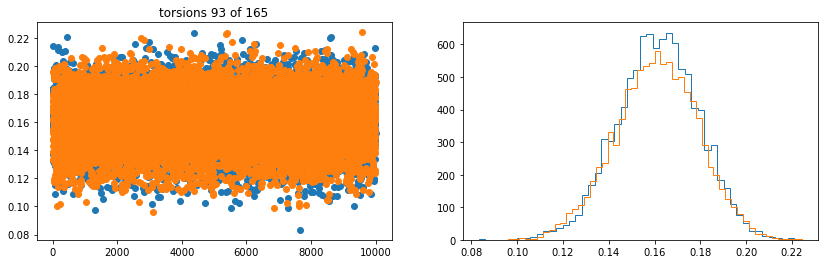

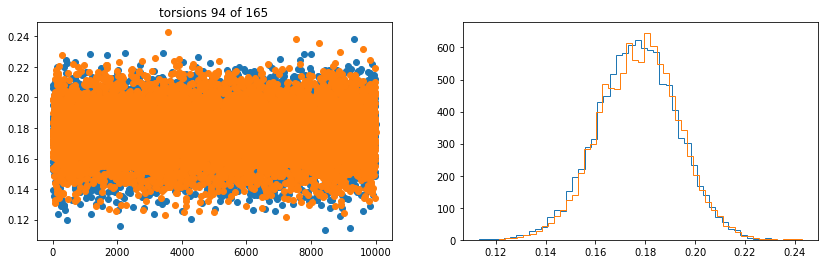

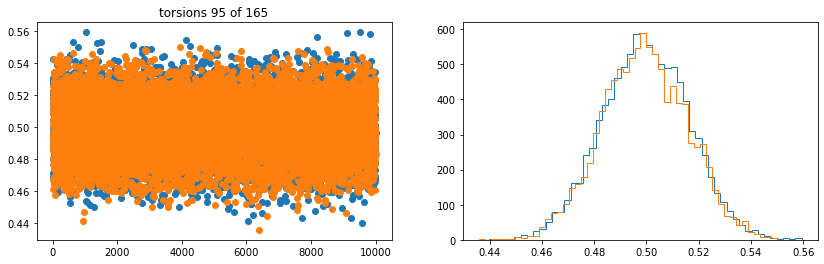

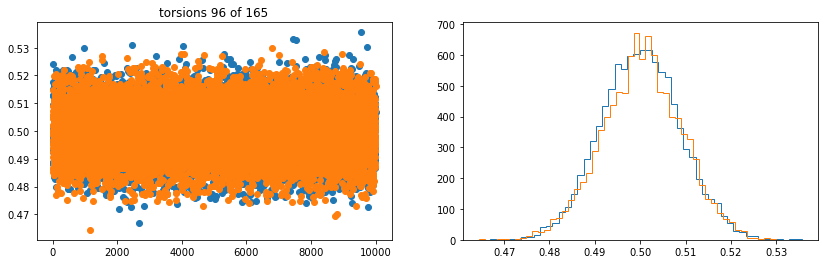

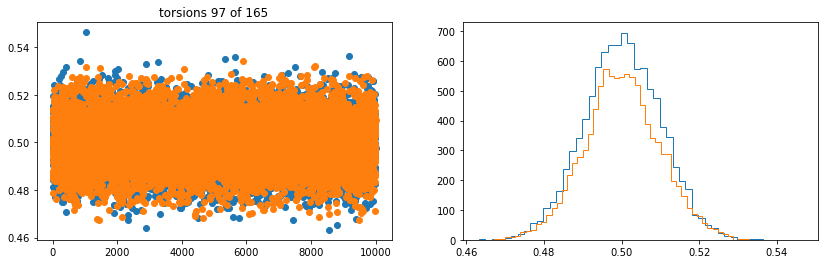

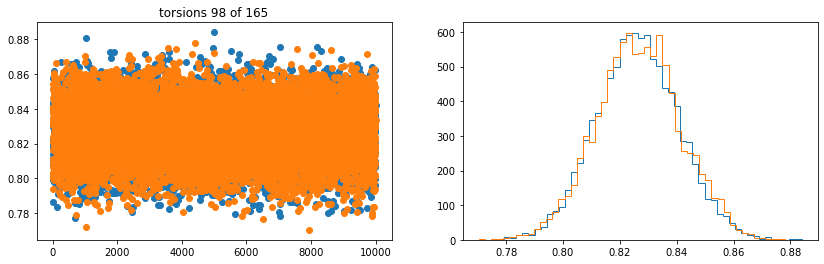

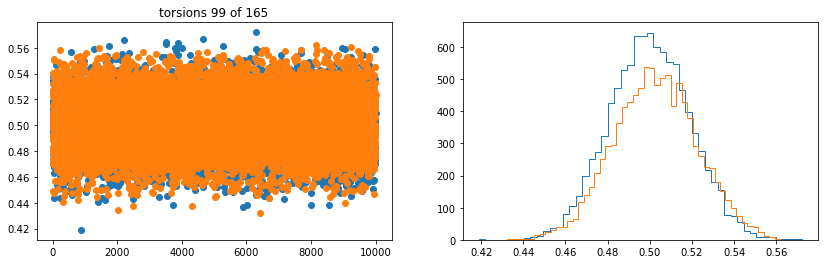

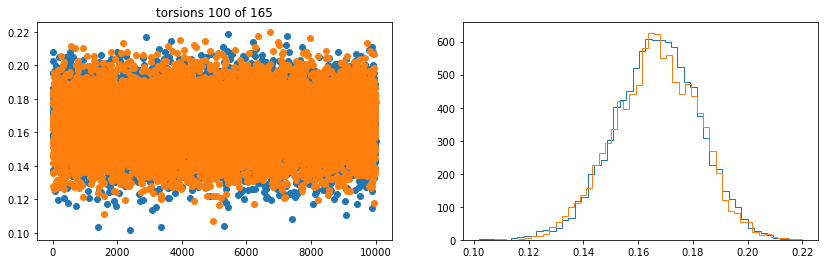

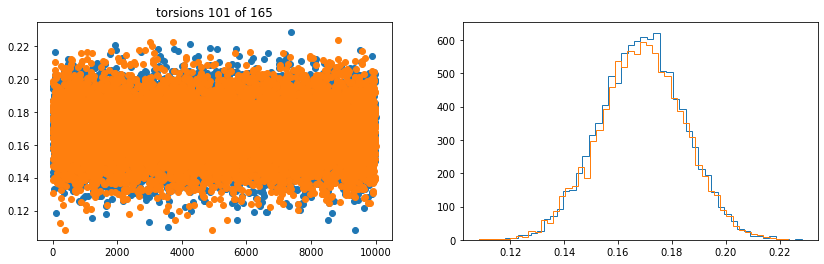

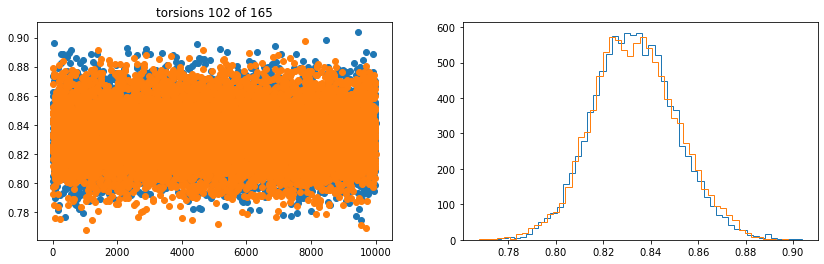

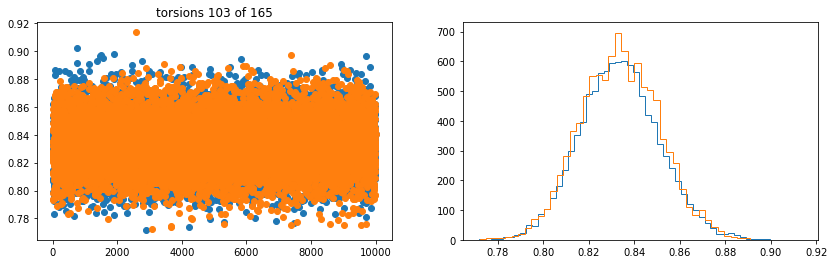

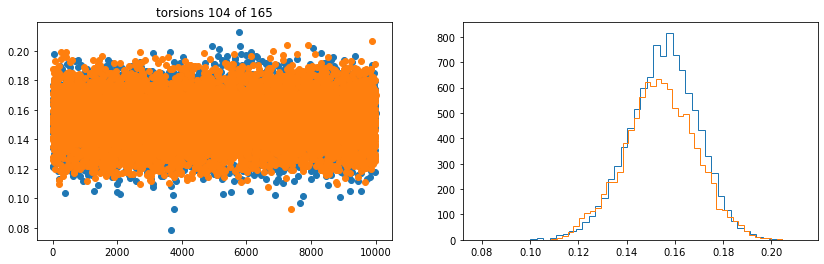

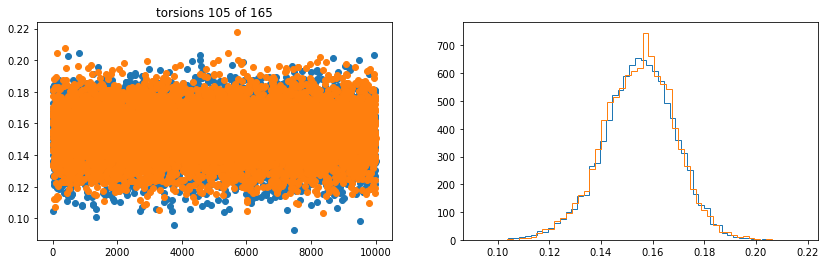

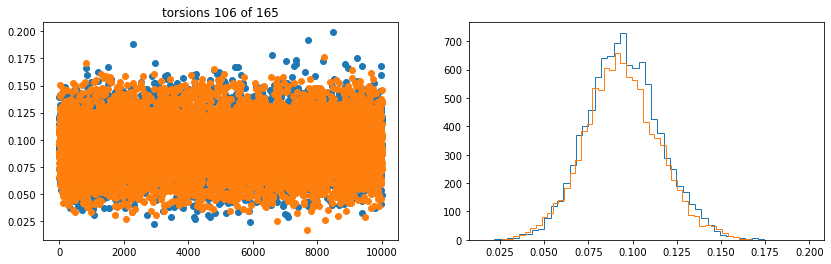

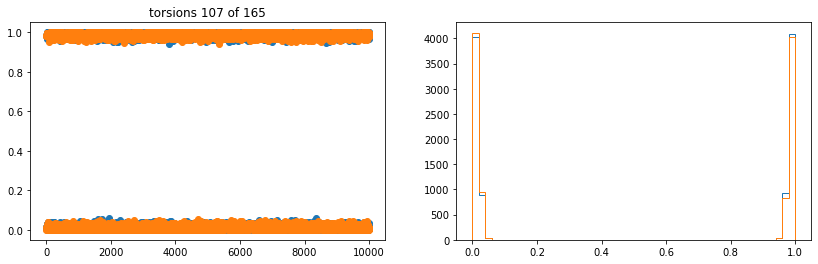

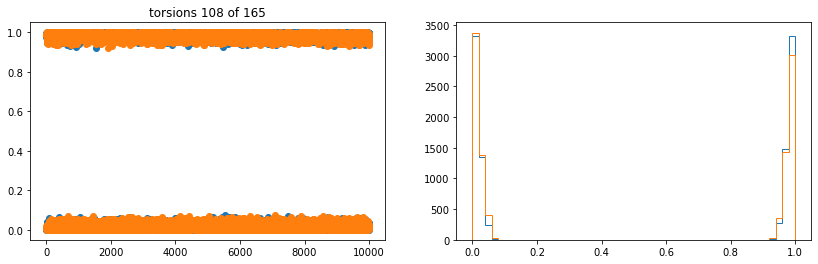

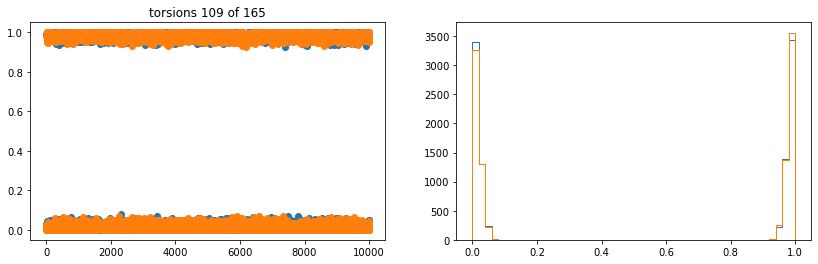

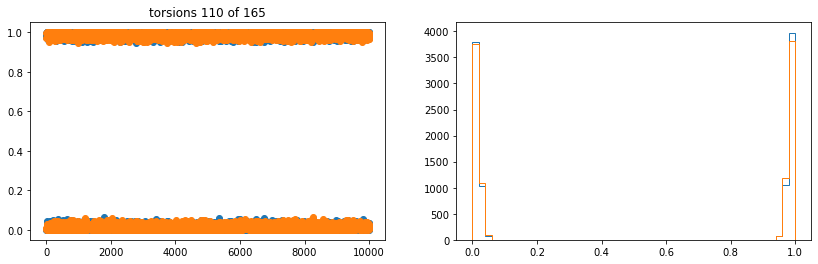

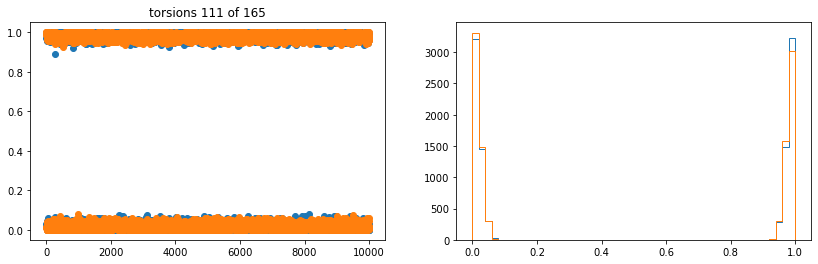

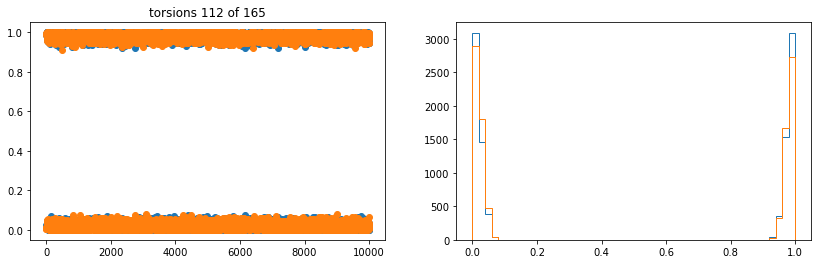

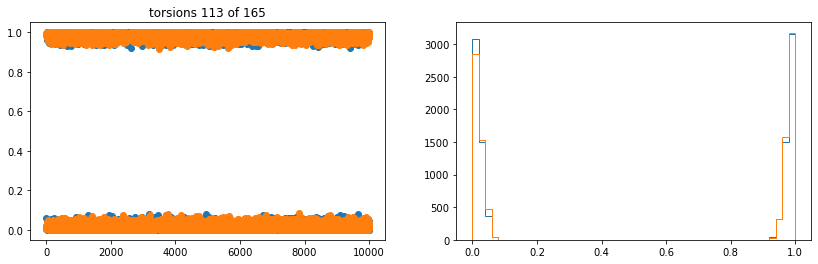

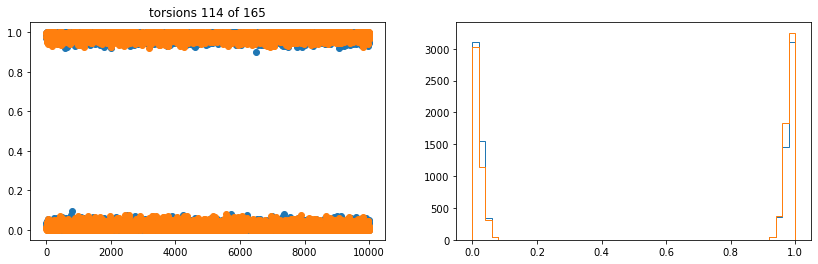

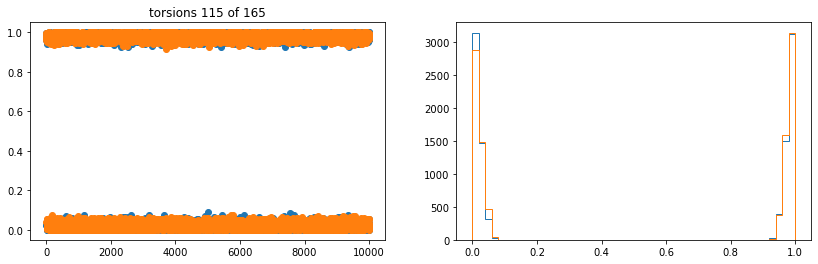

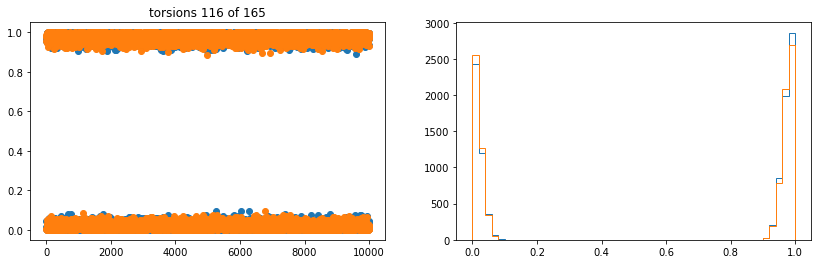

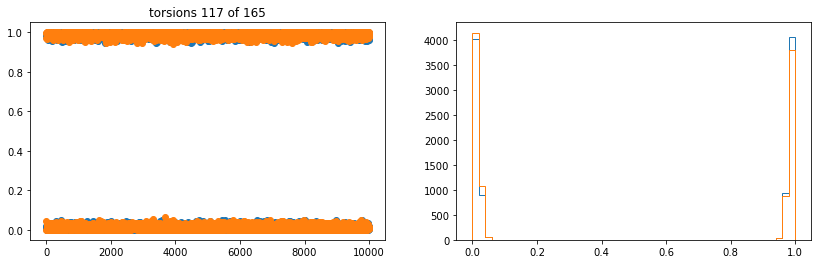

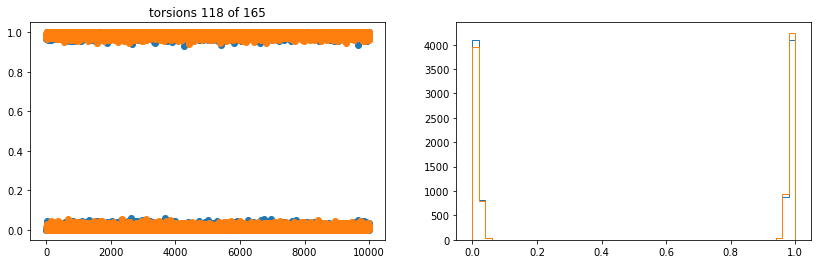

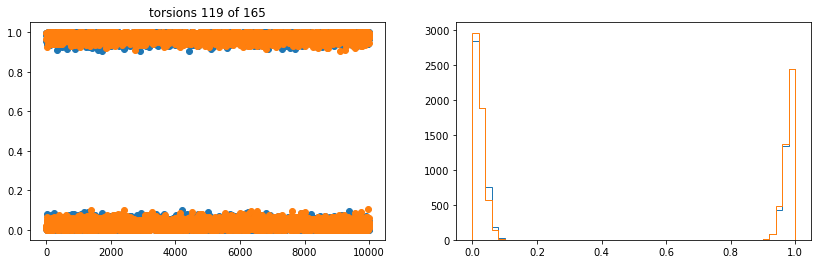

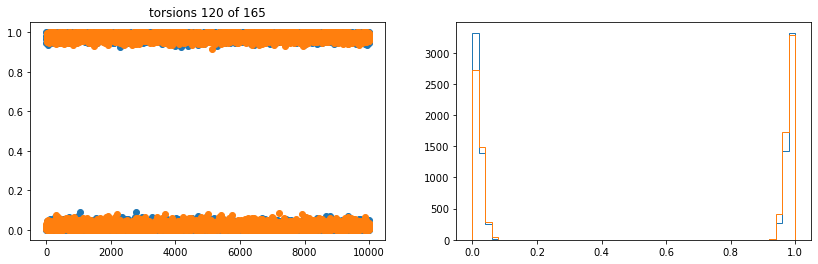

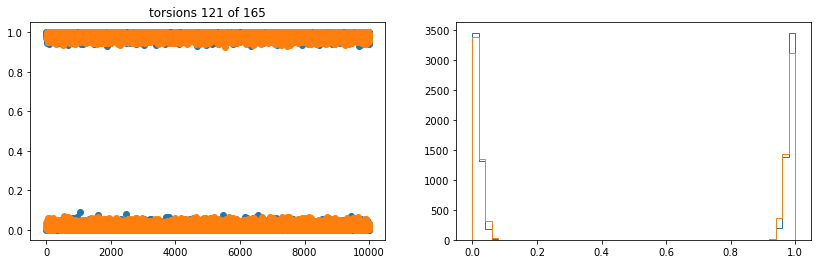

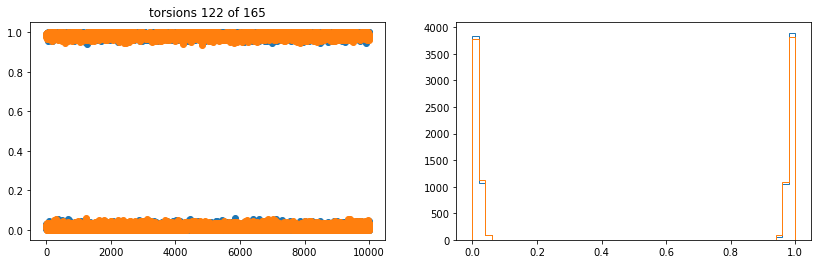

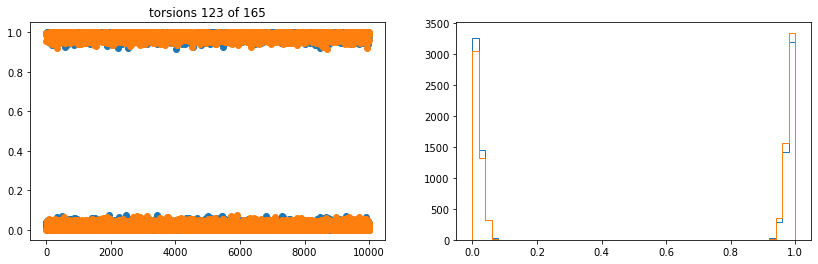

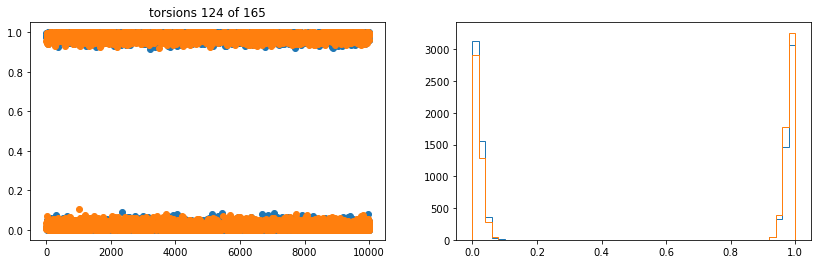

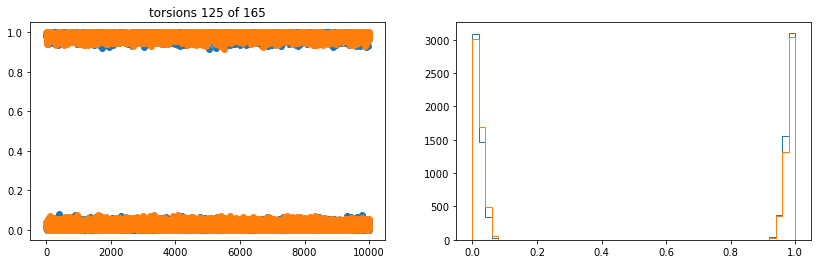

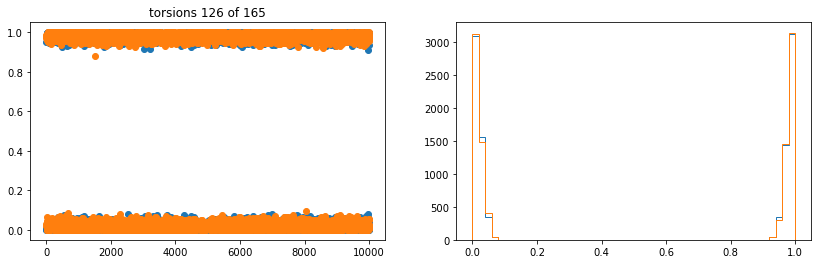

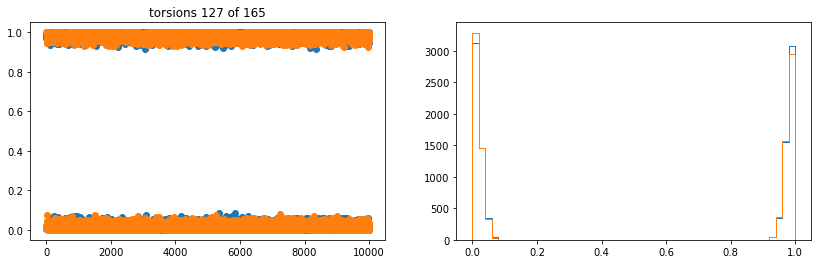

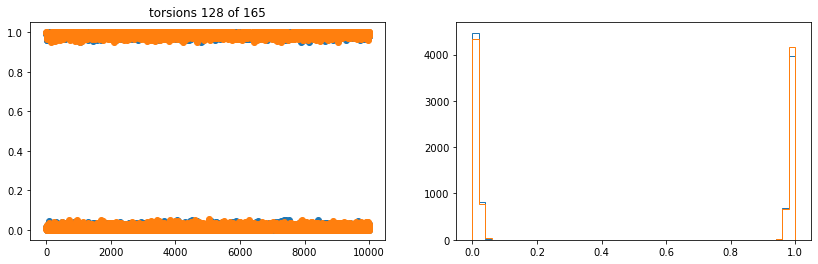

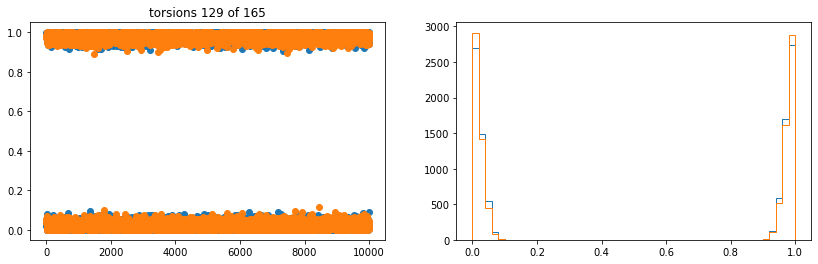

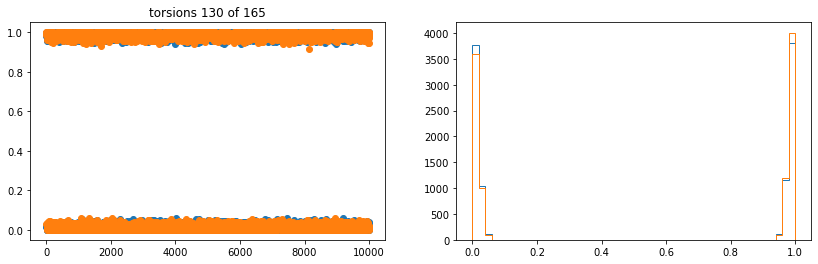

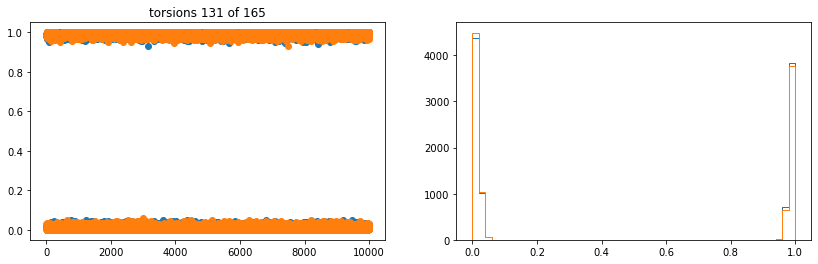

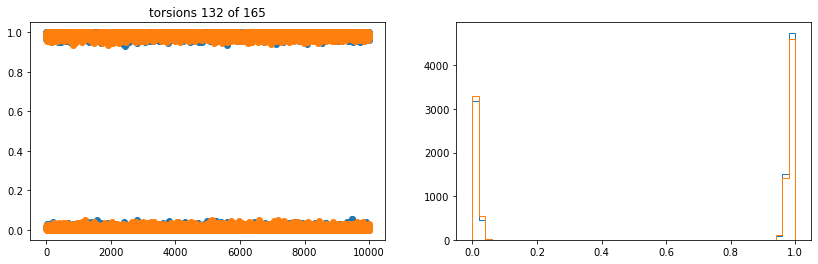

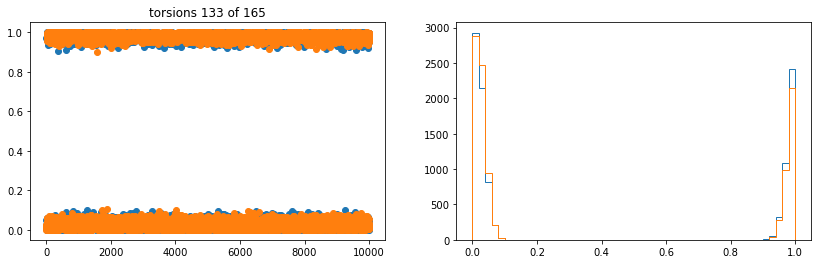

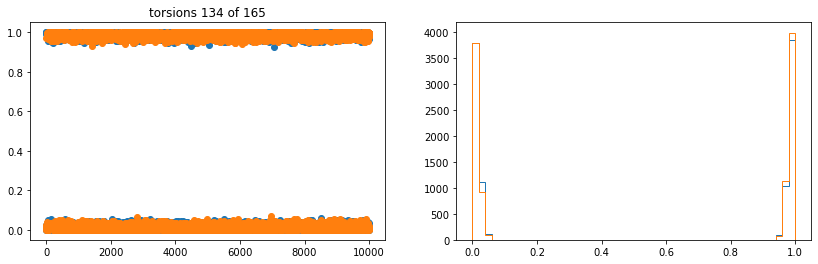

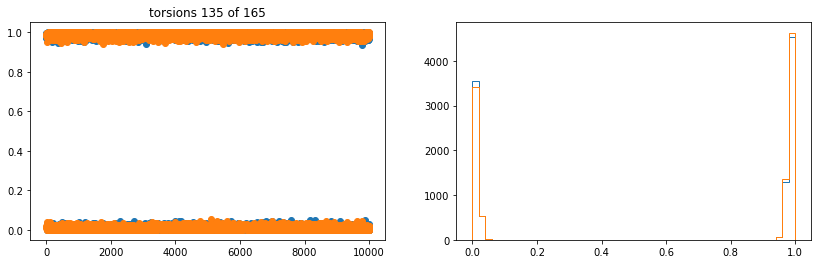

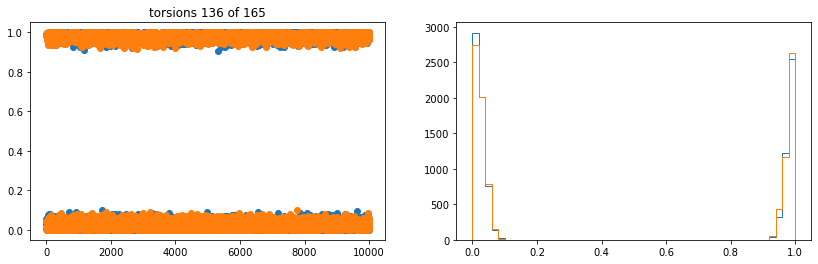

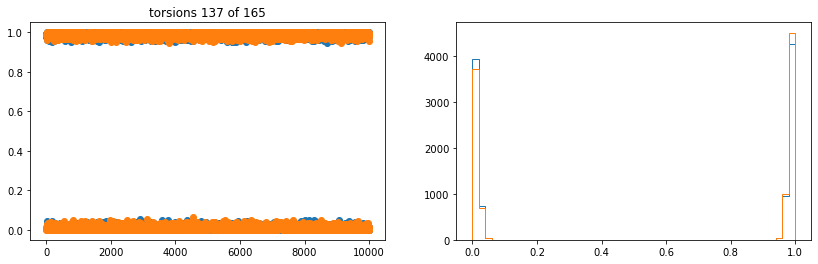

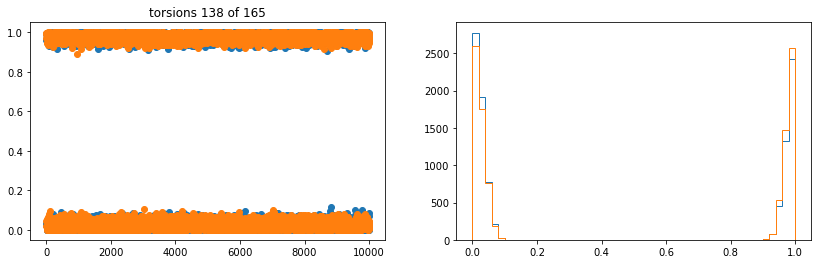

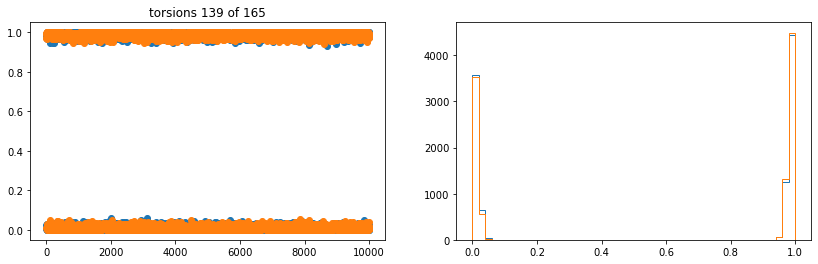

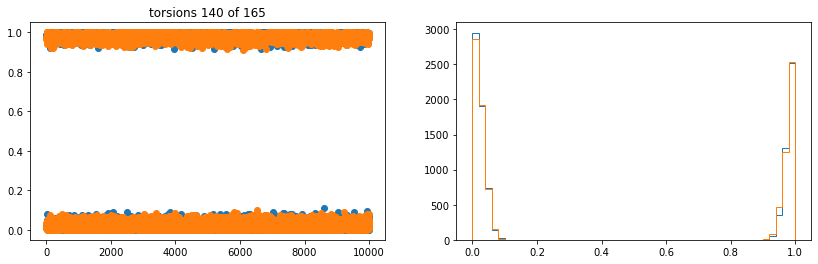

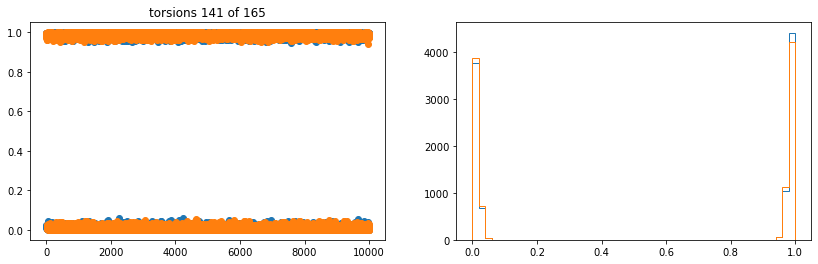

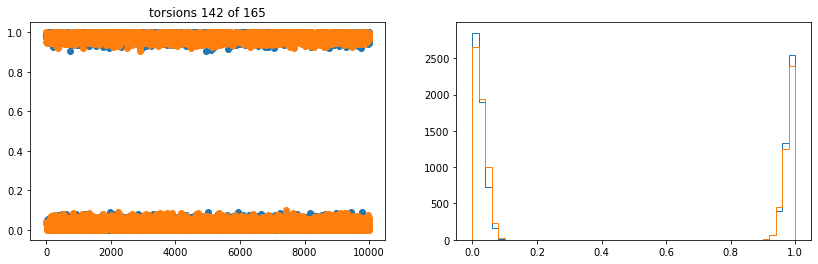

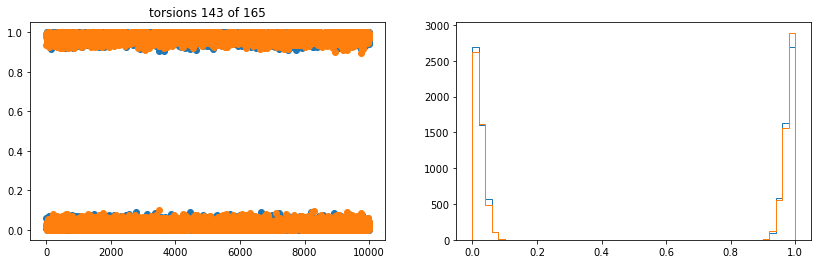

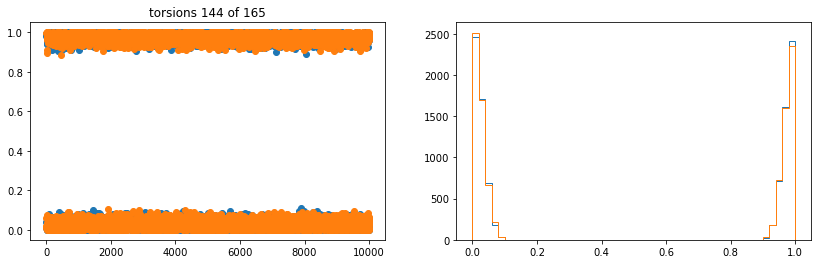

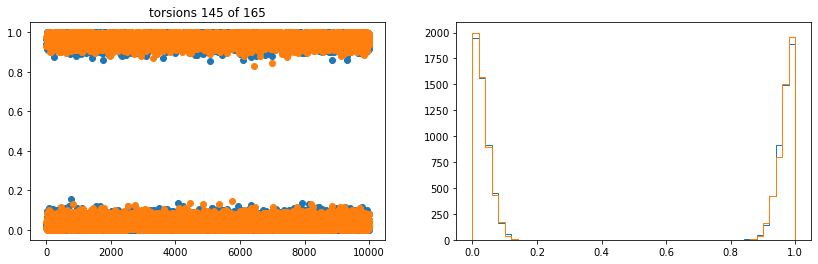

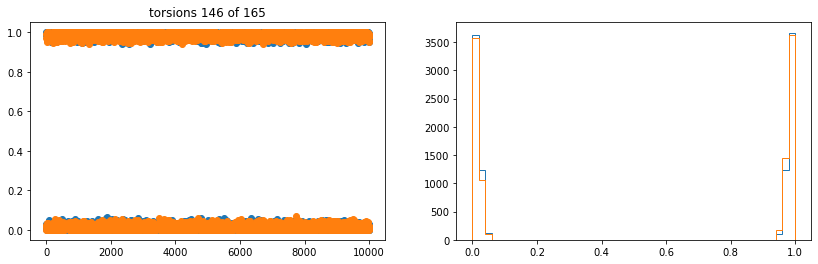

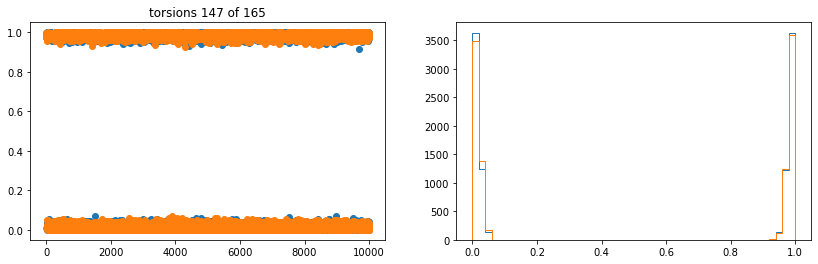

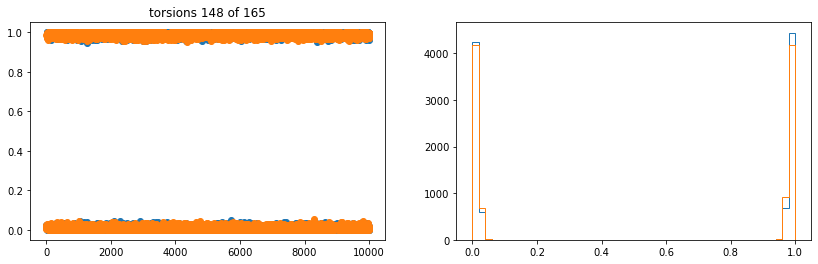

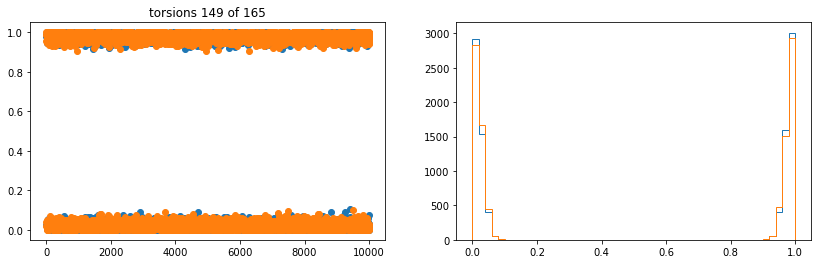

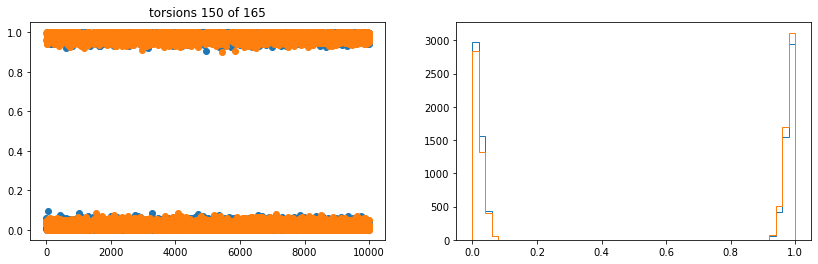

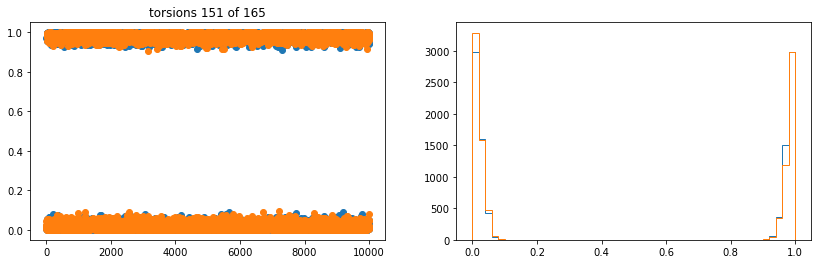

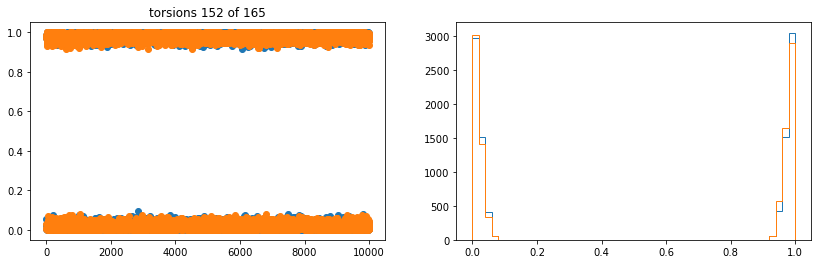

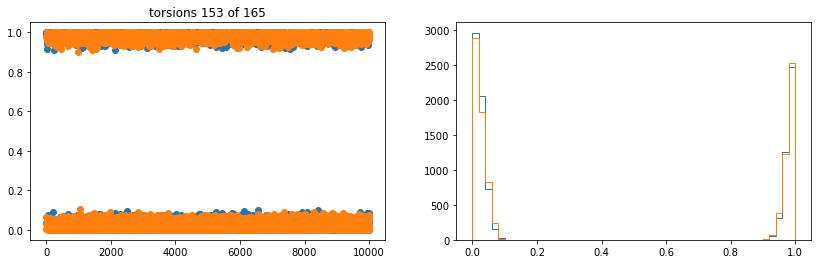

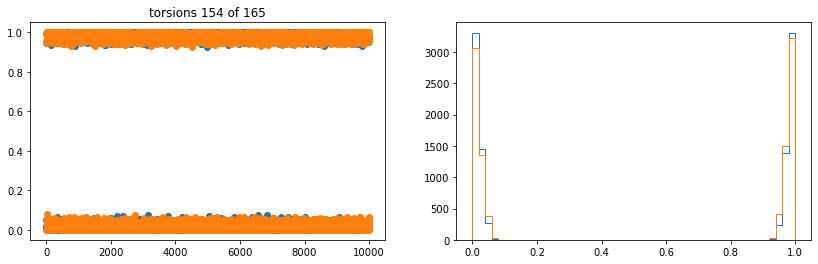

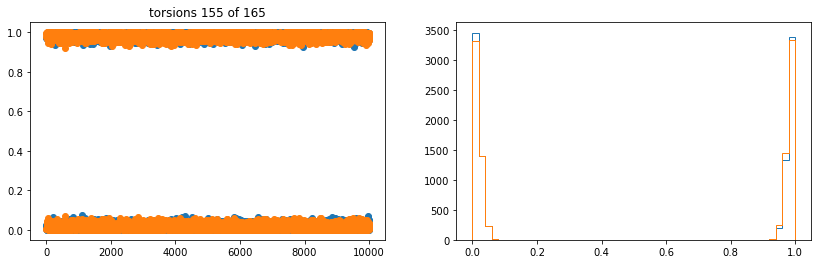

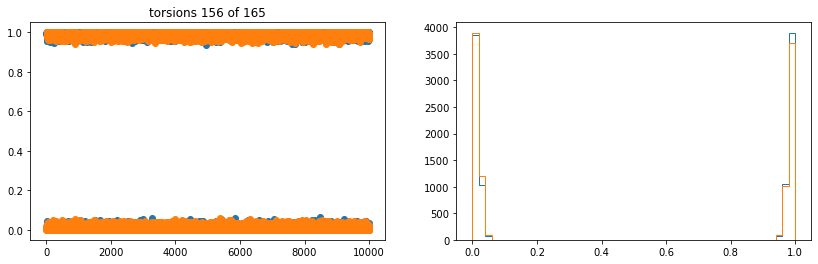

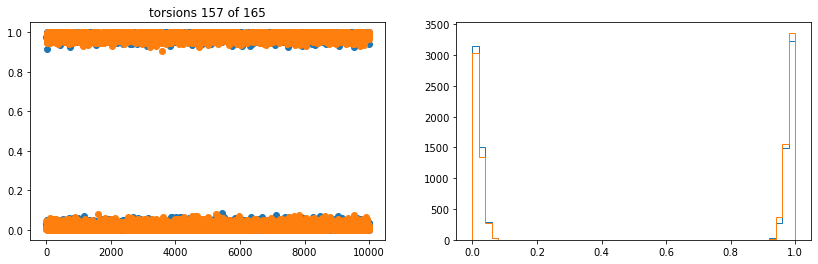

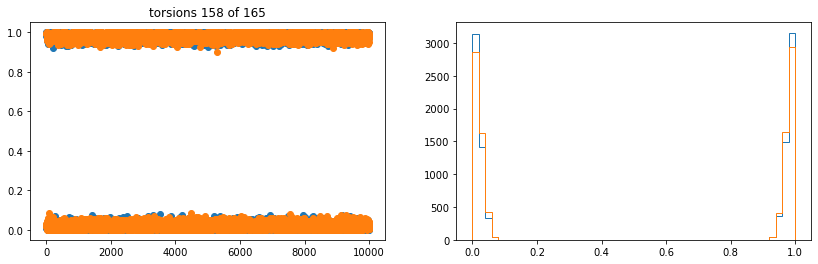

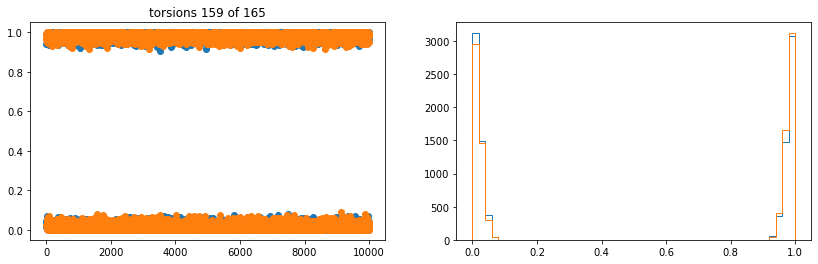

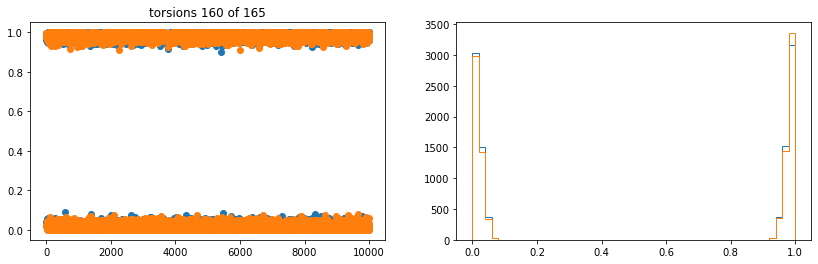

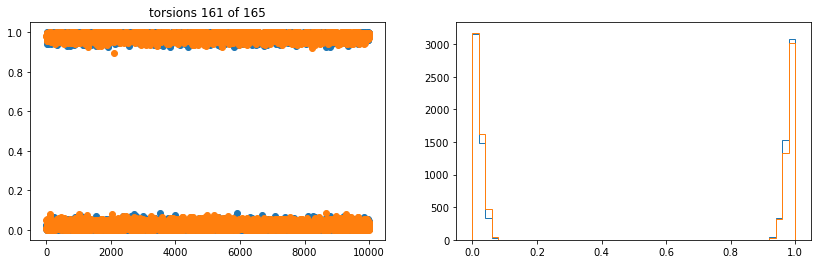

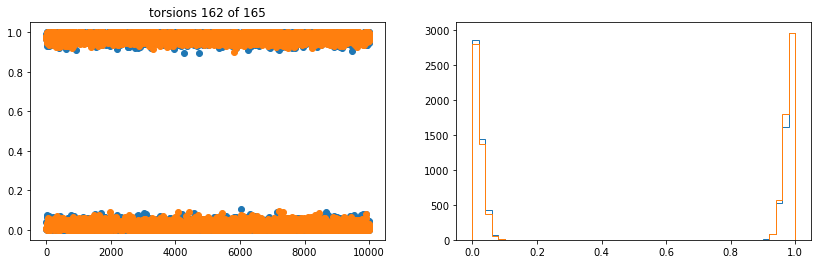

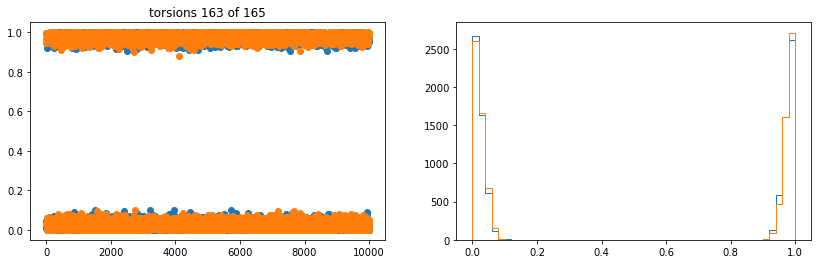

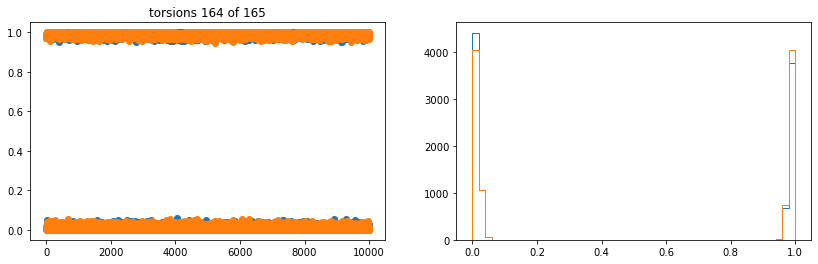

In [102]:
from bgflow.utils.types import assert_numpy

def plot_ics(name, data, data2=None, chosen=None):
    data = assert_numpy(data)
    if data2 is not None:
        data2 = assert_numpy(data2)
    if chosen is None:
        chosen = np.random.choice(range(len(data[0,:])))
    plt.figure(figsize=(14, 4))
    plt.subplot(1,2,1)
    plt.title(name+' %d of %d'%(chosen, len(data[0,:])))
    plt.plot(data[:,chosen], 'o')
    if data2 is not None:
        plt.plot(data2[:,chosen], 'o')
    plt.subplot(1,2,2)
    plt.hist(data[:,chosen], bins=50, histtype='step')
    if data2 is not None:
        plt.hist(data2[:,chosen], bins=50, histtype='step')
    plt.show()

with torch.no_grad():
    ics_t = coordinate_transform.forward(training_data[:n_samples].to(**ctx))
    ics_m = coordinate_transform.forward(torch.Tensor(samples).to(**ctx))
    # ics_m = generator.prior.sample(n_samples)
    l = 2
    title = ['bonds', 'angles', 'torsions', 'fixed', '???', 'dlogp']
    for i in range(ics_t[l].shape[1]):
        plot_ics(title[l], ics_t[l], data2=ics_m[l], chosen=i)
    #del ics_t, ics_m

In [126]:
for k in range(165):
    print()
    print(f"--{k}--")
    for i in z_matrix[k]:
        print(system.mdtraj_topology._atoms[i])
    


--0--
TRP9-CB
TRP9-CA
THR8-CA
TYR10-CA

--1--
TYR1-CB
TYR1-CA
TYR2-CA
ASP3-CA

--2--
TYR10-CB
TYR10-CA
TRP9-CA
THR8-CA

--3--
TYR2-CB
TYR2-CA
TYR1-CA
ASP3-CA

--4--
PRO4-CB
PRO4-CA
ASP3-CA
GLU5-CA

--5--
GLU5-CB
GLU5-CA
PRO4-CA
THR6-CA

--6--
THR6-CB
THR6-CA
GLU5-CA
GLY7-CA

--7--
THR8-CB
THR8-CA
GLY7-CA
TRP9-CA

--8--
TRP9-CG
TRP9-CB
TRP9-CA
THR8-CA

--9--
PRO4-CG
PRO4-CB
PRO4-CA
ASP3-CA

--10--
TYR1-CG
TYR1-CB
TYR1-CA
TYR2-CA

--11--
GLU5-CG
GLU5-CB
GLU5-CA
PRO4-CA

--12--
TYR10-CG
TYR10-CB
TYR10-CA
TRP9-CA

--13--
THR6-OG1
THR6-CB
THR6-CA
GLU5-CA

--14--
TYR2-CG
TYR2-CB
TYR2-CA
TYR1-CA

--15--
THR8-OG1
THR8-CB
THR8-CA
TRP9-CA

--16--
ASP3-CG
ASP3-CB
ASP3-CA
TYR2-CA

--17--
TYR1-CD1
TYR1-CG
TYR1-CB
TYR1-CA

--18--
TYR1-HH
TYR1-OH
TYR1-CZ
TYR1-CE1

--19--
TYR1-H
TYR1-N
TYR1-CA
TYR1-C

--20--
TYR1-HY1
TYR1-CAY
TYR1-CY
TYR1-OY

--21--
TYR2-CD1
TYR2-CG
TYR2-CB
TYR2-CA

--22--
TYR2-HH
TYR2-OH
TYR2-CZ
TYR2-CE1

--23--
ASP3-OD1
ASP3-CG
ASP3-CB
ASP3-CA

--24--
PRO4-CD
PRO4-CG
PRO4-CB
PRO4-C

In [126]:
for k in range(165):
    print()
    print(f"--{k}--")
    for i in z_matrix[k]:
        print(system.mdtraj_topology._atoms[i])
    


--0--
TYR1-HA
TYR1-CA
TYR1-N
TYR1-C

--1--
TYR1-O
TYR1-C
TYR1-CA
TYR2-N

--2--
TYR1-CB
TYR1-CA
TYR1-C
TYR1-HA

--3--
TYR1-CG
TYR1-CB
TYR1-CA
TYR1-N

--4--
TYR1-CD1
TYR1-CG
TYR1-CB
TYR1-CA

--5--
TYR1-CD2
TYR1-CG
TYR1-CB
TYR1-CD1

--6--
TYR1-CE1
TYR1-CD1
TYR1-CG
TYR1-CB

--7--
TYR1-CE2
TYR1-CD2
TYR1-CG
TYR1-CD1

--8--
TYR1-CZ
TYR1-CE1
TYR1-CE2
TYR1-CD1

--9--
TYR1-OH
TYR1-CZ
TYR1-CE1
TYR1-CE2

--10--
TYR1-HB2
TYR1-CB
TYR1-CA
TYR1-CG

--11--
TYR1-HB3
TYR1-CB
TYR1-CA
TYR1-HB2

--12--
TYR1-HD1
TYR1-CD1
TYR1-CG
TYR1-CE1

--13--
TYR1-HD2
TYR1-CD2
TYR1-CG
TYR1-CE2

--14--
TYR1-HE1
TYR1-CE1
TYR1-CD1
TYR1-CZ

--15--
TYR1-HE2
TYR1-CE2
TYR1-CD2
TYR1-CZ

--16--
TYR1-HH
TYR1-OH
TYR1-CZ
TYR1-CE1

--17--
TYR1-H
TYR1-N
TYR1-CA
TYR1-C

--18--
TYR1-CY
TYR1-N
TYR1-CA
TYR1-H

--19--
TYR1-OY
TYR1-CY
TYR1-N
TYR1-CA

--20--
TYR1-CAY
TYR1-CY
TYR1-N
TYR1-OY

--21--
TYR1-HY1
TYR1-CAY
TYR1-CY
TYR1-OY

--22--
TYR1-HY2
TYR1-CAY
TYR1-CY
TYR1-HY1

--23--
TYR1-HY3
TYR1-CAY
TYR1-CY
TYR1-HY2

--24--
TYR2-HA
TYR2-CA
TY

In [93]:
for k in range(165):
    print()
    print(f"--{k}--")
    for i in z_matrix[k]:
        print(system.mdtraj_topology._atoms[i])
    


--0--
TYR1-N
TYR1-CA
TYR2-CA
ASP3-CA

--1--
PRO4-C
PRO4-CA
GLU5-CA
ASP3-CA

--2--
GLU5-N
GLU5-CA
PRO4-CA
THR6-CA

--3--
TRP9-C
TRP9-CA
TYR10-CA
THR8-CA

--4--
TYR10-N
TYR10-CA
TRP9-CA
THR8-CA

--5--
GLU5-C
GLU5-CA
THR6-CA
GLU5-N

--6--
TYR1-C
TYR1-CA
TYR2-CA
TYR1-N

--7--
THR6-N
THR6-CA
GLU5-CA
GLY7-CA

--8--
TYR2-N
TYR2-CA
TYR1-CA
ASP3-CA

--9--
ASP3-C
ASP3-CA
PRO4-CA
TYR2-CA

--10--
THR6-C
THR6-CA
GLY7-CA
THR6-N

--11--
GLY7-N
GLY7-CA
THR6-CA
THR8-CA

--12--
TYR10-C
TYR10-CA
TRP9-CA
TYR10-N

--13--
GLY7-C
GLY7-CA
THR8-CA
GLY7-N

--14--
THR8-N
THR8-CA
GLY7-CA
TRP9-CA

--15--
TYR2-C
TYR2-CA
ASP3-CA
TYR2-N

--16--
ASP3-N
ASP3-CA
TYR2-CA
ASP3-C

--17--
TRP9-N
TRP9-CA
THR8-CA
TRP9-C

--18--
THR8-C
THR8-CA
TRP9-CA
THR8-N

--19--
PRO4-N
PRO4-CA
ASP3-CA
PRO4-C

--20--
TYR1-CG
TYR1-CB
TYR1-CA
TYR1-N

--21--
TYR1-CD1
TYR1-CG
TYR1-CB
TYR1-CA

--22--
TYR1-HH
TYR1-OH
TYR1-CZ
TYR1-CE1

--23--
TYR1-H
TYR1-N
TYR1-CA
TYR1-C

--24--
TYR1-HY1
TYR1-CAY
TYR1-CY
TYR1-OY

--25--
TYR2-CG
TYR2-CB
TYR2-CA
TY

### aleks

In [53]:
ca.shape

torch.Size([80000, 30])

In [54]:
with torch.no_grad():
    ca_z = generator.prior.sample(80000)
    ca_cart = generator.flow[:7](*ca_z)

In [55]:
ca_cart[3].shape


torch.Size([80000, 30])

In [56]:
torch.save(ca, "data.pt")

In [57]:
torch.save(ca_cart[3], "samples.pt")

In [62]:
torch.cdist(ca_cart[3][0], ca_cart[3][0]).shape

RuntimeError: cdist only supports at least 2D tensors, X1 got: 1D

In [65]:
ca[0].view(.shape

torch.Size([30])

In [64]:
torch.dist(ca[0], ca[0])

tensor(0., device='cuda:0')